# Analise de exportações globais

Autor: Augusto César da Silva Carvalho

O atual projeto tem a intenção de analisar agrupamentos de países em relação as exportações globais, utilizando formas de classificação de produtos (HS6, HS2, BEC1), métodos de redução de dimensionalidade (PCA, t-SNE, UMAP) e técnicas de clusterização (K-Means, Hierárquico, DBSCAN). Sendo assim será possível comparar cada técnica e descobrir as formas mais eficientes de trabalhar com esse tipo de dado.

## Imports

In [1]:
import sys
!{sys.executable} -m pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.colors import ListedColormap
import textwrap
import hdbscan
from umap import UMAP

C:\Users\Gusto\AppData\Roaming\Python\Python314\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Organizando o Dataset

Fonte do dataset: [CEPII-BACI](https://www.cepii.fr/CEPII/en/bdd_modele/bdd_modele_item.asp?id=37)

In [3]:
path = 'dataset/'

In [4]:
img_path = 'images/'

In [5]:
files = [
    "dataset/BACI_HS22_Y2023_part1.csv.gz",
    "dataset/BACI_HS22_Y2023_part2.csv.gz",
    "dataset/BACI_HS22_Y2023_part3.csv.gz",
    "dataset/BACI_HS22_Y2023_part4.csv.gz"
]

df = pd.concat(
    (pd.read_csv(f) for f in files),
    ignore_index=True
)
df.head()

t  i   j       k       v       q
0  2023  4  20  200290   8.013   5.830
1  2023  4  31  252620   9.808  77.150
2  2023  4  31  680221  33.788  76.655
3  2023  4  31  761510   6.604   2.368
4  2023  4  31  860900   1.500   2.200

In [6]:
# df = pd.read_csv(path+'BACI_HS22_Y2023_V202501.csv')
# df.head()

- t — ano (year)
- i — país exportador (reporter / exporter code)
- j — país importador (partner / importer code)
- k — código HS (mercadoria)
- v — valor exportado (value)
- q — quantidade (quantity)

In [96]:
matrix = df.groupby(["i", "k"])["v"].sum().unstack(fill_value=0)
matrix.head()

k   10121    10129   10130   10190   10221   10229   10231   10239   10290   \
i                                                                             
4    0.002    0.000   0.000    0.00  15.775   0.000   0.000     0.0     0.0   
8    0.029    0.053   0.000    0.00   0.983   0.817   0.000     0.0     0.0   
12   6.479    5.832   0.000    0.00   0.000   0.000   0.000     0.0     0.0   
16   0.001    0.000   0.000    0.00   9.173   0.000   0.000     0.0     0.0   
20   0.000  109.222   0.217    0.93   0.001   0.428   0.001     0.0     0.0   

k   10310   ...  970390  970400   970510  970521  970522   970529   970531  \
i           ...                                                              
4      0.0  ...   0.000   0.196   43.668   0.000   0.000  507.533  219.213   
8      0.0  ...  15.289  67.902   20.902   0.000   0.000    0.000   63.852   
12     0.0  ...  49.380   1.772    7.729   0.069  14.109    7.463   30.102   
16     0.0  ...   0.000   0.000    0.000   0.000   0.000    0.000    0.000   
20     0.0  ...  29.239  49.044  201.181   0.000   0.000   28.972    0.000   

k    970539  970610  970690  
i                            
4    10.713   64.33  18.074  
8   289.669    0.00   0.000  
12   35.940   15.23  13.606  
16    0.000    0.00   0.000  
20   35.700    0.00  17.965  

[5 rows x 5606 columns]

Mudando os códigos dos países para os seus devidos nomes:

In [97]:
codes = pd.read_csv(path + "country_codes_V202501.csv")

In [98]:
codes["country_code"] = codes["country_code"].astype(str).str.zfill(3)
codes["country_name"] = codes["country_name"].astype(str)

iso_map = dict(zip(codes["country_code"], codes["country_name"]))

original_codes = matrix.index.astype(str).str.zfill(3)

mapped = original_codes.map(iso_map).astype(str)

In [99]:
final_index = mapped.where(mapped != "nan", original_codes)

matrix.index = final_index

matrix.head()

k               10121    10129   10130   10190   10221   10229   10231   \
i                                                                         
Afghanistan      0.002    0.000   0.000    0.00  15.775   0.000   0.000   
Albania          0.029    0.053   0.000    0.00   0.983   0.817   0.000   
Algeria          6.479    5.832   0.000    0.00   0.000   0.000   0.000   
American Samoa   0.001    0.000   0.000    0.00   9.173   0.000   0.000   
Andorra          0.000  109.222   0.217    0.93   0.001   0.428   0.001   

k               10239   10290   10310   ...  970390  970400   970510  970521  \
i                                       ...                                    
Afghanistan        0.0     0.0     0.0  ...   0.000   0.196   43.668   0.000   
Albania            0.0     0.0     0.0  ...  15.289  67.902   20.902   0.000   
Algeria            0.0     0.0     0.0  ...  49.380   1.772    7.729   0.069   
American Samoa     0.0     0.0     0.0  ...   0.000   0.000    0.000   0.000   
Andorra            0.0     0.0     0.0  ...  29.239  49.044  201.181   0.000   

k               970522   970529   970531   970539  970610  970690  
i                                                                  
Afghanistan      0.000  507.533  219.213   10.713   64.33  18.074  
Albania          0.000    0.000   63.852  289.669    0.00   0.000  
Algeria         14.109    7.463   30.102   35.940   15.23  13.606  
American Samoa   0.000    0.000    0.000    0.000    0.00   0.000  
Andorra          0.000   28.972    0.000   35.700    0.00  17.965  

[5 rows x 5606 columns]

Mudando os códigos dos produtos para os seus devidos nomes:

In [100]:
prod = pd.read_csv(path+"product_codes_HS22_V202501.csv")

matrix.columns = matrix.columns.astype(str)
prod["code"] = prod["code"].astype(str)

mapa = dict(zip(prod["code"], prod["description"]))

matrix = matrix.rename(columns=mapa)

matrix.head()

k               Horses: live, pure-bred breeding animals  \
i                                                          
Afghanistan                                        0.002   
Albania                                            0.029   
Algeria                                            6.479   
American Samoa                                     0.001   
Andorra                                            0.000   

k               Horses: live, other than pure-bred breeding animals  \
i                                                                     
Afghanistan                                                 0.000     
Albania                                                     0.053     
Algeria                                                     5.832     
American Samoa                                              0.000     
Andorra                                                   109.222     

k               Asses: live  Mules and hinnies: live  \
i                                                      
Afghanistan           0.000                     0.00   
Albania               0.000                     0.00   
Algeria               0.000                     0.00   
American Samoa        0.000                     0.00   
Andorra               0.217                     0.93   

k               Cattle: live, pure-bred breeding animals  \
i                                                          
Afghanistan                                       15.775   
Albania                                            0.983   
Algeria                                            0.000   
American Samoa                                     9.173   
Andorra                                            0.001   

k               Cattle: live, other than pure-bred breeding animals  \
i                                                                     
Afghanistan                                                 0.000     
Albania                                                     0.817     
Algeria                                                     0.000     
American Samoa                                              0.000     
Andorra                                                     0.428     

k               Buffalo: live, pure-bred breeding animals  \
i                                                           
Afghanistan                                         0.000   
Albania                                             0.000   
Algeria                                             0.000   
American Samoa                                      0.000   
Andorra                                             0.001   

k               Buffalo: live, other than pure-bred breeding animals  \
i                                                                      
Afghanistan                                                   0.0      
Albania                                                       0.0      
Algeria                                                       0.0      
American Samoa                                                0.0      
Andorra                                                       0.0      

k               Bovine animals: live, other than cattle and buffalo  \
i                                                                     
Afghanistan                                                   0.0     
Albania                                                       0.0     
Algeria                                                       0.0     
American Samoa                                                0.0     
Andorra                                                       0.0     

k               Swine: live, pure-bred breeding animals  ...  \
i                                                        ...   
Afghanistan                                         0.0  ...   
Albania                                             0.0  ...   
Algeria                                             0.0  ...   
American Samoa    

A matriz representa as exportações. As linhas da matriz são os países que reportam (os exportadores) e as colunas são os produtos, com os valores sendo o total exportado (em bilhões) de cada produto por cada país.

In [101]:
print(f"numero de linhas: {matrix.shape[0]}")
print(f"numero de colunas: {matrix.shape[1]}")

numero de linhas: 226
numero de colunas: 5606


In [102]:
matrix_norm = matrix.div(matrix.sum(axis=1), axis=0).fillna(0)
matrix_norm

k                       Horses: live, pure-bred breeding animals  \
i                                                                  
Afghanistan                                         1.202740e-09   
Albania                                             6.593787e-09   
Algeria                                             1.251665e-07   
American Samoa                                      5.484223e-08   
Andorra                                             0.000000e+00   
...                                                          ...   
Venezuela                                           0.000000e+00   
Wallis and Futuna Isds                              0.000000e+00   
Samoa                                               0.000000e+00   
Yemen                                               0.000000e+00   
Zambia                                              0.000000e+00   

k                       Horses: live, other than pure-bred breeding animals  \
i                                                                             
Afghanistan                                                  0.000000e+00     
Albania                                                      1.205071e-08     
Algeria                                                      1.126672e-07     
American Samoa                                               0.000000e+00     
Andorra                                                      4.311109e-04     
...                                                                   ...     
Venezuela                                                    0.000000e+00     
Wallis and Futuna Isds                                       0.000000e+00     
Samoa                                                        0.000000e+00     
Yemen                                                        0.000000e+00     
Zambia                                                       2.478154e-07     

k                        Asses: live  Mules and hinnies: live  \
i                                                               
Afghanistan             0.000000e+00                 0.000000   
Albania                 0.000000e+00                 0.000000   
Algeria                 0.000000e+00                 0.000000   
American Samoa          0.000000e+00                 0.000000   
Andorra                 8.565222e-07                 0.000004   
...                              ...                      ...   
Venezuela               0.000000e+00                 0.000000   
Wallis and Futuna Isds  0.000000e+00                 0.000000   
Samoa                   0.000000e+00                 0.000000   
Yemen                   0.000000e+00                 0.000000   
Zambia                  0.000000e+00                 0.000000   

k                       Cattle: live, pure-bred breeding animals  \
i                                                                  
Afghanistan                                         9.486613e-06   
Albania                                             2.235066e-07   
Algeria                                             0.000000e+00   
American Samoa                                      5.030677e-04   
Andorra                                             3.947107e-09   
...                                                          ...   
Venezuela                                           0.000000e+00   
Wallis and Futuna Isds                              0.000000e+00   
Samoa                                               0.000000e+00   
Yemen                                               0.000000e+00   
Zambia                                              2.127039e-05   

k                       Cattle: live, other than pure-bred breeding animals  \
i                                                                             
Afghanistan                                                  0.000000e+00     
Albania                                                      1.857629e-07     
Algeria                                 

## Redução de dimensionalidade

As funções a seguir serão utilizadas ao longo de todo o codigo para reduzir a dimensionalidade de outras matrizes.

In [103]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(matrix_norm)
X_scaled[:5]

array([[-0.15588041, -0.24735566, -0.09417937, ..., -0.09551259,
         0.12867734, -0.14346757],
       [-0.15584908, -0.24727895, -0.09417937, ..., -0.07789758,
        -0.23311851, -0.18172938],
       [-0.15515995, -0.24663849, -0.09417937, ..., -0.09721662,
        -0.23036689, -0.18080409],
       [-0.15556866, -0.24735566, -0.09417937, ..., -0.09742245,
        -0.23311851, -0.18172938],
       [-0.1558874 ,  2.49684575,  0.54410735, ..., -0.0556494 ,
        -0.23311851,  0.06788841]], shape=(5, 5606))

### PCA

In [104]:
def plot_pca(X, n_components=2, title='PCA 2 Componentes', xlabel='Componente Principal 1', ylabel='Componente Principal 2', figsize=(10, 8), labels=None, save_path=None, dpi=300):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(X)

    plt.figure(figsize=figsize)
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    if labels is not None:
        for i, label in enumerate(labels):
            plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()
    return pca_result

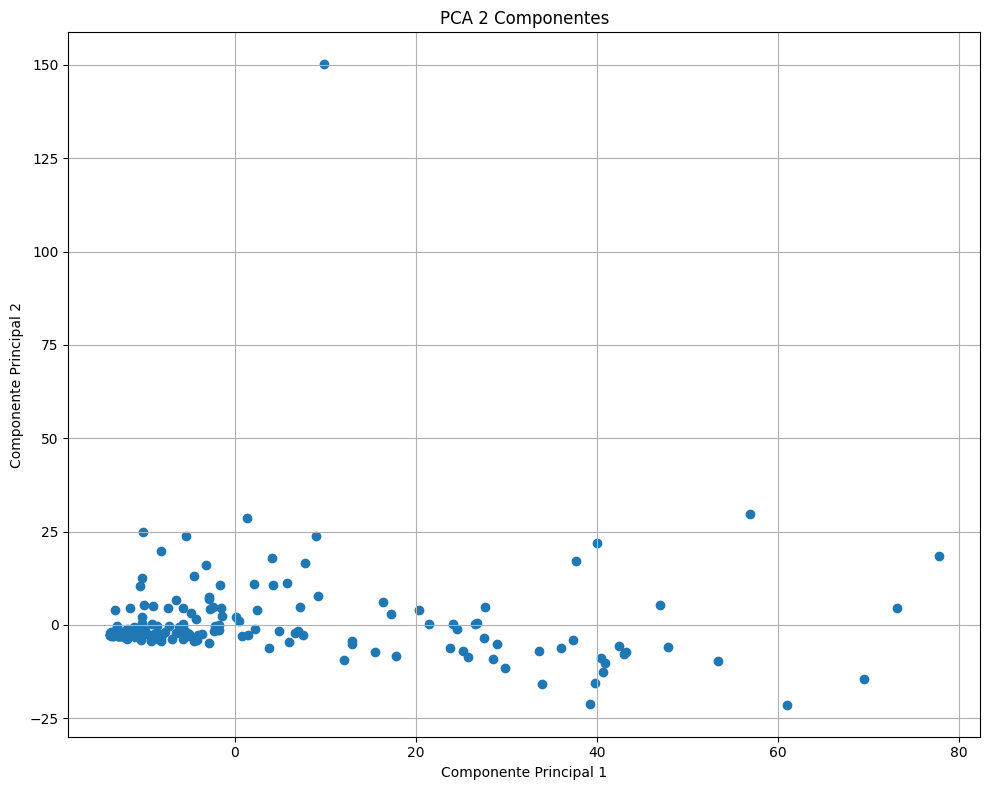

In [105]:
pca_result = plot_pca(X=X_scaled, n_components=2, save_path=img_path+"hs6_pca.png")

### t-SNE

In [106]:
def plot_tsne(X, n_components=2, perplexity=45, random_state=42, title='t-SNE 2 Componentes', xlabel='Componente t-SNE 1', ylabel='Componente t-SNE 2', figsize=(10, 8), labels=None, save_path=None, dpi=300):
    tsne = TSNE(n_components=n_components, random_state=random_state, perplexity=perplexity, init='pca', learning_rate='auto')
    tsne_result = tsne.fit_transform(X)

    plt.figure(figsize=figsize)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
    plt.title(f'{title} com perplexity = {perplexity}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    if labels is not None:
        for i, label in enumerate(labels):
            plt.annotate(label, (tsne_result[i, 0], tsne_result[i, 1]), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)

    plt.tight_layout()

    if save_path is not None:
            plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()
    return tsne_result

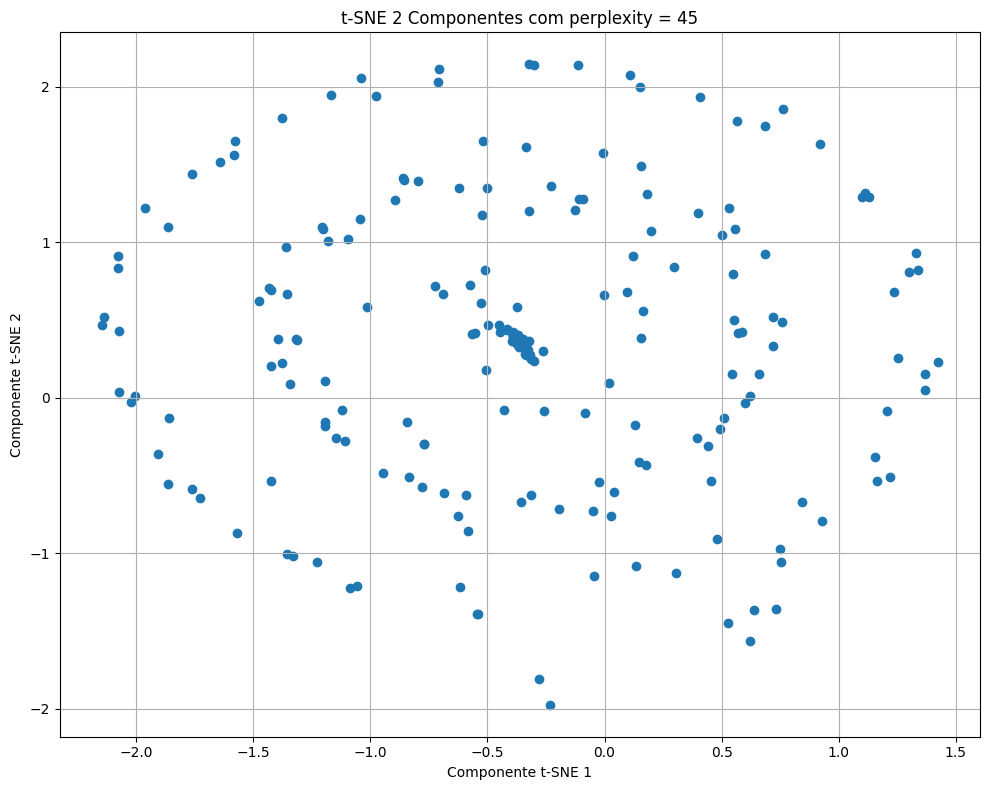

In [107]:
tsne_result = plot_tsne(X=X_scaled, n_components=2, perplexity=45, save_path=img_path+"hs6_tsne.png")

### UMAP

In [108]:
def plot_umap(X, 
              n_neighbors=15, 
              min_dist=0.1,
              metric='euclidean',
              n_components=2,
              random_state=42,
              figsize=(10,8),
              alpha=0.7,
              s=20,
              title=None,
              show=True,
              save_path=None,
              dpi=300):

    X = np.ascontiguousarray(X, dtype=np.float32)

    reducer = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=random_state,
        init="spectral",
        n_epochs=None,
        learning_rate=1.0,
        transform_seed=random_state,

        metric_kwds=None,
        spread=1.0,

    )

    embedding = reducer.fit_transform(X)

    plt.figure(figsize=figsize)
    plt.scatter(embedding[:, 0], embedding[:, 1], s=s, alpha=alpha)
    if title is None:
        title = f"UMAP {n_components}D | n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}"
    plt.title(title)
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    if show:
        plt.show()

    return embedding, reducer


In [109]:
import umap, sklearn, sys

print("Python:", sys.executable)
print("umap:", umap.__version__)
print("sklearn:", sklearn.__version__)

Python: c:\Python314\python.exe
umap: 0.5.9.post2
sklearn: 1.7.2


C:\Users\Gusto\AppData\Roaming\Python\Python314\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


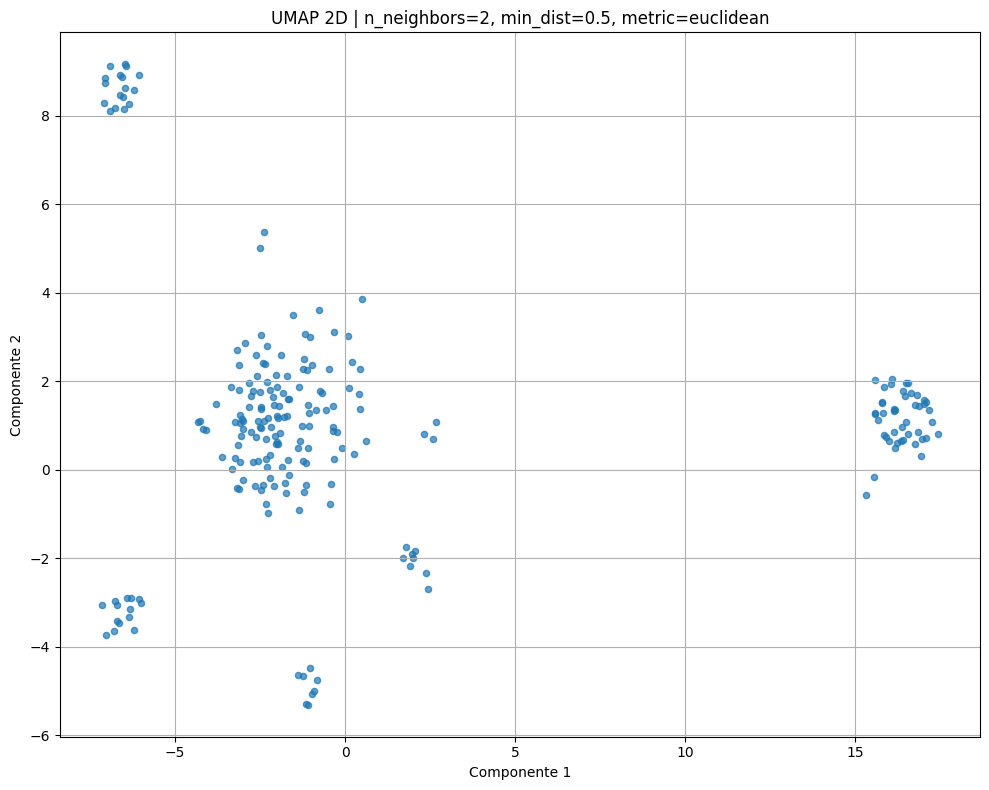

In [110]:
umap_result = plot_umap(
    X=X_scaled,
    n_neighbors=2,
    min_dist=0.5,
    n_components=2,
    save_path=img_path+"hs6_umap.png"
)

Mesmo conseguindo clusters, havia uma quantidade gigantesca de produtos, deixando a análise difícil de lidar, e por isso foram feitos dois tipos de agrupamentos, que seráo mostrados a seguir.

## Agrupamento por HS2

O HS2 são primeiros 2 dígitos do código HS (Harmonized System), representam capítulos, ou seja, categorias amplas de produtos, Por exemplo, dentro do HS2 "Animais Vivos" (01), o HS6 pode especificar "Cavalos, burros, mulas e bardotos vivos" (0101.21).

O HS6 possui um número muito maior de categorias (5606 produtos) em comparação com o HS2 (96 categorias). Para fins de agrupamento e visualização, um número excessivo de categorias torna a análise e a interpretação dos resultados significativamente mais complexas e menos legíveis, e por isso foi escolhido o HS2 para esta análise.

In [111]:
df = pd.read_csv(path+'BACI_HS22_Y2023_V202501.csv')

### Organizando o DataSet

In [112]:
print("Shape:", df.shape)
print(df.head())

Shape: (11232739, 6)
      t  i   j       k       v       q
0  2023  4  20  200290   8.013   5.830
1  2023  4  31  252620   9.808  77.150
2  2023  4  31  680221  33.788  76.655
3  2023  4  31  761510   6.604   2.368
4  2023  4  31  860900   1.500   2.200


In [113]:
df = df[["i", "k", "v"]].copy()
df = df.dropna()
df

i       k        v
0           4  200290    8.013
1           4  252620    9.808
2           4  680221   33.788
3           4  761510    6.604
4           4  860900    1.500
...       ...     ...      ...
11232734  894  903180    8.144
11232735  894  240120  619.897
11232736  894  630900    0.981
11232737  894  820840    4.743
11232738  894  870893    2.269

[11232739 rows x 3 columns]

In [114]:
df["hs6"] = df["k"].astype(int)
df["hs2"] = df["hs6"] // 10000

In [115]:
matrix_hs2 = df.groupby(["i", "hs2"])["v"].sum().unstack(fill_value=0)

In [116]:
print("\nMatriz país x HS2:")
print(matrix_hs2.shape)
print(matrix_hs2.head())


Matriz país x HS2:
(226, 96)
hs2       1        2          3          4         5         6           7   \
i                                                                             
4    147.960    5.291      3.038     81.430  2483.261    87.801  225509.685   
8    304.746  258.794  72732.737  13657.514  1845.649  8226.195  124831.712   
12    40.354  198.844  47276.544   1307.884     0.199    18.891    2324.703   
16     9.476    1.200    177.949      0.000     0.000     0.000       7.658   
20   138.399  604.517    295.160     35.122     0.649    21.743      46.049   

hs2          8          9         10  ...        88        89         90  \
i                                     ...                                  
4    623128.944  95777.920  1802.349  ...   494.034     0.000    471.731   
8     50282.939  12075.772   173.502  ...  5639.316  1678.174  11549.160   
12   128204.230    341.800   373.394  ...  4885.932    84.454   3480.230   
16       77.209      0.026     0.000

In [117]:
original_codes_hs2 = matrix_hs2.index.astype(str).str.zfill(3)

mapped = original_codes_hs2.map(iso_map).astype(str)

final_index = mapped.where(mapped != "nan", original_codes_hs2)

matrix_hs2.index = final_index

matrix_hs2.head()

hs2                  1        2          3          4         5         6   \
i                                                                            
Afghanistan     147.960    5.291      3.038     81.430  2483.261    87.801   
Albania         304.746  258.794  72732.737  13657.514  1845.649  8226.195   
Algeria          40.354  198.844  47276.544   1307.884     0.199    18.891   
American Samoa    9.476    1.200    177.949      0.000     0.000     0.000   
Andorra         138.399  604.517    295.160     35.122     0.649    21.743   

hs2                     7           8          9         10  ...        88  \
i                                                            ...             
Afghanistan     225509.685  623128.944  95777.920  1802.349  ...   494.034   
Albania         124831.712   50282.939  12075.772   173.502  ...  5639.316   
Algeria           2324.703  128204.230    341.800   373.394  ...  4885.932   
American Samoa       7.658      77.209      0.026     0.000  ...    24.675   
Andorra             46.049      20.643     94.314     0.000  ...   283.791   

hs2                   89         90        91       92       93         94  \
i                                                                            
Afghanistan        0.000    471.731    10.747   14.580    0.000    449.456   
Albania         1678.174  11549.160    68.971    9.623    4.168  79586.002   
Algeria           84.454   3480.230    14.023    1.341    2.661   1100.797   
American Samoa     0.000    222.911     1.298    0.113    0.000    129.097   
Andorra         1405.830  20660.183  9200.877  227.554  140.475   1006.696   

hs2                   95         96         97  
i                                               
Afghanistan       67.846    185.624   1486.269  
Albania         1444.671  11629.367    810.318  
Algeria          151.632   3710.045    970.965  
American Samoa     8.799     30.516      0.000  
Andorra         1066.590    278.823  51383.667  

[5 rows x 96 columns]

In [118]:
hs2_codes = pd.read_csv(path+"hs2_codes.csv")

In [119]:
hs2_codes.head()

HS2_code                                        Description
0         1                                       Live animals
1         2                         Meat and edible meat offal
2         3  Fish and crustaceans, molluscs and other aquat...
3         4          Dairy produce; birds' eggs; natural honey
4         5  Products of animal origin, not elsewhere speci...

In [120]:
hs2_codes_map = dict(zip(hs2_codes['HS2_code'].astype(str), hs2_codes['Description']))

matrix_hs2.columns = matrix_hs2.columns.astype(str)
matrix_hs2 = matrix_hs2.rename(columns=hs2_codes_map)

matrix_hs2.head()

hs2             Live animals  Meat and edible meat offal  \
i                                                          
Afghanistan          147.960                       5.291   
Albania              304.746                     258.794   
Algeria               40.354                     198.844   
American Samoa         9.476                       1.200   
Andorra              138.399                     604.517   

hs2             Fish and crustaceans, molluscs and other aquatic invertebrates  \
i                                                                                
Afghanistan                                                 3.038                
Albania                                                 72732.737                
Algeria                                                 47276.544                
American Samoa                                            177.949                
Andorra                                                   295.160                

hs2             Dairy produce; birds' eggs; natural honey  \
i                                                           
Afghanistan                                        81.430   
Albania                                         13657.514   
Algeria                                          1307.884   
American Samoa                                      0.000   
Andorra                                            35.122   

hs2             Products of animal origin, not elsewhere specified or included  \
i                                                                                
Afghanistan                                              2483.261                
Albania                                                  1845.649                
Algeria                                                     0.199                
American Samoa                                              0.000                
Andorra                                                     0.649                

hs2             Live trees and other plants; bulbs, roots; cut flowers  \
i                                                                        
Afghanistan                                                87.801        
Albania                                                  8226.195        
Algeria                                                    18.891        
American Samoa                                              0.000        
Andorra                                                    21.743        

hs2             Edible vegetables and certain roots and tubers  \
i                                                                
Afghanistan                                         225509.685   
Albania                                             124831.712   
Algeria                                               2324.703   
American Samoa                                           7.658   
Andorra                                                 46.049   

hs2             Edible fruit and nuts; peel of citrus or melons  \
i                                                                 
Afghanistan                                          623128.944   
Albania                                               50282.939   
Algeria                                              128204.230   
American Samoa                                           77.209   
Andorra                                                  20.643   

hs2             Coffee, tea, maté and spices   Cereals  ...  \
i                                                       ...   
Afghanistan                        95777.920  1802.349  ...   
Albania                            12075.772   173.502  ...   
Algeria                              341.800   373.394  ...   
American Samoa                         0.026     0.000  ...   
Andorra                               94.314     0.000  ...   

hs2             Aircraft, spacecraft, and parts thereof  \
i                                               

In [121]:
matrix_norm_hs2 = matrix_hs2.div(matrix_hs2.sum(axis=1), axis=0).fillna(0)
matrix_norm_hs2

hs2                     Live animals  Meat and edible meat offal  \
i                                                                  
Afghanistan             8.897872e-05                    0.000003   
Albania                 6.929070e-05                    0.000059   
Algeria                 7.795909e-07                    0.000004   
American Samoa          5.196849e-04                    0.000066   
Andorra                 5.462756e-04                    0.002386   
...                              ...                         ...   
Venezuela               1.187104e-04                    0.000200   
Wallis and Futuna Isds  2.595333e-06                    0.000000   
Samoa                   0.000000e+00                    0.000000   
Yemen                   0.000000e+00                    0.000028   
Zambia                  8.361208e-04                    0.000507   

hs2                     Fish and crustaceans, molluscs and other aquatic invertebrates  \
i                                                                                        
Afghanistan                                                      0.000002                
Albania                                                          0.016537                
Algeria                                                          0.000913                
American Samoa                                                   0.009759                
Andorra                                                          0.001165                
...                                                                   ...                
Venezuela                                                        0.050429                
Wallis and Futuna Isds                                           0.005761                
Samoa                                                            0.006804                
Yemen                                                            0.211244                
Zambia                                                           0.001387                

hs2                     Dairy produce; birds' eggs; natural honey  \
i                                                                   
Afghanistan                                              0.000049   
Albania                                                  0.003105   
Algeria                                                  0.000025   
American Samoa                                           0.000000   
Andorra                                                  0.000139   
...                                                           ...   
Venezuela                                                0.000052   
Wallis and Futuna Isds                                   0.001352   
Samoa                                                    0.000000   
Yemen                                                    0.011534   
Zambia                                                   0.004414   

hs2                     Products of animal origin, not elsewhere specified or included  \
i                                                                                        
Afghanistan                                                  1.493359e-03                
Albania                                                      4.196489e-04                
Algeria                                                      3.844441e-09                
American Samoa                                               0.000000e+00                
Andorra                                                      2.561672e-06                
...                                                                   ...                
Venezuela                                                    5.386153e-04                
Wallis and Futuna Isds                                       0.000000e+00                
Samoa                                                        0.000000e+00                
Yemen                                                   

In [122]:
scaler = StandardScaler()
X_scaled_hs2 = scaler.fit_transform(matrix_norm_hs2)
X_scaled_hs2

array([[-0.13336668, -0.28100154, -0.34438456, ..., -0.48498892,
        -0.50144823, -0.12644764],
       [-0.13389823, -0.27839403, -0.255077  , ..., -0.42393403,
         0.48506403, -0.15259328],
       [-0.13574793, -0.28097064, -0.33946161, ..., -0.49302648,
        -0.51701198, -0.1586911 ],
       ...,
       [-0.13576898, -0.2811506 , -0.30764828, ..., -0.33824311,
        -0.35940556, -0.1404026 ],
       [-0.13576898, -0.27985867,  0.79652068, ..., -0.48213143,
        -0.46279025, -0.04694003],
       [-0.11319495, -0.25739769, -0.33690431, ..., -0.49248877,
        -0.44950087, -0.15679341]], shape=(226, 96))

### Redução de Dimensionalidade

#### PCA

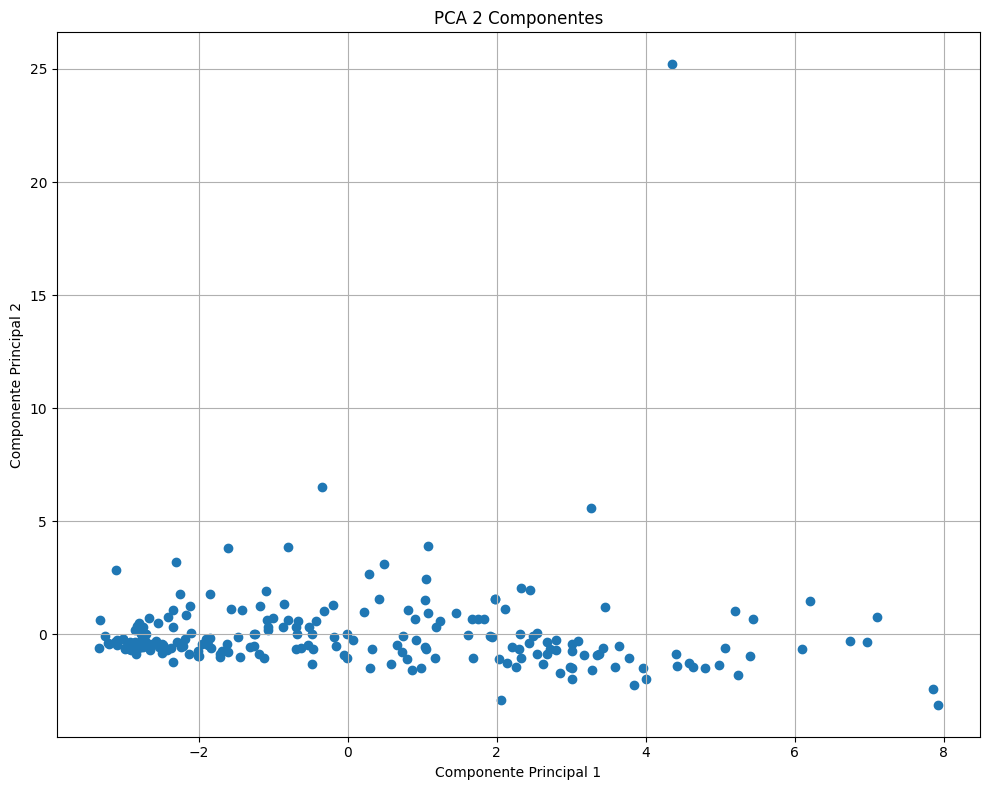

In [123]:
pca_hs2 = plot_pca(X=X_scaled_hs2, n_components=2, save_path=img_path+"hs2_pca.png")

#### t-SNE

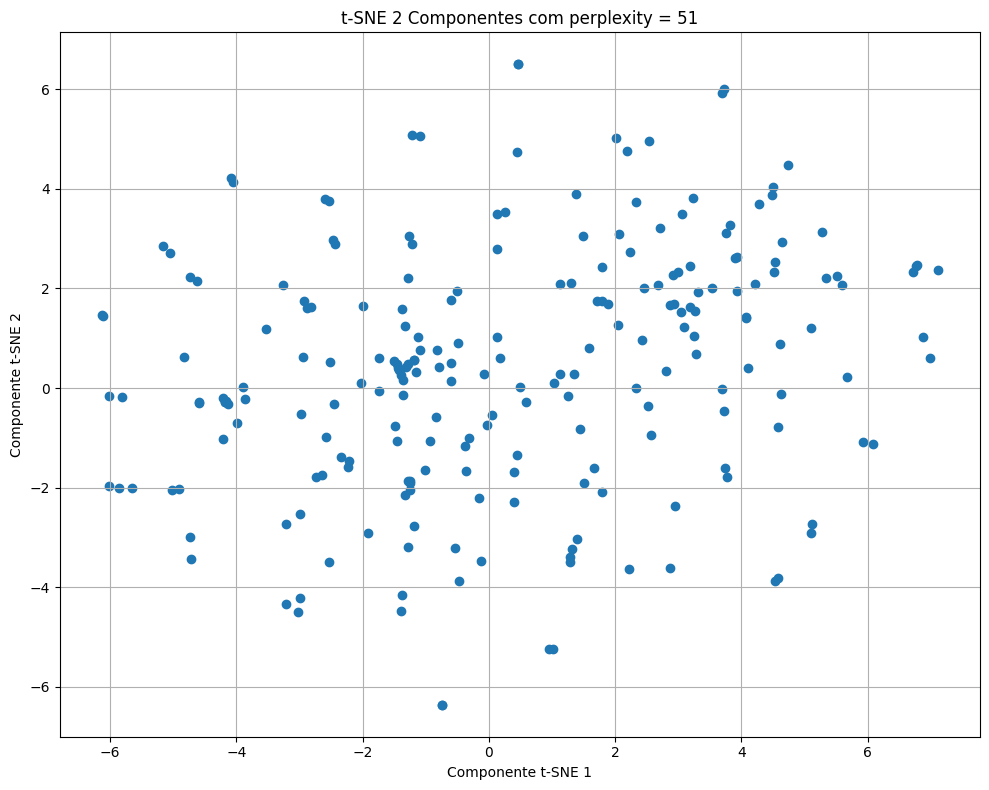

In [124]:
tsne_hs2 = plot_tsne(X=X_scaled_hs2, n_components=2, perplexity=51, save_path=img_path+"hs2_tsne.png")

#### UMAP

C:\Users\Gusto\AppData\Roaming\Python\Python314\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


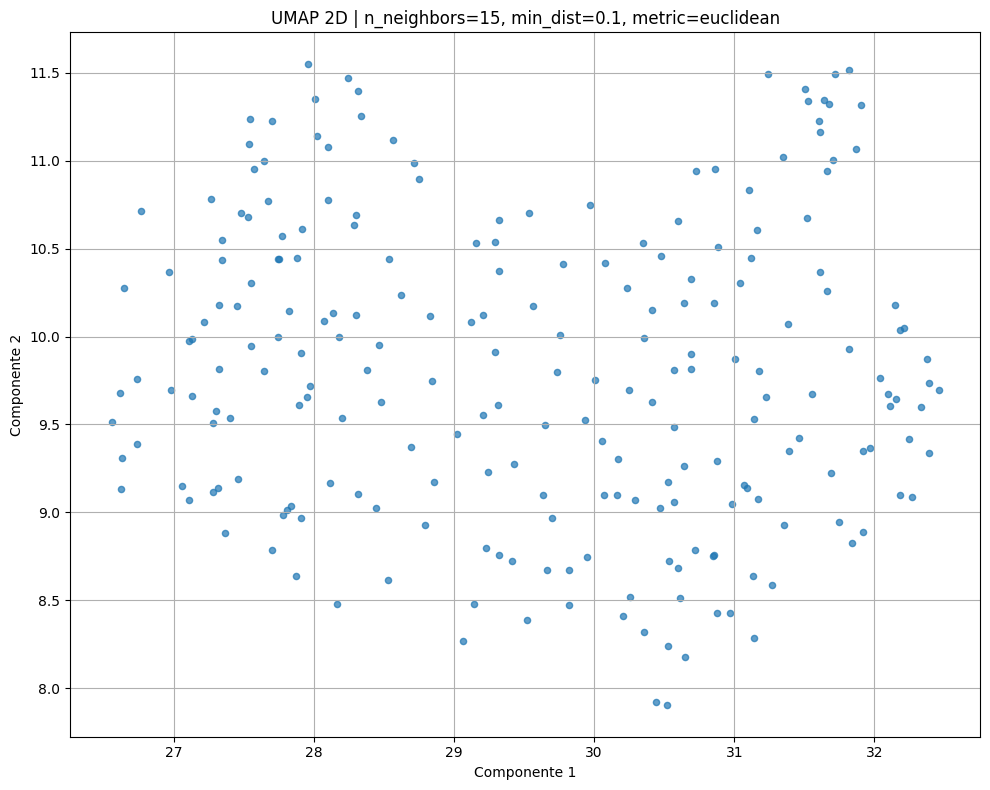

In [125]:
umap__hs2 = plot_umap(X=X_scaled_hs2, n_neighbors=15, min_dist=0.1, save_path=img_path+"hs2_umap.png")

## Agrupamento pela Broad Economic Categories (BEC1) - ONU

A Broad Economic Categories (BEC) é uma classificação desenvolvida pela Organização das Nações Unidas (ONU) que agrupa produtos com base em seu uso final econômico. Ao contrário do Sistema Harmonizado (HS), que classifica produtos pela sua natureza ou matéria-prima, o BEC os organiza de acordo com sua função na economia.

As categorias do BEC1 utilizadas na análise são:

In [126]:
bec_names = {
    1.0: "Food & Beverages",
    3.0: "Industrial Supplies",
    4.0: "Fuels & Lubricants",
    5.0: "Capital Goods",
    6.0: "Transport Equipment",
    7.0: "Consumer Goods",
    8.0: "Goods n.e.s."
}

*   **Food & Beverages (Alimentos e Bebidas):** Produtos alimentícios e bebidas.
*   **Industrial Supplies (Insumos Industriais):** Materiais e componentes usados na produção.
*   **Fuels & Lubricants (Combustíveis e Lubrificantes):** Produtos energéticos.
*   **Capital Goods (Bens de Capital):** Máquinas, equipamentos e outros bens utilizados para produzir outros bens e serviços.
*   **Transport Equipment (Equipamentos de Transporte):** Veículos, aeronaves, embarcações e suas partes.
*   **Consumer Goods (Bens de Consumo):** Produtos destinados ao consumo final por indivíduos.
*   **Goods n.e.s. (Bens não especificados em outro lugar):** Uma categoria residual para produtos que não se encaixam nas demais.

Assim como o HS2 em relação ao HS6, o BEC1 possui um número reduzido de categorias (7 no total, conforme utilizado na análise). Isso facilita a visualização, a interpretação dos clusters e a identificação de perfis de exportação claros.

In [127]:
def iso3_to_name(iso3):
    try:
        return pycountry.countries.get(alpha_3=iso3).name
    except:
        return iso3

df.index = df.index.map(iso3_to_name)

In [128]:
baci_raw  = pd.read_csv(path+'BACI_HS22_Y2023_V202501.csv')

onu_map = pd.read_csv(path+"bec_map.csv")

In [129]:
baci = baci_raw.merge(
    onu_map,
    left_on="k",  # código HS6
    right_on="hs6",
    how="left"
)
# Fill NaN 'bec' values with 8.0, which corresponds to 'Goods n.e.s.'
# baci['bec'] = baci['bec'].fillna(8.0)

In [130]:
baci["exporter"] = baci["i"].map(iso3_to_name)
baci["importer"] = baci["j"].map(iso3_to_name)

In [131]:
print(baci.columns.tolist())

['t', 'i', 'j', 'k', 'v', 'q', 'hs6', 'bec', 'exporter', 'importer']


In [132]:
matrix_bec = (
    baci[["exporter", "bec", "v"]]
    .groupby(["exporter", "bec"])["v"]
    .sum()
    .unstack(fill_value=0)
)

In [133]:
print(matrix_bec.shape)
print(matrix_bec.head())

(225, 7)
bec           1.0       3.0       4.0           5.0        6.0       7.0  \
exporter                                                                   
4          15.777   154.217    50.467  0.000000e+00     44.483   107.225   
8           1.065  4608.935   805.047  1.965692e+05    421.081  3730.305   
12         12.311  3566.914  1409.031  1.414157e+07    115.752    21.572   
16          9.174     0.000     1.372  0.000000e+00     16.095     0.000   
20        109.223   112.084   463.127  1.900000e-02  21681.458    90.288   

bec               8.0  
exporter               
4            5088.259  
8           41773.193  
12        1686884.285  
16             19.433  
20             27.432  


In [134]:
matrix_bec = matrix_bec.rename(columns=bec_names)
matrix_bec

bec       Food & Beverages  Industrial Supplies  Fuels & Lubricants  \
exporter                                                              
4                   15.777              154.217              50.467   
8                    1.065             4608.935             805.047   
12                  12.311             3566.914            1409.031   
16                   9.174                0.000               1.372   
20                 109.223              112.084             463.127   
...                    ...                  ...                 ...   
862                  0.000             4153.742             158.032   
876                  0.000                2.369               0.000   
882                  0.000               74.136               2.977   
887                  0.000              131.655              88.904   
894                333.086             1308.739            2004.409   

bec       Capital Goods  Transport Equipment  Consumer Goods  Goods n.e.s.  
exporter                                                                    
4          0.000000e+00               44.483         107.225      5088.259  
8          1.965692e+05              421.081        3730.305     41773.193  
12         1.414157e+07              115.752          21.572   1686884.285  
16         0.000000e+00               16.095           0.000        19.433  
20         1.900000e-02            21681.458          90.288        27.432  
...                 ...                  ...             ...           ...  
862        4.045189e+06              245.134       12222.781    459068.656  
876        0.000000e+00                0.000           0.000         0.000  
882        0.000000e+00                0.000           0.000         2.044  
887        0.000000e+00             2408.780        9643.298      1090.723  
894        1.136500e+01             2021.972       67640.276   2403768.116  

[225 rows x 7 columns]

In [135]:
original_codes_bec = matrix_bec.index.astype(str).str.zfill(3)

mapped = original_codes_bec.map(iso_map).astype(str)

final_index = mapped.where(mapped != "nan", original_codes_bec)

matrix_bec.index = final_index

matrix_bec.head()

bec             Food & Beverages  Industrial Supplies  Fuels & Lubricants  \
exporter                                                                    
Afghanistan               15.777              154.217              50.467   
Albania                    1.065             4608.935             805.047   
Algeria                   12.311             3566.914            1409.031   
American Samoa             9.174                0.000               1.372   
Andorra                  109.223              112.084             463.127   

bec             Capital Goods  Transport Equipment  Consumer Goods  \
exporter                                                             
Afghanistan      0.000000e+00               44.483         107.225   
Albania          1.965692e+05              421.081        3730.305   
Algeria          1.414157e+07              115.752          21.572   
American Samoa   0.000000e+00               16.095           0.000   
Andorra          1.900000e-02            21681.458          90.288   

bec             Goods n.e.s.  
exporter                      
Afghanistan         5088.259  
Albania            41773.193  
Algeria          1686884.285  
American Samoa        19.433  
Andorra               27.432

In [136]:
matrix_norm_bec = matrix_bec.div(matrix_bec.sum(axis=1), axis=0).fillna(0)
matrix_norm_bec

bec                     Food & Beverages  Industrial Supplies  \
exporter                                                        
Afghanistan                 2.889334e-03             0.028243   
Albania                     4.295934e-06             0.018591   
Algeria                     7.775247e-07             0.000225   
American Samoa              1.991145e-01             0.000000   
Andorra                     4.857890e-03             0.004985   
...                                  ...                  ...   
Venezuela                   0.000000e+00             0.000919   
Wallis and Futuna Isds      0.000000e+00             1.000000   
Samoa                       0.000000e+00             0.936569   
Yemen                       0.000000e+00             0.009852   
Zambia                      1.344668e-04             0.000528   

bec                     Fuels & Lubricants  Capital Goods  \
exporter                                                    
Afghanistan                       0.009242   0.000000e+00   
Albania                           0.003247   7.929093e-01   
Algeria                           0.000089   8.931379e-01   
American Samoa                    0.029778   0.000000e+00   
Andorra                           0.020598   8.450592e-07   
...                                    ...            ...   
Venezuela                         0.000035   8.947480e-01   
Wallis and Futuna Isds            0.000000   0.000000e+00   
Samoa                             0.037609   0.000000e+00   
Yemen                             0.006653   0.000000e+00   
Zambia                            0.000809   4.588049e-06   

bec                     Transport Equipment  Consumer Goods  Goods n.e.s.  
exporter                                                                   
Afghanistan                        0.008146        0.019637      0.931843  
Albania                            0.001699        0.015047      0.168502  
Algeria                            0.000007        0.000001      0.106538  
American Samoa                     0.349329        0.000000      0.421778  
Andorra                            0.964322        0.004016      0.001220  
...                                     ...             ...           ...  
Venezuela                          0.000054        0.002704      0.101541  
Wallis and Futuna Isds             0.000000        0.000000      0.000000  
Samoa                              0.000000        0.000000      0.025822  
Yemen                              0.180253        0.721622      0.081620  
Zambia                             0.000816        0.027306      0.970401  

[225 rows x 7 columns]

In [137]:
scaler = StandardScaler()
X_scaled_bec_norm = scaler.fit_transform(matrix_norm_bec)
X_scaled_bec_norm[:5]

array([[-0.08380851, -0.56324467, -0.39795916, -0.54940764, -0.45999497,
        -0.60284776,  2.5439144 ],
       [-0.12740131, -0.59578744, -0.42392609,  1.81301909, -0.49064985,
        -0.6168878 , -0.07072691],
       [-0.12745447, -0.65771411, -0.43760639,  2.1116444 , -0.49869032,
        -0.6629136 , -0.28296932],
       [ 2.88114503, -0.65847369, -0.30900896, -0.54940764,  1.16207118,
        -0.66291776,  0.79680928],
       [-0.05406371, -0.64166473, -0.34877075, -0.54940512,  4.08589476,
        -0.65063342, -0.64371222]])

### PCA

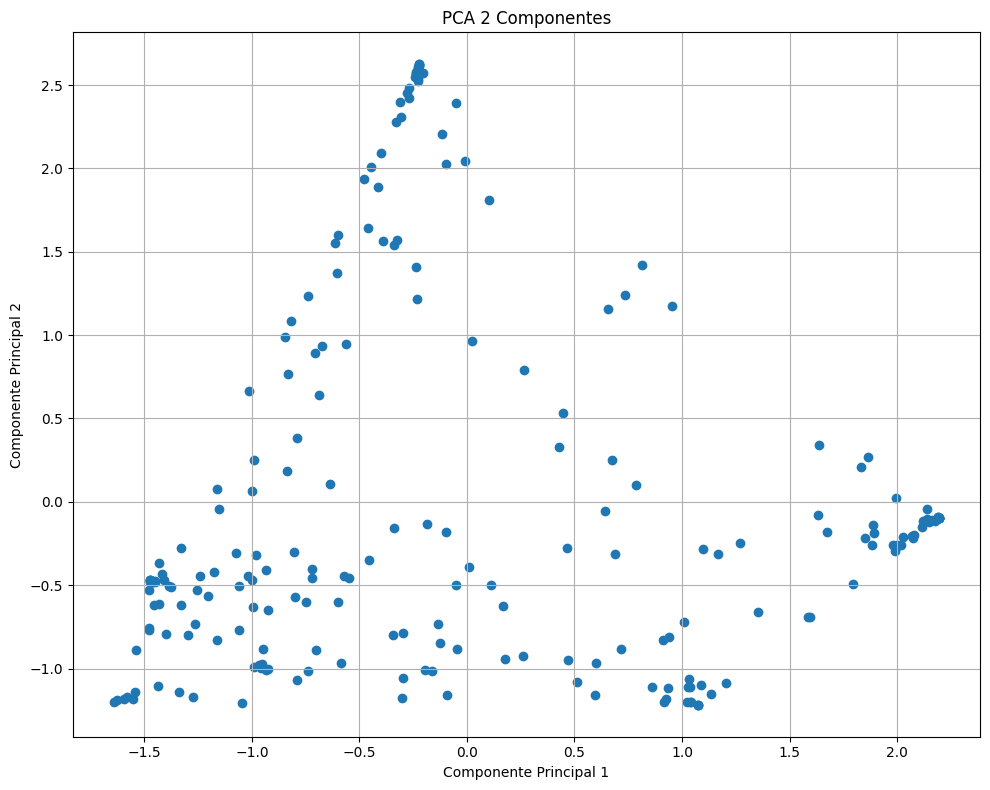

In [138]:
pca_result_bec_norm = plot_pca(X=X_scaled_bec_norm, n_components=2, save_path=img_path+"bec_pca.png")

### t-SNE

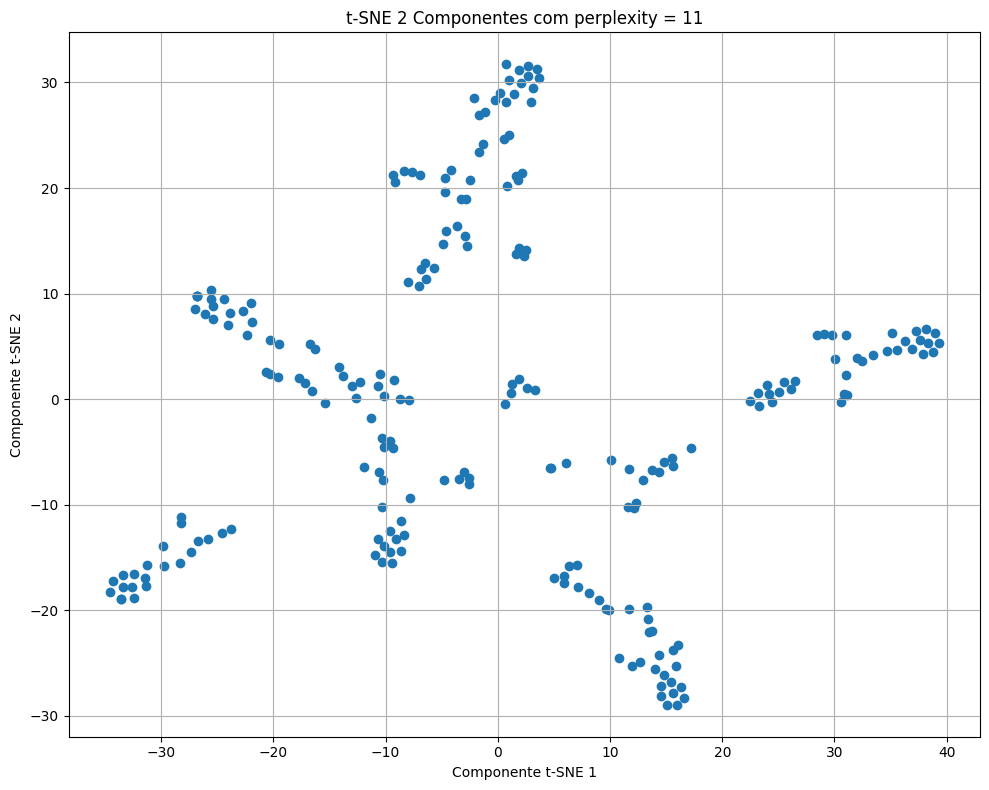

In [139]:
tsne_result_bec_norm = plot_tsne(X=X_scaled_bec_norm, n_components=2, perplexity=11, save_path=img_path+"bec_tsne.png")

### UMAP

C:\Users\Gusto\AppData\Roaming\Python\Python314\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


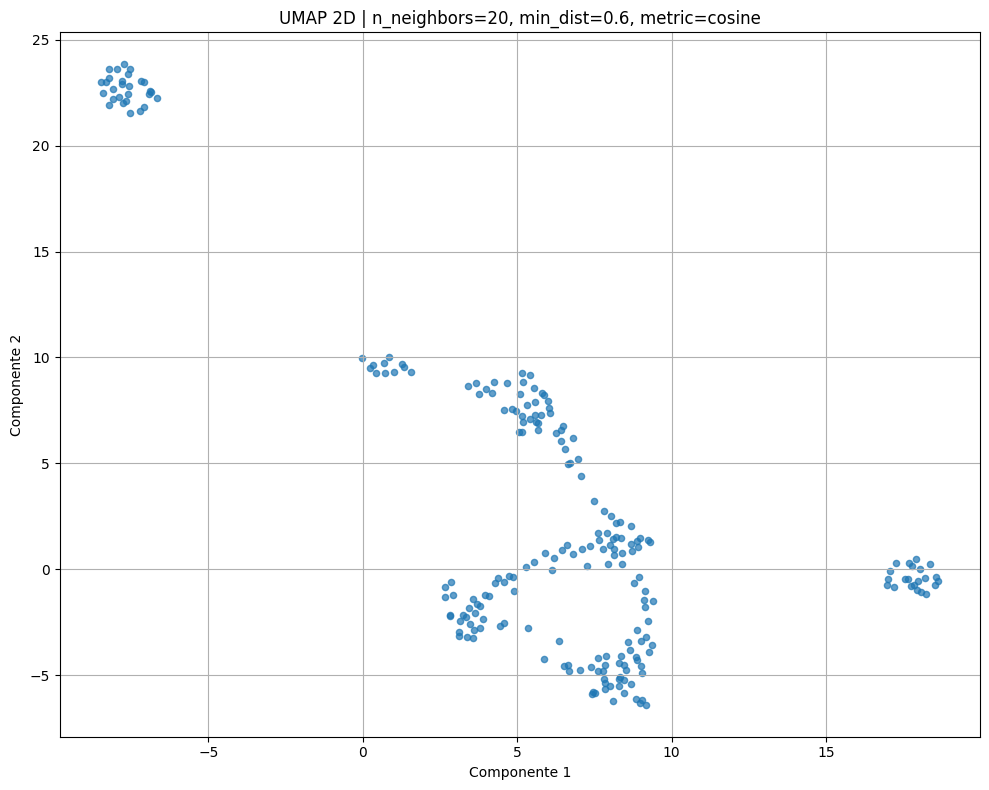

In [140]:
umap_bec_norm_sz, _ = plot_umap(X=X_scaled_bec_norm, n_neighbors=20, min_dist=0.6, metric="cosine", save_path=img_path+"bec_umap.png")

## Métodos de clusterização

A seguir, foram criadas várias funções de clusterização e outras funções de apoio para a análise de cada redução de dimensionalidade.

### K-Means

Gráfico do joelho:

In [141]:
def kmeans_elbow_plot(embedding, k_range=range(1,11), title="KMeans Elbow Method"):
    inertia = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(embedding)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(10,6))
    plt.plot(k_range, inertia, marker='o', linestyle='-', color='tab:blue')
    plt.title(title)
    plt.xlabel("Número de clusters (k)")
    plt.ylabel("Inertia")
    plt.xticks(k_range)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

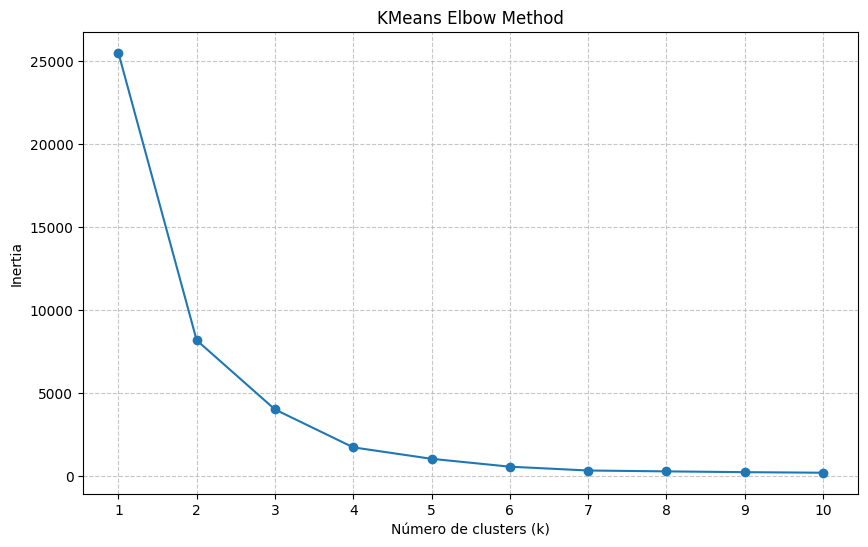

In [142]:
kmeans_elbow_plot(umap_bec_norm_sz)

In [143]:
def plot_kmeans_clusters(
    embedding,
    matrix_norm,
    n_clusters=3,
    title="KMeans Clustering",
    heatmap_figsize=(15, 8),
    save_path=None,
    dpi=300
):

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embedding)

    df_clusters = matrix_norm.copy()
    df_clusters['Cluster'] = clusters

    cmap = plt.cm.get_cmap("tab20", n_clusters)
    colors = [cmap(i) for i in clusters]

    fig1, ax1 = plt.subplots(figsize=(12, 8))

    for i, (x, y) in enumerate(embedding):
        ax1.scatter(
            x, y,
            color=colors[i],
            s=60,
            alpha=0.85,
            edgecolor='black',
            linewidth=0.5
        )

    ax1.set_title(f"{title} (k={n_clusters})")
    ax1.set_xlabel("Componente 1")
    ax1.set_ylabel("Componente 2")
    ax1.grid(True, linestyle='--', alpha=0.5)

    for i, country_name in enumerate(matrix_norm.index):
        ax1.annotate(
            country_name,
            (embedding[i, 0], embedding[i, 1]),
            textcoords="offset points",
            xytext=(4, 4),
            ha='center',
            fontsize=8
        )

    legend_elements = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markerfacecolor=cmap(c),
            label=f"Cluster {c}",
            markersize=10,
            markeredgecolor='black'
        )
        for c in range(n_clusters)
    ]
    ax1.legend(handles=legend_elements, title="Clusters")
    fig1.tight_layout()

    if save_path is not None:
        fig1.savefig(
            f"{save_path}_embedding.png",
            dpi=dpi,
            bbox_inches="tight"
        )

    plt.show()

    fig2, ax2 = plt.subplots(figsize=heatmap_figsize)

    cluster_means = df_clusters.groupby('Cluster').mean(numeric_only=True)

    sns.heatmap(
        cluster_means.T,
        annot=True,
        fmt=".6f",
        cmap='viridis',
        linewidths=.5,
        linecolor='black',
        ax=ax2
    )

    ax2.set_title("Média de produtos por Cluster")
    ax2.set_xlabel("Cluster")
    ax2.set_ylabel("Produto")
    fig2.tight_layout()

    if save_path is not None:
        fig2.savefig(
            f"{save_path}_heatmap.png",
            dpi=dpi,
            bbox_inches="tight"
        )

    plt.show()

    return clusters, cluster_means


C:\Users\Gusto\AppData\Local\Temp\ipykernel_12636\2956179305.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_clusters)


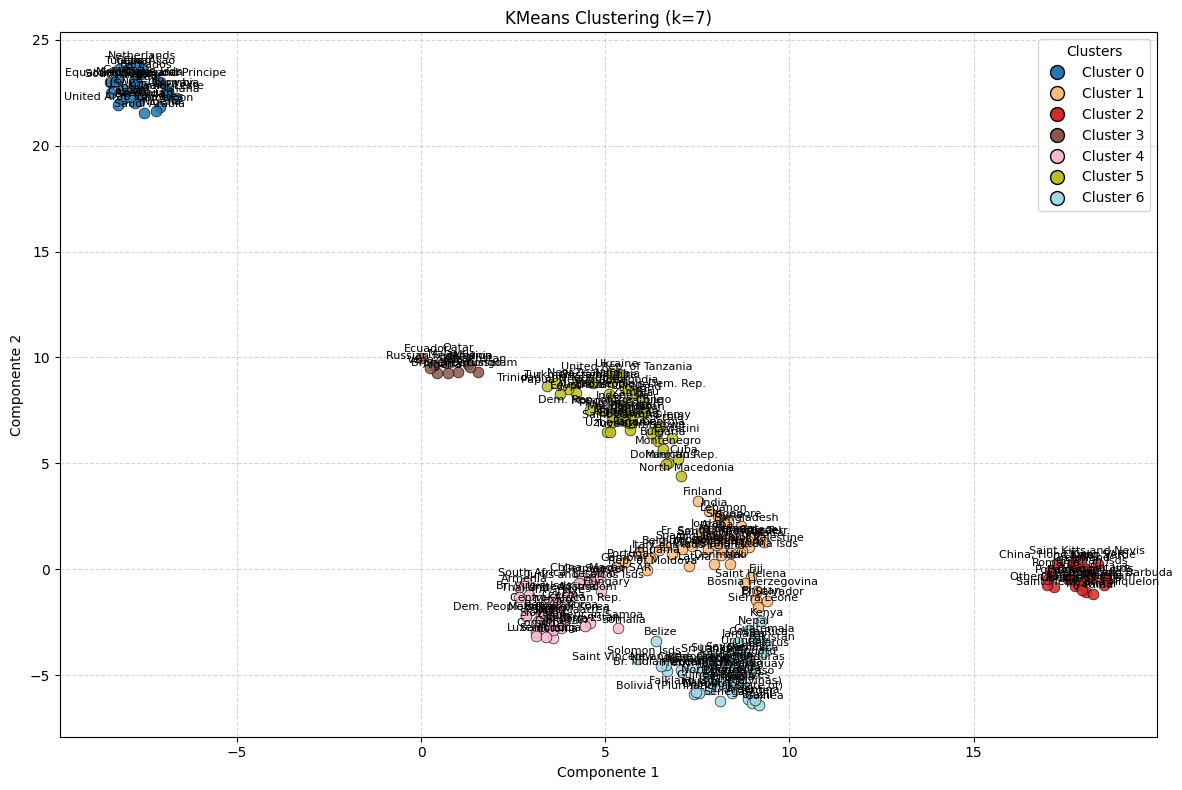

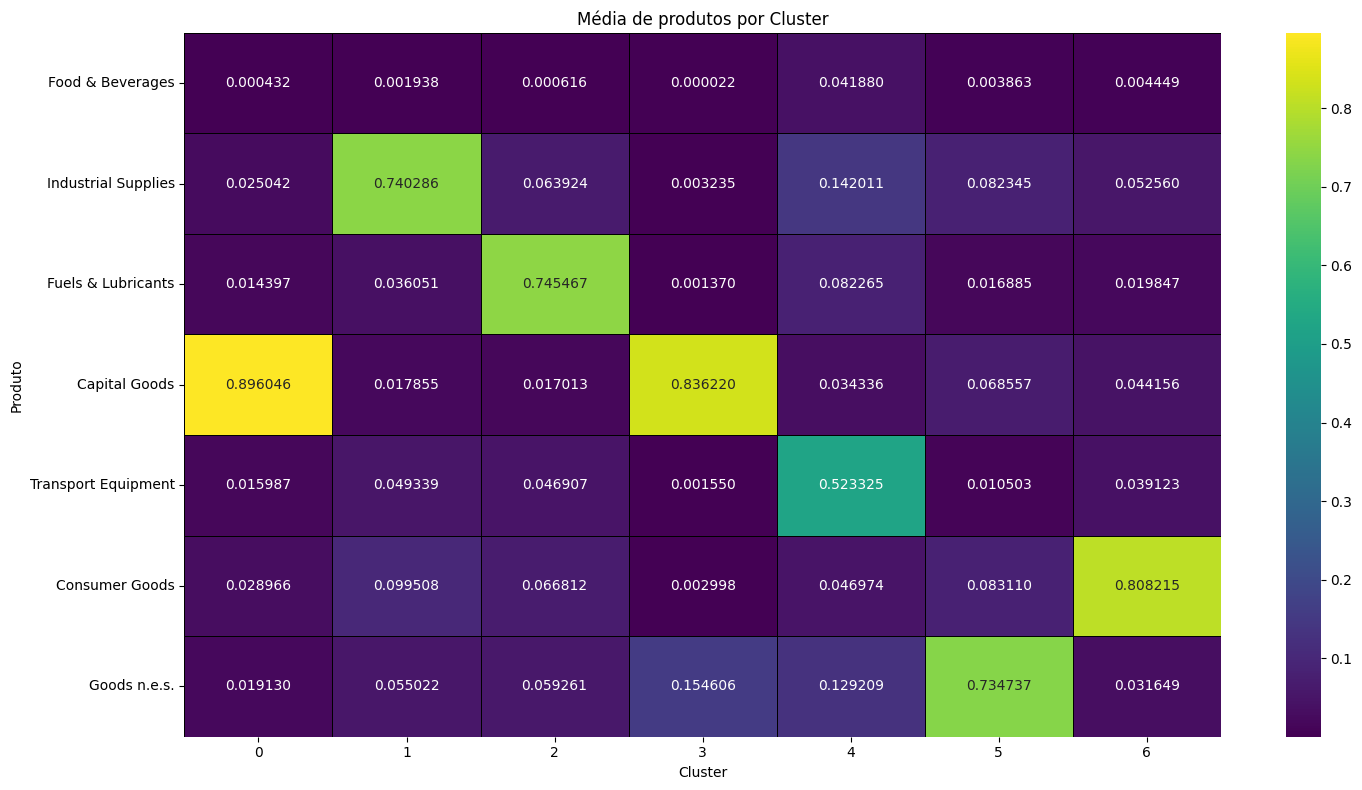

In [144]:
_ = plot_kmeans_clusters(
    umap_bec_norm_sz,
    matrix_norm_bec,
    7
)

### Hierarchical Clustering

Dendograma:

In [145]:
def plot_dendrogram(embedding, method='ward', metric='euclidean', figsize=(20,10)):
    linked = linkage(embedding, method=method, metric=metric)

    plt.figure(figsize=figsize)
    dendrogram(
        linked,
        orientation='top',
        distance_sort='descending',
        show_leaf_counts=True
    )
    plt.title('Dendrogram for Hierarchical Clustering')
    plt.xlabel('Sample Index or Cluster Size')
    plt.ylabel('Distance')
    plt.show()
    return linked

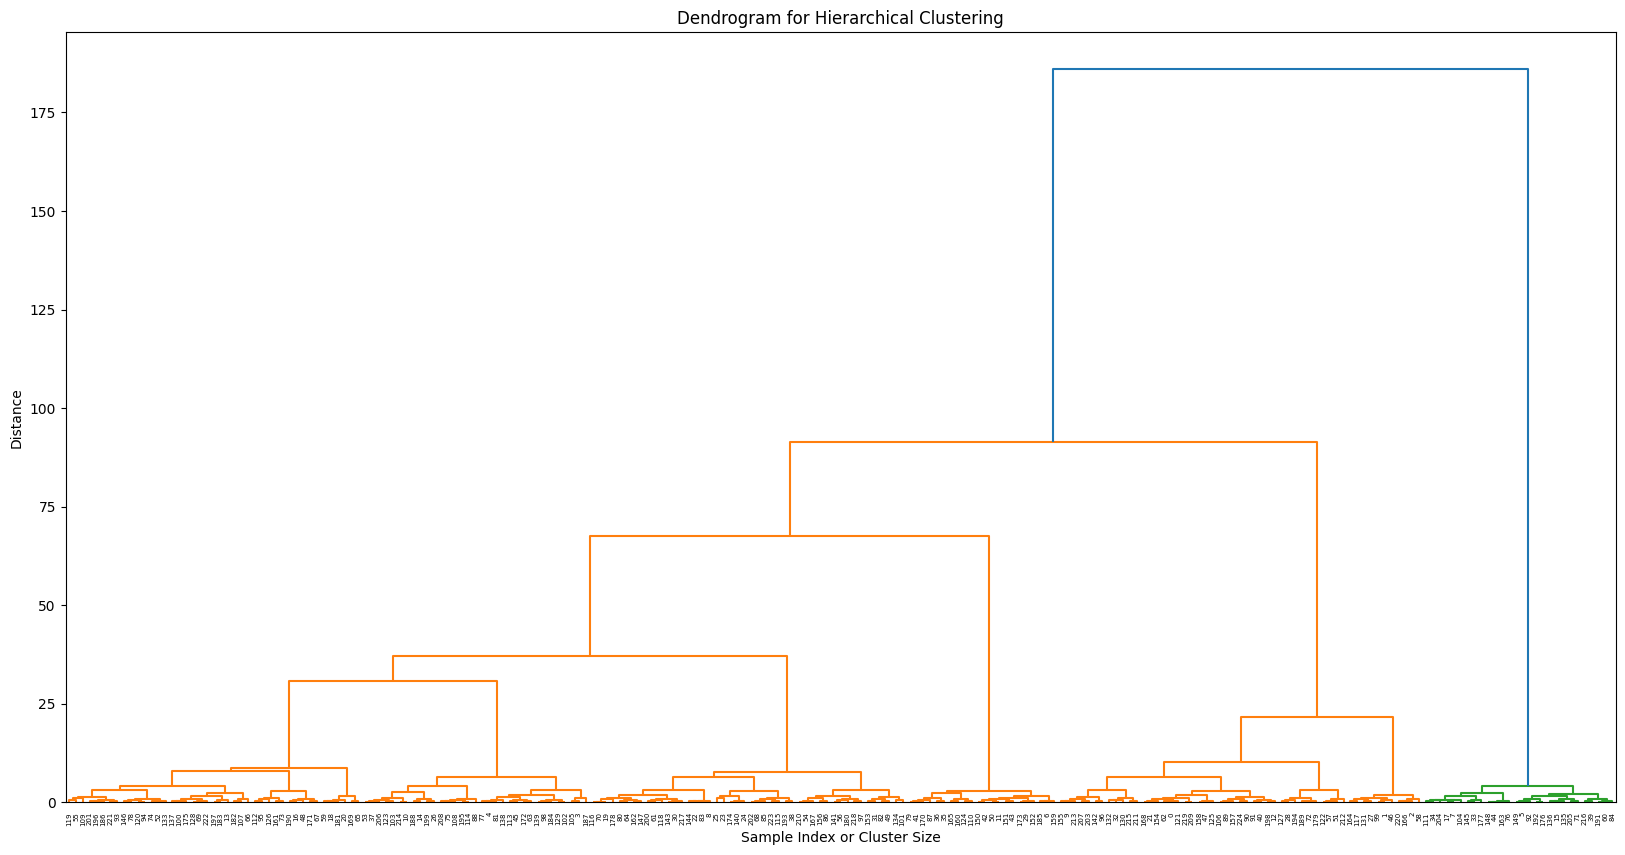

In [146]:
_ = plot_dendrogram(umap_bec_norm_sz)

In [147]:
def hierarchical_clustering(
    embedding,
    matrix_norm,
    n_clusters=3,
    metric='euclidean',
    linkage_method='ward',
    figsize=(12, 8),
    heatmap_figsize=(15, 8),
    save_path=None,
    dpi=300
):

    hac = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric=metric,
        linkage=linkage_method
    )
    clusters = hac.fit_predict(embedding)

    matrix_norm_clusters = matrix_norm.copy()
    matrix_norm_clusters['Hierarchical_Cluster'] = clusters

    fig1, ax1 = plt.subplots(figsize=figsize)

    scatter = ax1.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=clusters,
        cmap='viridis',
        s=50,
        alpha=0.7
    )

    ax1.set_title(f'Hierarchical Clustering (k={n_clusters})')
    ax1.set_xlabel('Componente 1')
    ax1.set_ylabel('Componente 2')
    ax1.grid(True)

    for i, country in enumerate(matrix_norm.index):
        ax1.annotate(
            country,
            (embedding[i, 0], embedding[i, 1]),
            textcoords="offset points",
            xytext=(5, 5),
            ha='center',
            fontsize=8
        )

    ax1.legend(*scatter.legend_elements(), title='Clusters')
    fig1.tight_layout()

    if save_path:
        fig1.savefig(f"{save_path}_embedding.png", dpi=dpi, bbox_inches="tight")

    plt.show()

    cluster_characteristics = (
        matrix_norm_clusters
        .groupby('Hierarchical_Cluster')
        .mean(numeric_only=True)
    )

    fig2, ax2 = plt.subplots(figsize=heatmap_figsize)

    sns.heatmap(
        cluster_characteristics.T,
        annot=True,
        cmap='viridis',
        fmt='.6f',
        linewidths=.5,
        linecolor='black',
        ax=ax2
    )

    ax2.set_title('Mean Export Proportions per Hierarchical Cluster')
    ax2.set_xlabel('Hierarchical Cluster')
    ax2.set_ylabel('Product Type')
    fig2.tight_layout()

    if save_path:
        fig2.savefig(f"{save_path}_heatmap.png", dpi=dpi, bbox_inches="tight")

    plt.show()

    return clusters, cluster_characteristics


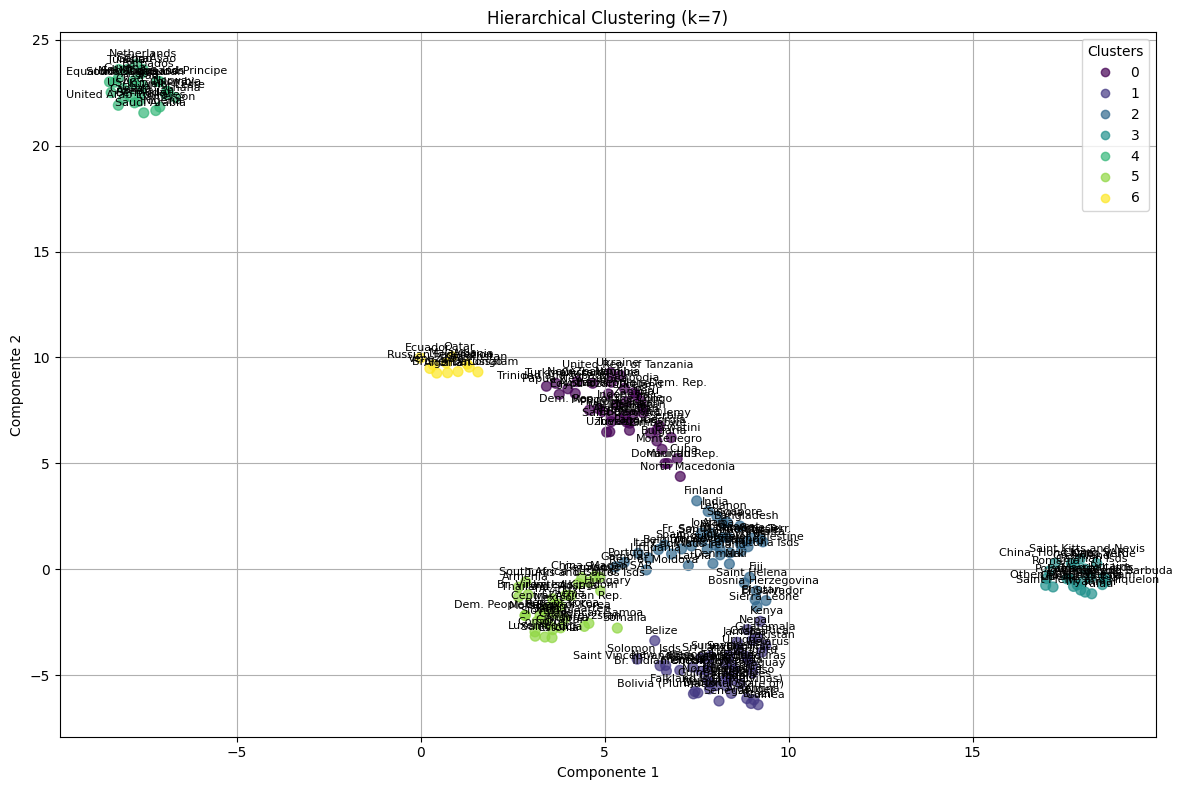

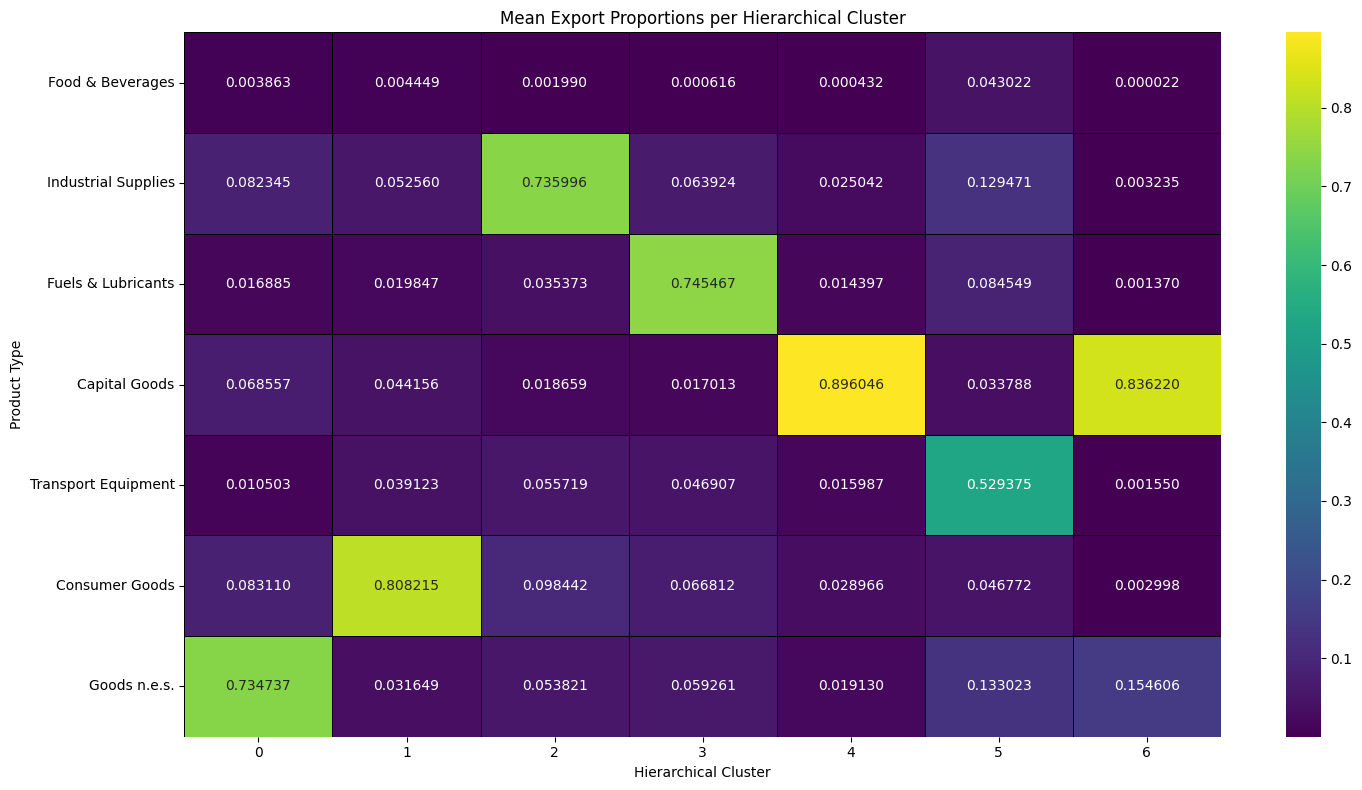

In [148]:
_ = hierarchical_clustering(
        embedding=umap_bec_norm_sz,
        matrix_norm=matrix_norm_bec,
        n_clusters=7
    )

### DBSCAN

In [149]:
def plot_dbscan_clusters(
    embedding,
    matrix_norm,
    eps=0.5,
    min_samples=5,
    metric="euclidean",
    title="DBSCAN Clustering",
    heatmap_figsize=(15, 8),
    save_path=None,
    dpi=300
):

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    clusters = dbscan.fit_predict(embedding)

    df_clusters = matrix_norm.copy()
    df_clusters['Cluster'] = clusters

    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

    cmap = plt.cm.get_cmap("tab10", max(n_clusters, 1))

    fig1, ax1 = plt.subplots(figsize=(12, 8))

    for i, (x, y) in enumerate(embedding):
        cl = clusters[i]
        if cl == -1:
            ax1.scatter(x, y, c="#808080", marker="X", s=80, alpha=0.8)
        else:
            ax1.scatter(x, y, c=[cmap(cl % 10)], s=50, alpha=0.8)

    ax1.set_title(f"{title} (eps={eps}, min_samples={min_samples})")
    ax1.set_xlabel("Componente 1")
    ax1.set_ylabel("Componente 2")
    ax1.grid(True, linestyle="--", alpha=0.5)

    for i, country in enumerate(matrix_norm.index):
        if clusters[i] != -1:
            ax1.annotate(
                country,
                (embedding[i, 0], embedding[i, 1]),
                textcoords="offset points",
                xytext=(4, 4),
                fontsize=8
            )

    legend_elements = []
    for c in unique_clusters:
        if c == -1:
            legend_elements.append(
                plt.Line2D([0], [0], marker="X", linestyle="",
                           color="#808080", label="Noise (-1)", markersize=10)
            )
        else:
            legend_elements.append(
                plt.Line2D([0], [0], marker="o", linestyle="",
                           color=cmap(c % 10), label=f"Cluster {c}", markersize=10)
            )

    ax1.legend(handles=legend_elements, title="Clusters")
    fig1.tight_layout()

    if save_path:
        fig1.savefig(f"{save_path}_embedding.png", dpi=dpi, bbox_inches="tight")

    plt.show()

    cluster_means = (
        df_clusters[df_clusters['Cluster'] != -1]
        .groupby('Cluster')
        .mean(numeric_only=True)
    )

    if cluster_means.empty:
        print("No clusters found (all noise). Heatmap skipped.")
        return clusters, cluster_means

    fig2, ax2 = plt.subplots(figsize=heatmap_figsize)

    sns.heatmap(
        cluster_means.T,
        annot=True,
        fmt=".6f",
        cmap='viridis',
        linewidths=.5,
        linecolor='black',
        ax=ax2
    )

    ax2.set_title("Média de produtos por Cluster DBSCAN (excluindo ruído)")
    ax2.set_xlabel("Cluster")
    ax2.set_ylabel("Produto")
    fig2.tight_layout()

    if save_path:
        fig2.savefig(f"{save_path}_heatmap.png", dpi=dpi, bbox_inches="tight")

    plt.show()

    return clusters, cluster_means


C:\Users\Gusto\AppData\Local\Temp\ipykernel_12636\2245205419.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(n_clusters, 1))


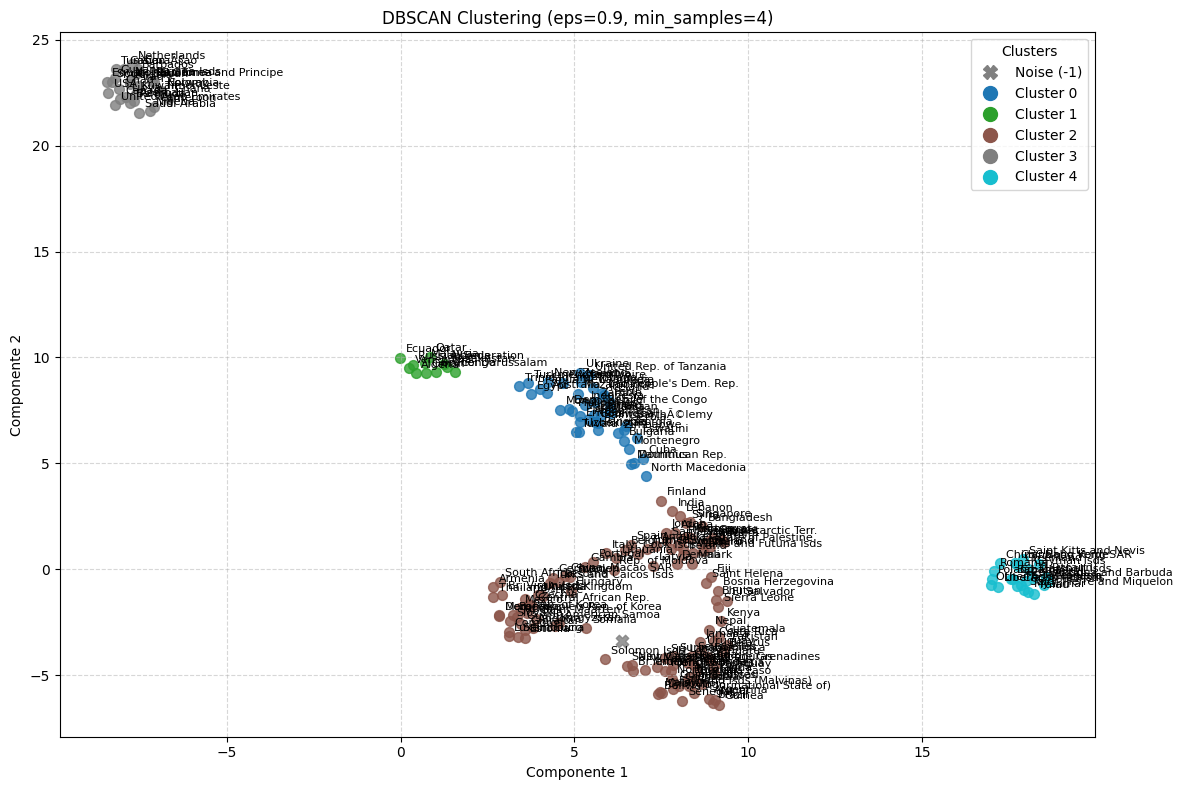

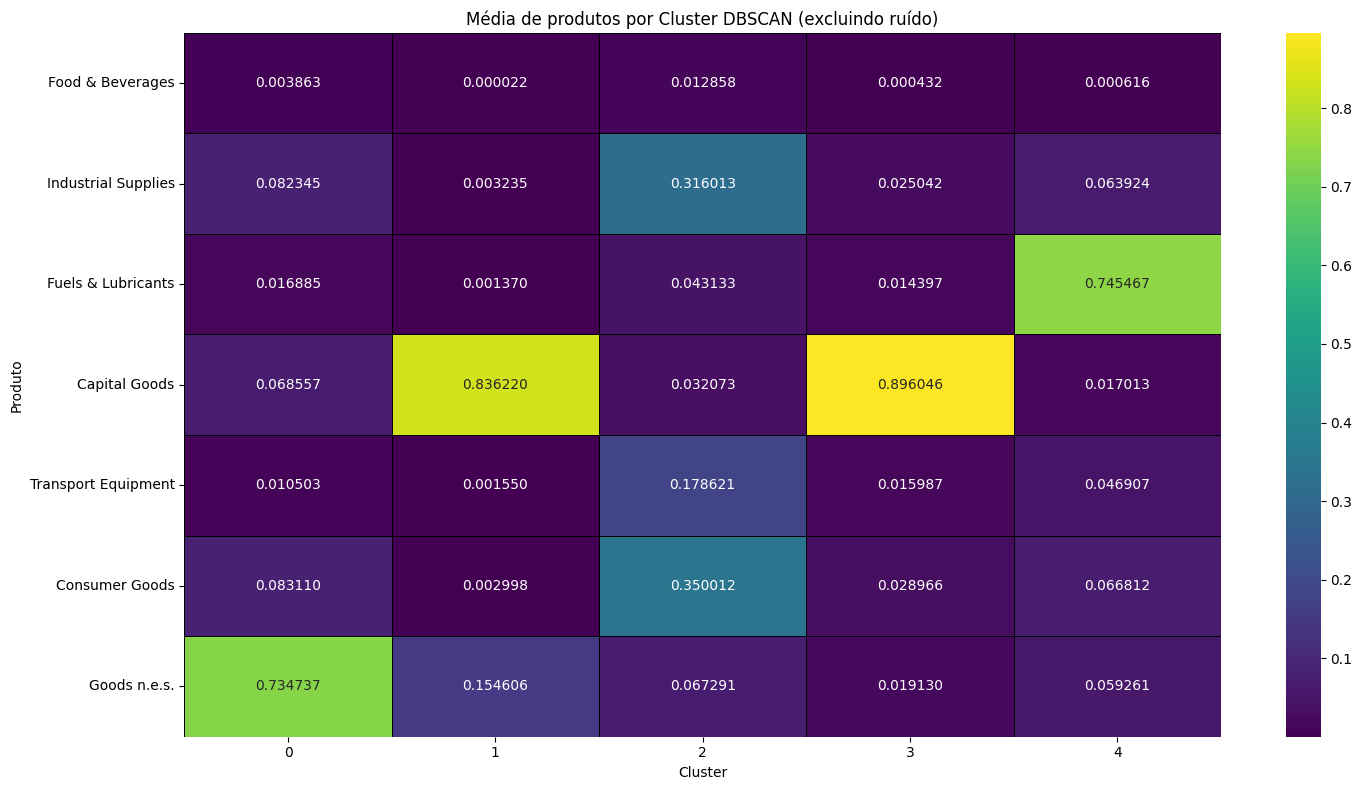

In [150]:
_ = plot_dbscan_clusters(
    embedding=umap_bec_norm_sz,
    matrix_norm=matrix_norm_bec,
    eps=0.9,
    min_samples=4
)

## Resultados

Depois de diversas tentativas de clusterizações, foram separadas as que foram consideradas ideais, tendo em vista a visualização gráfica e a divisão de produtos que cada cluster tentava representar

### HS2

No agrupamento pela HS2, a melhor combinação entre redução de dimensionalidade e clusterização foi a representada a seguir:

C:\Users\Gusto\AppData\Local\Temp\ipykernel_12636\2245205419.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(n_clusters, 1))


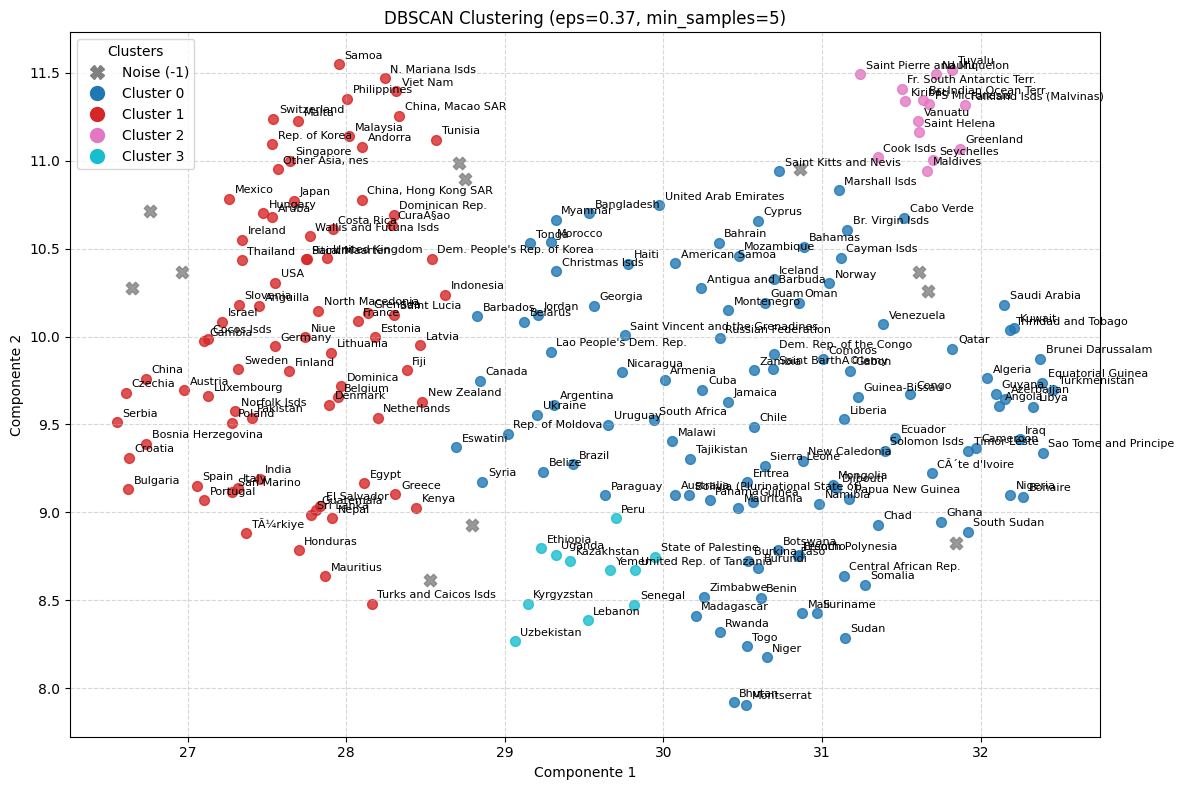

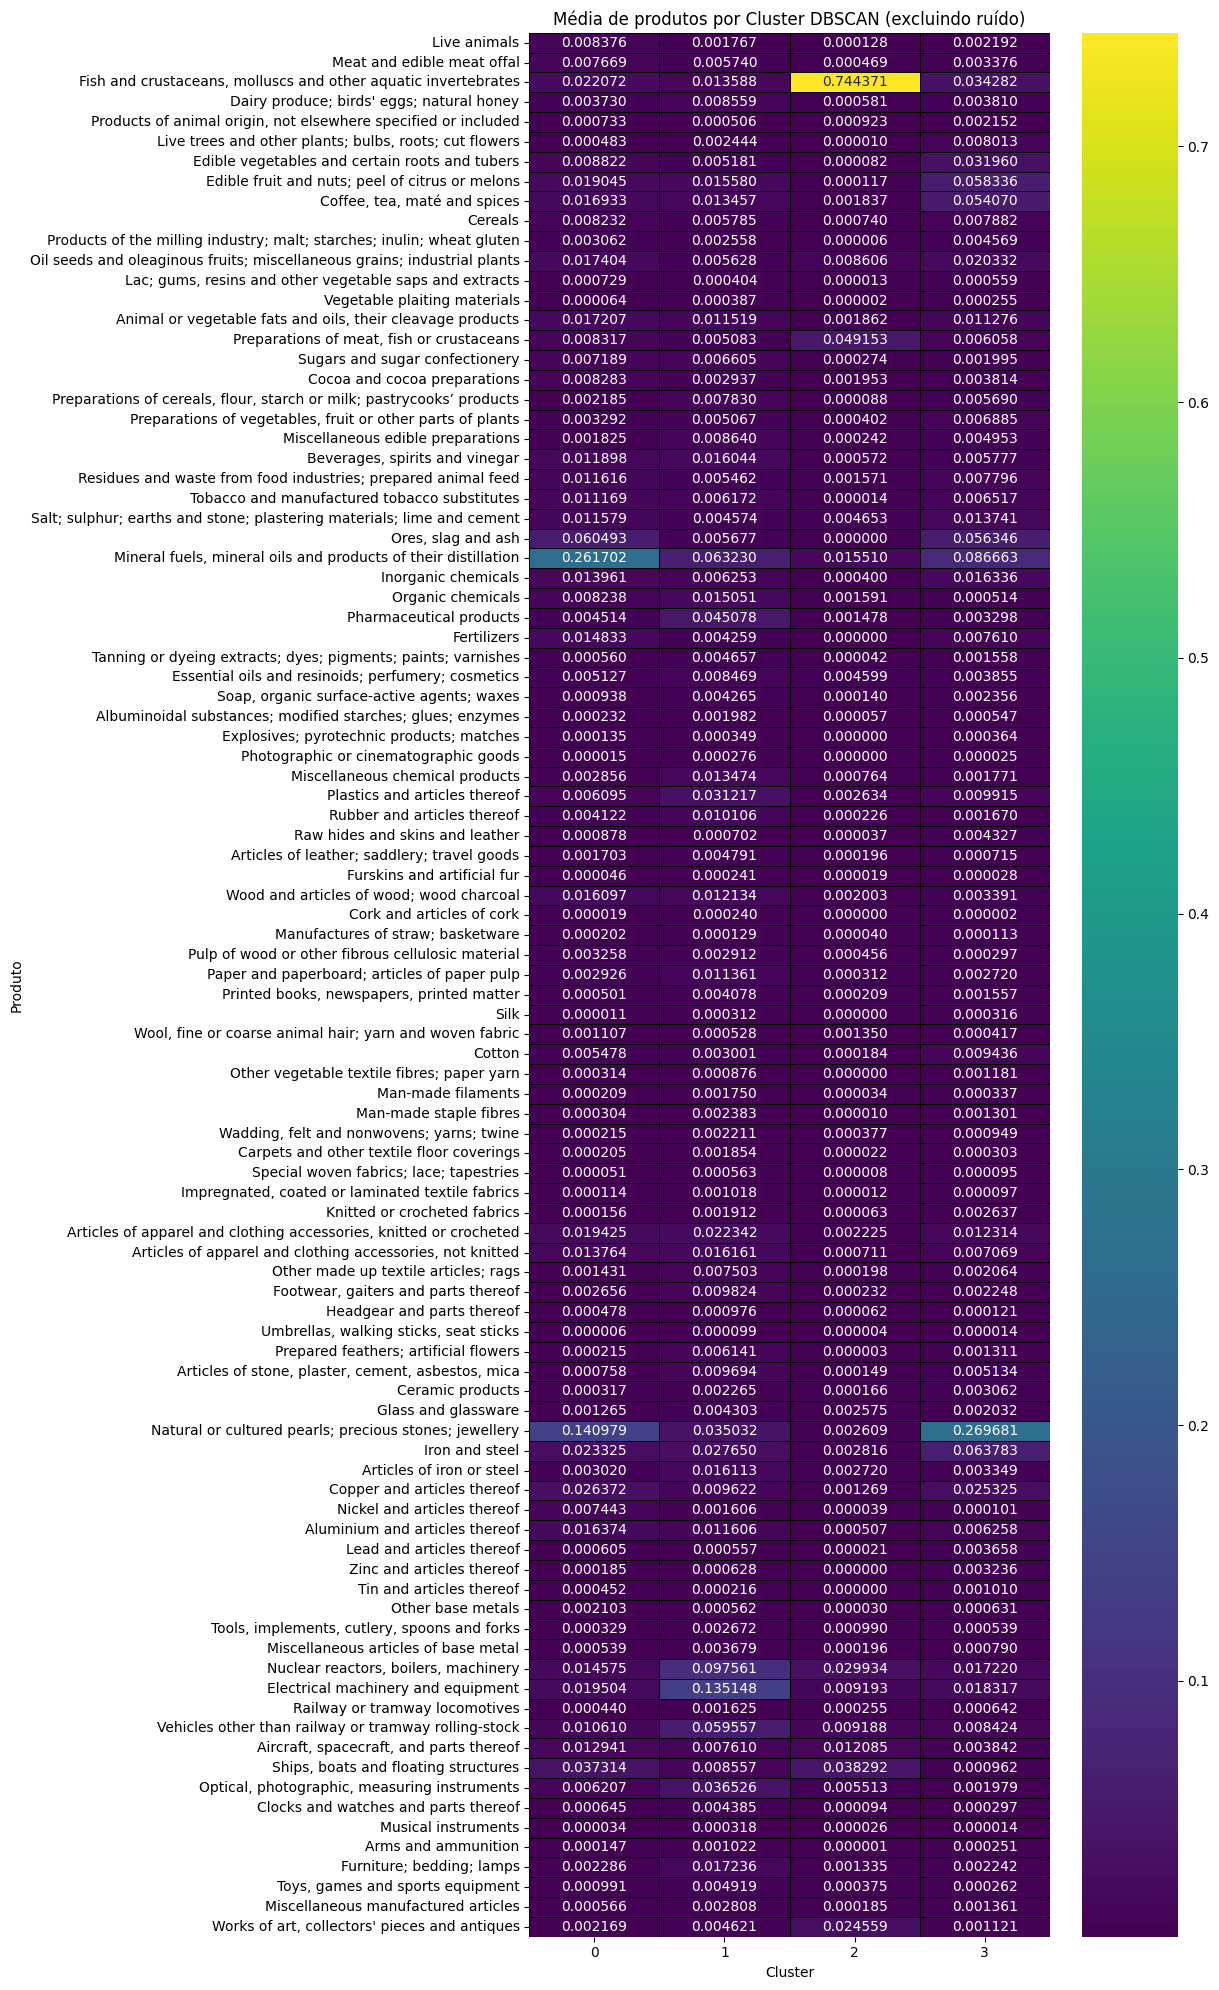

In [151]:
umap_hs2_dbscan_clusters, _ = plot_dbscan_clusters(
    embedding=umap__hs2[0],
    matrix_norm=matrix_norm_hs2,
    #eps=0.42,
    eps=0.37,
    min_samples=5,
    heatmap_figsize=(12,20), 
    save_path=img_path+"hs2_umap_dbscan"
)

Foram achados 4 clusters, dois gigantes e dois menores:

- Cluster 0, o maior de todos, se destacou na categoria de combustíveis minerais, oléos minerais, produtos destilados; pérolas, pedras preciosas e joalheria.
- Cluster 1, o segundo maior, tem sua principal classificação maquinário elétrico e equipamentos; reatores nucleares, boilers.
- Cluster 2 tem como principais produtos peixes, crustáceos, moluscos e invertebrados aquáticos, além do preparo dos mesmos.
- Cluster 3 se destaca com a importação de navios, barcos e estruturas flutuantes; aeronaves, espaçonaves e suas partes.

### BEC

No agrupamento utilizando a BEC1, foram escolhidas algumas clusterizações consideradas mais ideais, porém, ao longo da análise apenas uma será levada em consideração para deixa-la mais dinâmica e otimizada.

t-SNE + DBSCAN:

C:\Users\Gusto\AppData\Local\Temp\ipykernel_12636\2245205419.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(n_clusters, 1))


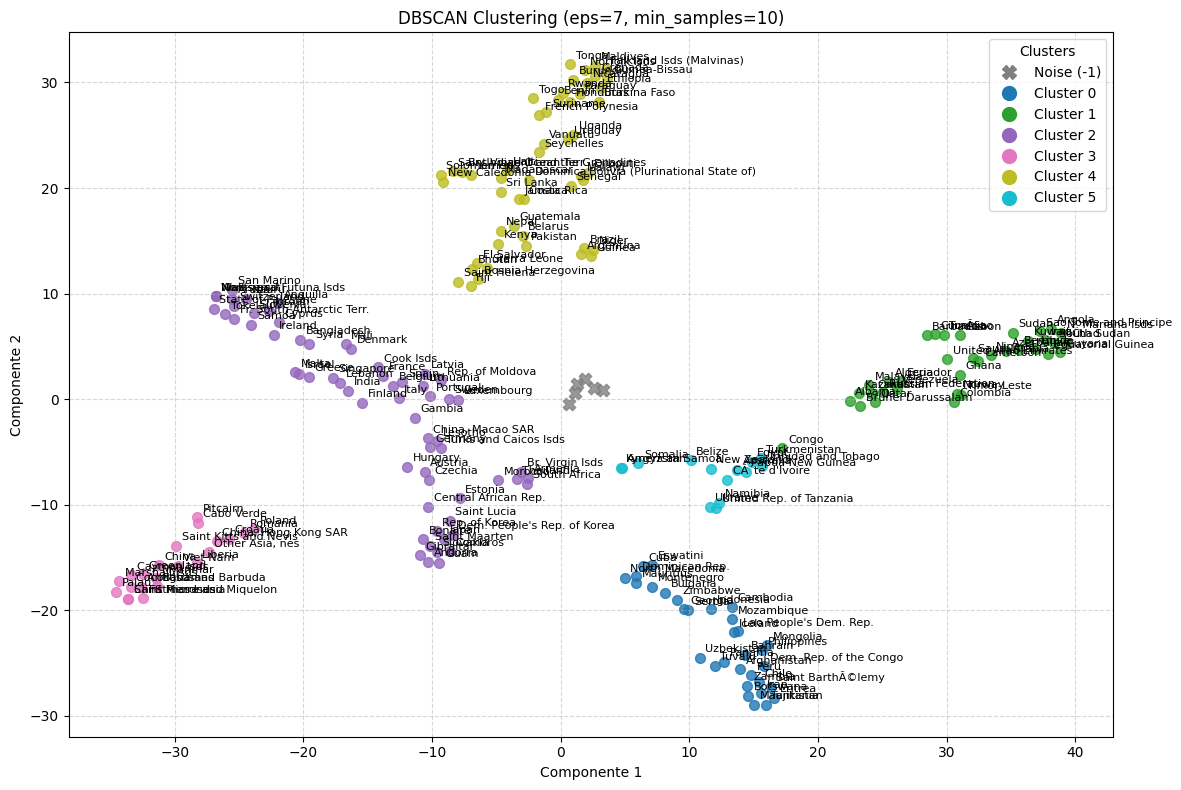

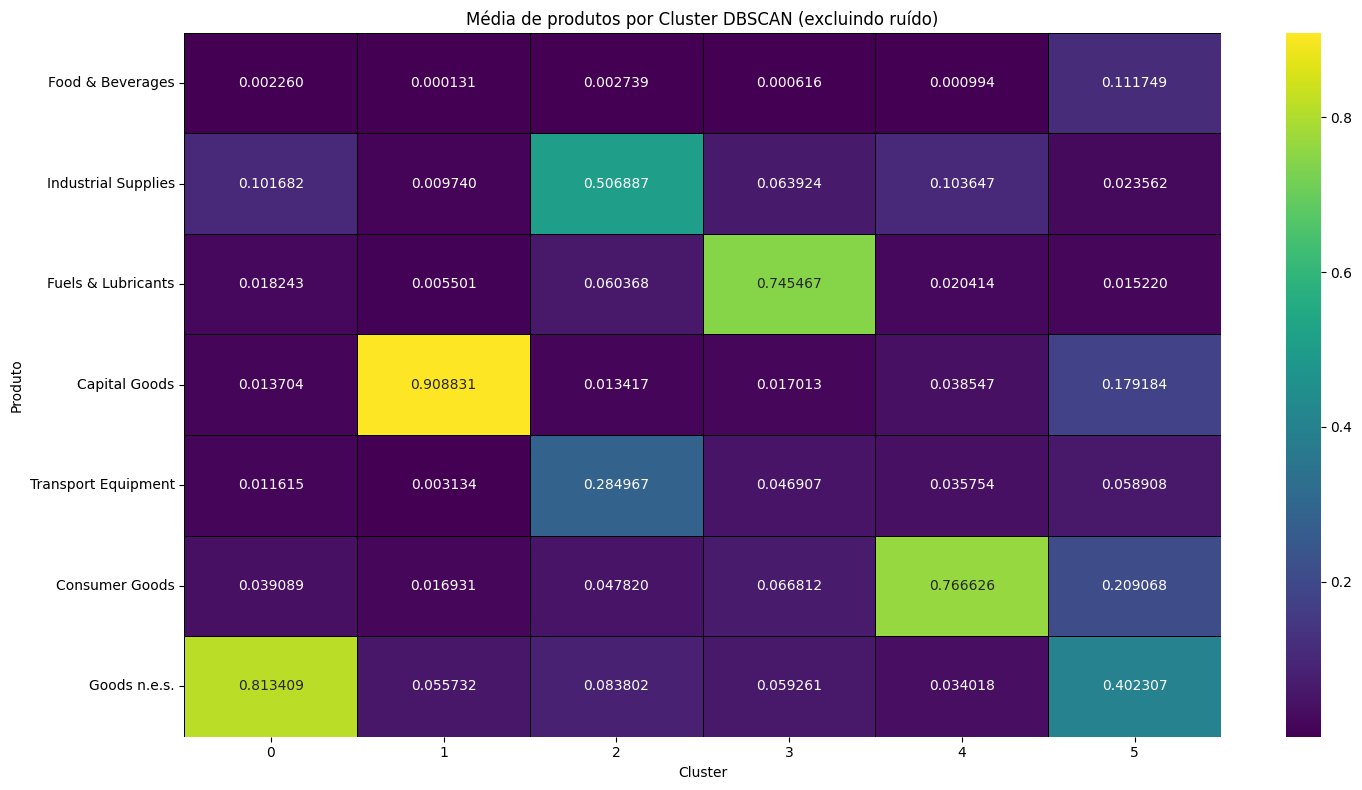

In [152]:
tsne_bec_norm_dbscan_clusters = plot_dbscan_clusters(
    embedding=tsne_result_bec_norm,
    matrix_norm=matrix_norm_bec,
    min_samples=10,
    eps=7, 
    save_path=img_path+"bec_tsne_dbscan"
)

UMAP + DBSCAN:

C:\Users\Gusto\AppData\Local\Temp\ipykernel_12636\2956179305.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", n_clusters)


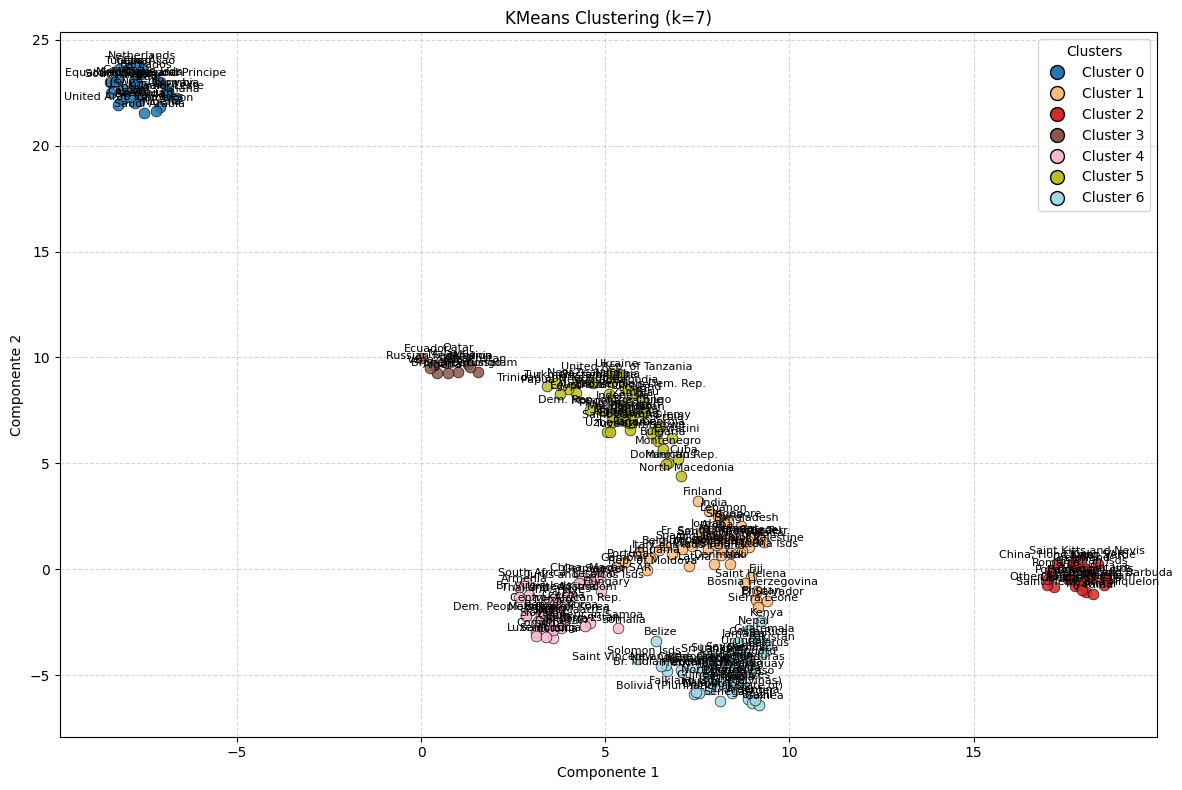

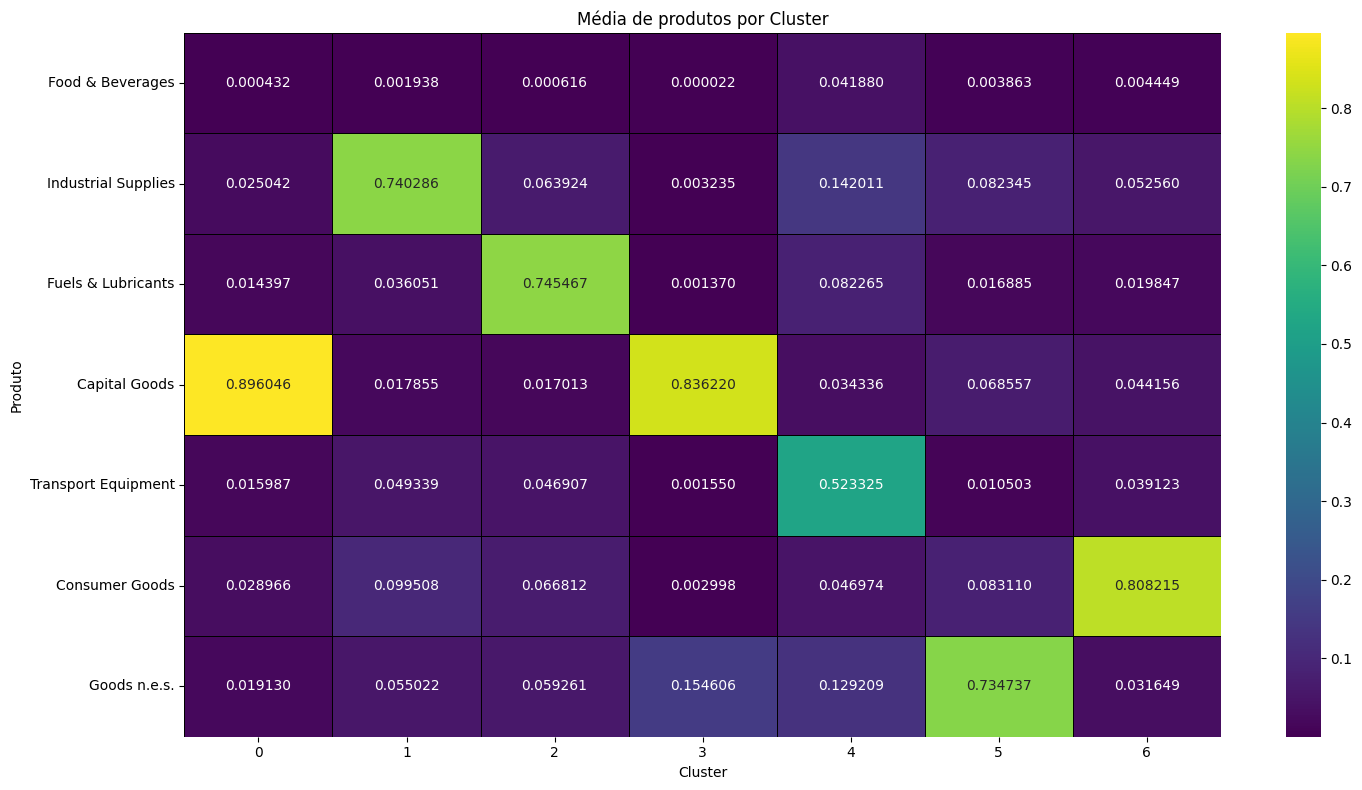

In [153]:
kmeans_umap_bec_sz, _ = plot_kmeans_clusters(
    embedding=umap_bec_norm_sz,
    matrix_norm=matrix_norm_bec,
    n_clusters=7, 
    save_path=img_path+"bec_umap_kmeans"
)

## Análise

Com os clusters formados, foram as análises, para isso foram utilizados como meios de comparação os agrupamentos da HS2 e o BEC1 na qual os clusters dominaram um tipo de produto nas exportações.

### Top 5 países  por exportações

In [154]:
total_exports_by_country_bec = matrix_bec.sum(axis=1)
top_5_countries_bec = total_exports_by_country_bec.nlargest(5).index.tolist()

print("Top 5 países por número de exportações:")
print(total_exports_by_country_bec.nlargest(5).head())

Top 5 países por número de exportações:
exporter
USA                   2.572959e+08
Saudi Arabia          1.818802e+08
Canada                1.634819e+08
China                 1.569866e+08
Russian Federation    1.401650e+08
dtype: float64


In [155]:
total_exports_by_country_hs2 = matrix_hs2.sum(axis=1)
top_5_countries_hs2 = total_exports_by_country_hs2.nlargest(5).index.tolist()

print("Top 5 países por número de exportações:")
print(total_exports_by_country_hs2.nlargest(5).head())

Top 5 países por número de exportações:
i
China      3.411039e+09
USA        1.895702e+09
Germany    1.621343e+09
Japan      7.284188e+08
Italy      6.535465e+08
dtype: float64


In [156]:
total_exports_hs2_dataset = matrix_hs2.sum().sum()
total_exports_bec_dataset = matrix_bec.sum().sum()

print(f"Total de exportações no dataset HS2: ${total_exports_hs2_dataset:,.2f}")
print(f"Total de exportações no dataset BEC: ${total_exports_bec_dataset:,.2f}")

if total_exports_hs2_dataset > total_exports_bec_dataset:
    difference = total_exports_hs2_dataset - total_exports_bec_dataset
    print(f"\nA diferença é de ${difference:,.2f} no dataset HS2.")
else:
    difference = total_exports_bec_dataset - total_exports_hs2_dataset
    print(f"\nA diferença é de ${difference:,.2f} no dataset BEC.")

Total de exportações no dataset HS2: $22,544,631,728.63
Total de exportações no dataset BEC: $2,775,188,638.96

A diferença é de $19,769,443,089.67 no dataset HS2.


A diferença se deve à forma como o dataset `matrix_bec` foi construído. Ao fazer o merge com o arquivo `bec_map.csv`, que mapeia os códigos HS6 para as categorias BEC, algumas linhas (produtos) do dataset original podem não ter encontrado uma correspondência na coluna `bec`. Quando o agrupamento para `matrix_bec` é feito (especificamente `baci.groupby(["exporter", "bec"])`), as linhas onde a categoria `bec` é `NaN` (ou seja, produtos sem mapeamento BEC) são automaticamente excluídas da soma. Isso significa que nem todos os valores de exportação presentes no dataset original (e, consequentemente, em `matrix_hs2`) são considerados na `matrix_bec`.

Entretanto, para `matrix_hs2`, todos os produtos do dataset original (`BACI_HS22_Y2023_V202501.csv`) foram utilizados, pois a categorização HS2 foi gerada diretamente dos códigos HS6 existentes, garantindo que nenhum valor de exportação fosse perdido por falta de mapeamento.

---

A seguir os plots dos top 5 países nos seus clusters:

In [157]:
def plot_clusters_generic(
    embedding,
    clusters,
    matrix_norm,
    matrix_original,
    title="Cluster Visualization",
    top_countries=None,
    heatmap_figsize=(15, 8),
    save_path=None,
    dpi=300
):

    df_norm = matrix_norm.copy()
    df_norm["Cluster"] = clusters

    df_orig = matrix_original.copy()
    df_orig["Cluster"] = clusters

    unique_clusters = sorted(np.unique(clusters))
    cmap = plt.colormaps["tab20"]

    fig1, ax1 = plt.subplots(figsize=(14, 10))

    for i, (x, y) in enumerate(embedding):
        country = matrix_norm.index[i]
        cl = clusters[i]

        if top_countries and country in top_countries:
            ax1.scatter(
                x, y,
                c="red",
                marker="s",
                s=200,
                edgecolor="black",
                linewidth=1.2,
                zorder=5
            )
            ax1.annotate(
                country,
                (x, y),
                textcoords="offset points",
                xytext=(7, 7),
                fontsize=10,
                ha="center",
                fontweight="bold"
            )

        elif cl == -1:
            ax1.scatter(
                x, y,
                c="#555555",
                marker="X",
                s=100,
                alpha=0.9,
                zorder=3
            )
        else:
            ax1.scatter(
                x, y,
                c=[cmap(cl % 20)],
                marker="o",
                s=70,
                alpha=0.8,
                zorder=2
            )

    ax1.set_title(title, fontsize=14, fontweight="bold")
    ax1.set_xlabel("Componente 1")
    ax1.set_ylabel("Componente 2")
    ax1.grid(True, linestyle="--", alpha=0.4)

    legend_items = []

    if top_countries:
        legend_items.append(
            plt.Line2D(
                [0], [0],
                marker="s",
                color="w",
                markerfacecolor="red",
                markeredgecolor="black",
                markersize=12,
                label="Top países"
            )
        )

    for cl in unique_clusters:
        if cl == -1:
            legend_items.append(
                plt.Line2D(
                    [0], [0],
                    marker="X",
                    color="w",
                    markerfacecolor="#555555",
                    markersize=10,
                    label="Noise (-1)"
                )
            )
        else:
            legend_items.append(
                plt.Line2D(
                    [0], [0],
                    marker="o",
                    color="w",
                    markerfacecolor=cmap(cl % 20),
                    markersize=10,
                    label=f"Cluster {cl}"
                )
            )

    ax1.legend(handles=legend_items, title="Clusters")
    fig1.tight_layout()

    if save_path:
        fig1.savefig(f"{save_path}_embedding.png", dpi=dpi, bbox_inches="tight")

    plt.show()

    cluster_means = (
        df_orig[df_orig["Cluster"] != -1]
        .groupby("Cluster")
        .mean(numeric_only=True)
    )

    if cluster_means.empty:
        print("Todos os pontos são noise, heatmap ignorado.")
        return clusters, None

    fig2, ax2 = plt.subplots(figsize=heatmap_figsize)

    sns.heatmap(
        cluster_means.T,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        linewidths=.5,
        linecolor="black",
        ax=ax2
    )

    ax2.set_title(
        "Média de produtos por Cluster (excluindo noise)",
        fontsize=14
    )
    ax2.set_xlabel("Cluster")
    ax2.set_ylabel("Produto")
    fig2.tight_layout()

    if save_path:
        fig2.savefig(f"{save_path}_heatmap.png", dpi=dpi, bbox_inches="tight")

    plt.show()

    return clusters, cluster_means


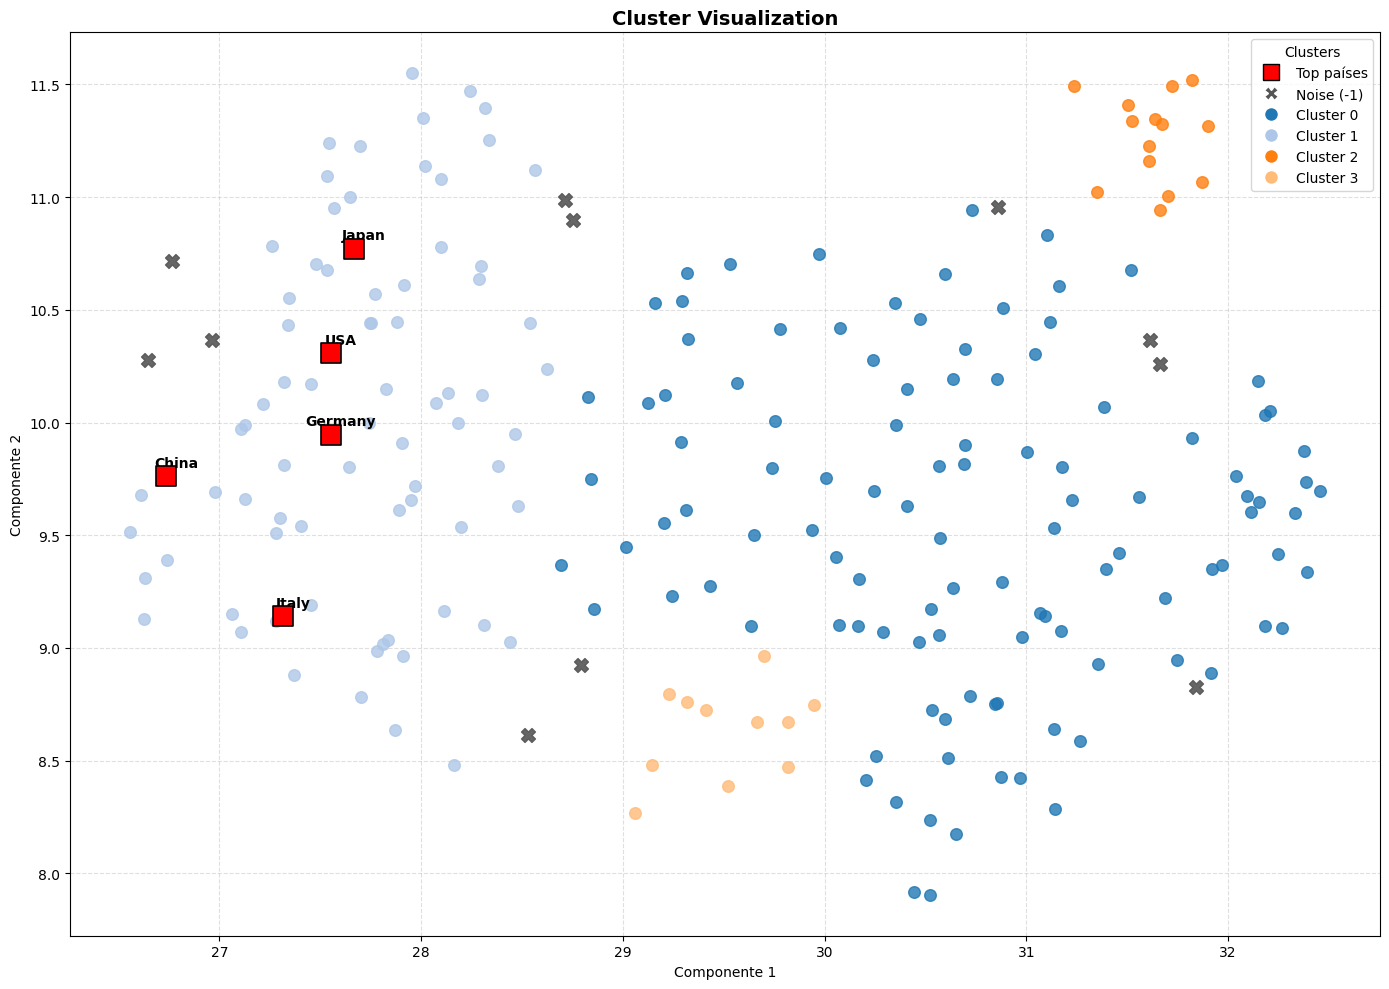

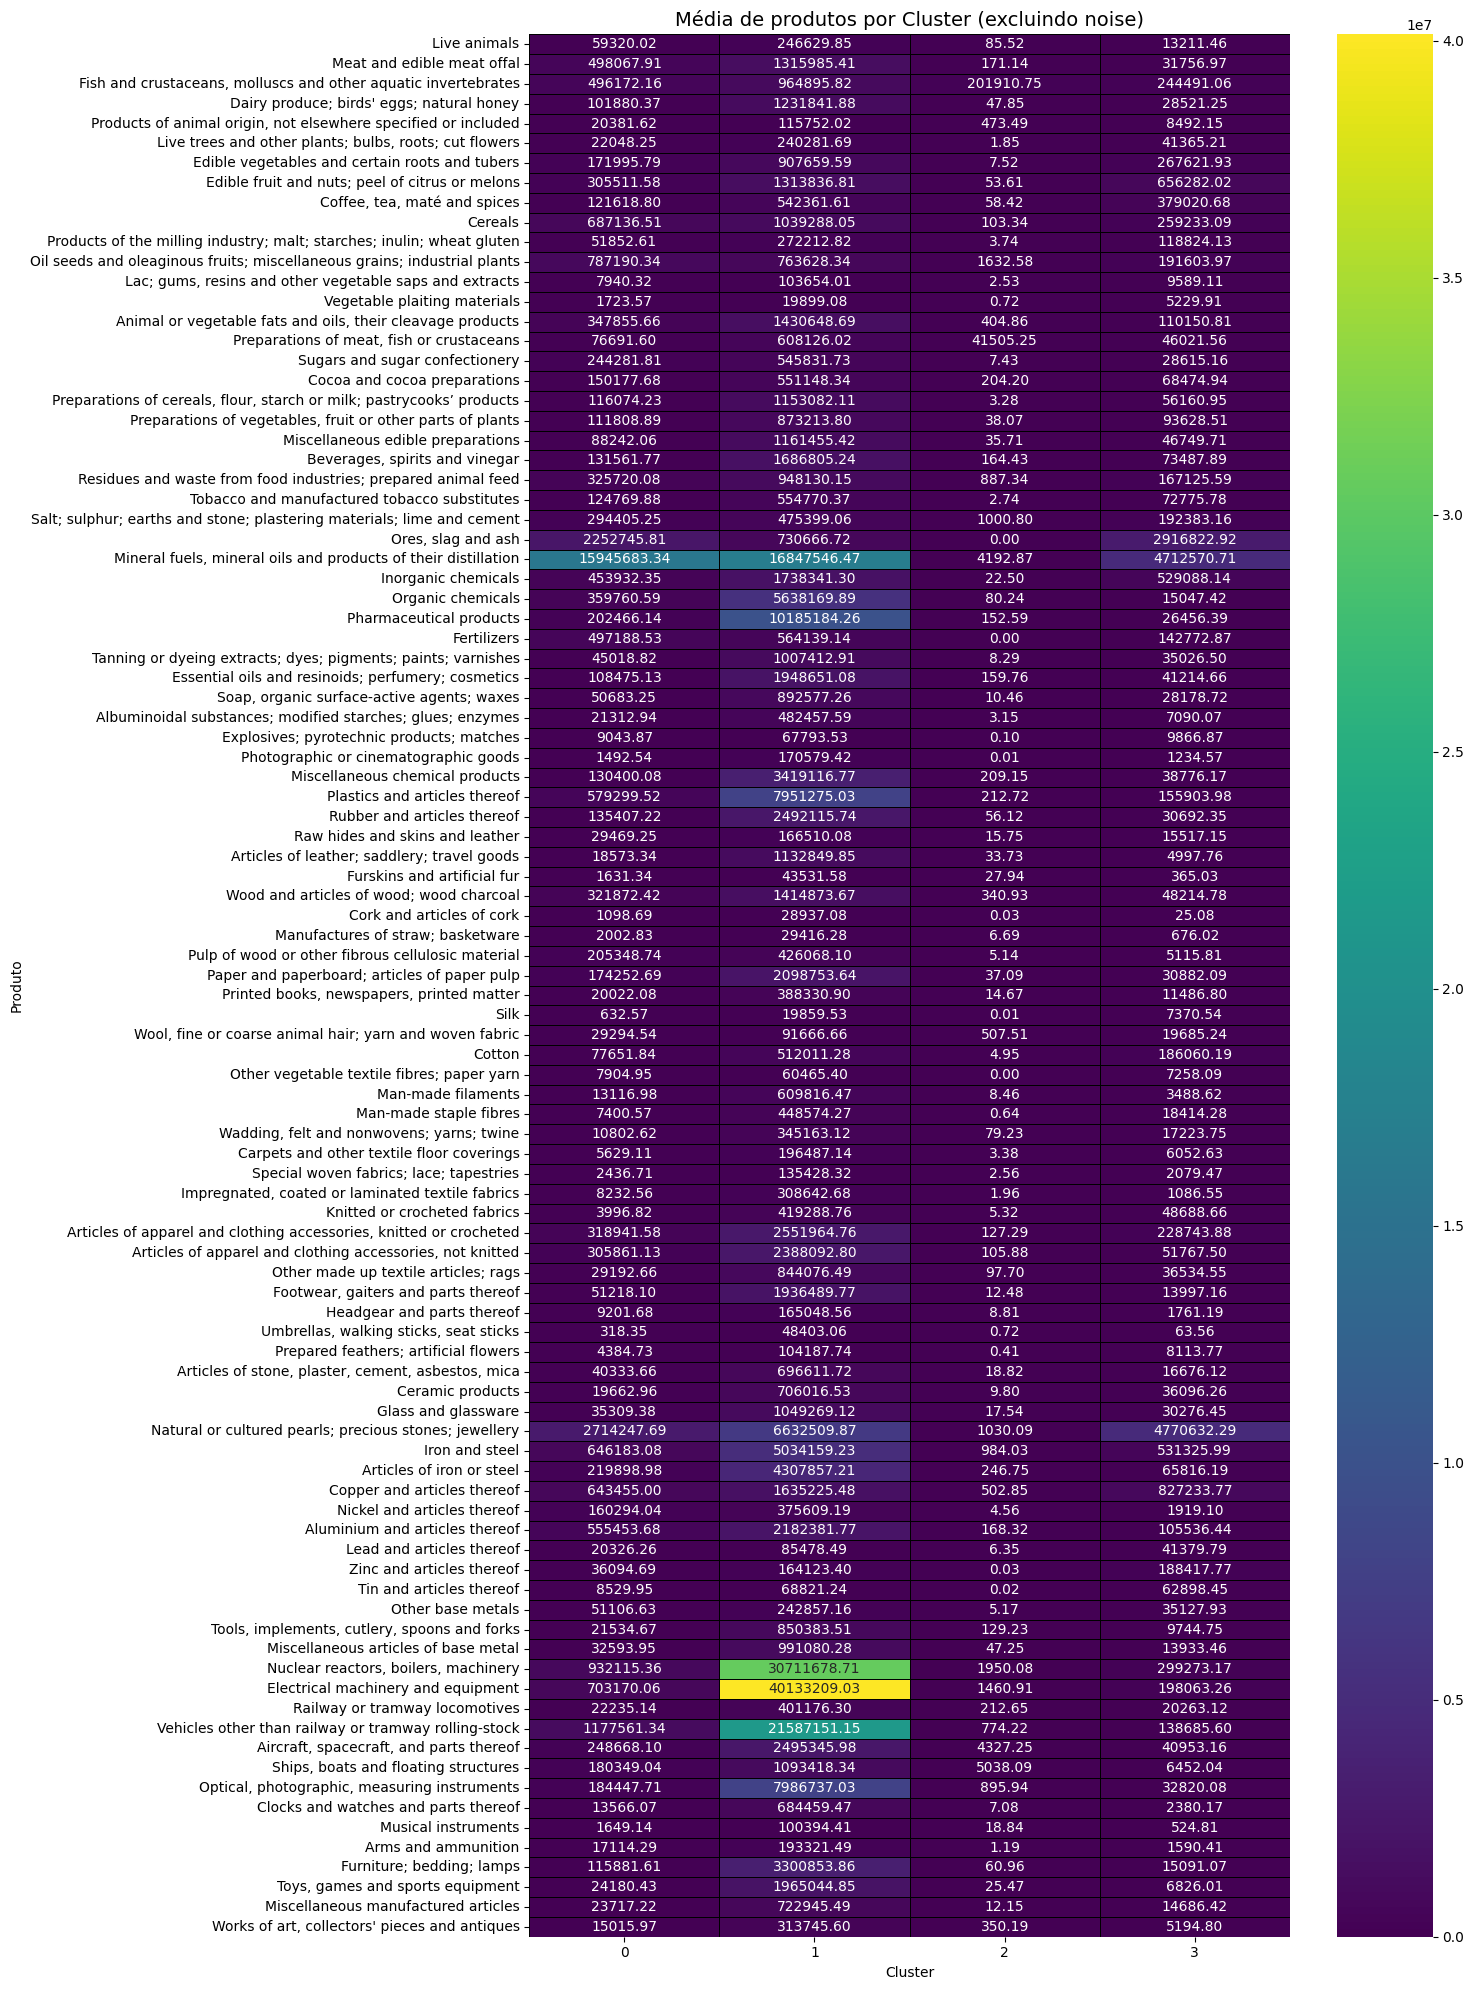

In [158]:
_ = plot_clusters_generic(
    embedding=umap__hs2[0],
    clusters=umap_hs2_dbscan_clusters,
    matrix_norm=matrix_norm_hs2,
    matrix_original=matrix_hs2,
    top_countries=top_5_countries_hs2,
    heatmap_figsize=(15, 20), 
    save_path=img_path+"hs2_umap_dbscan_top5"
)

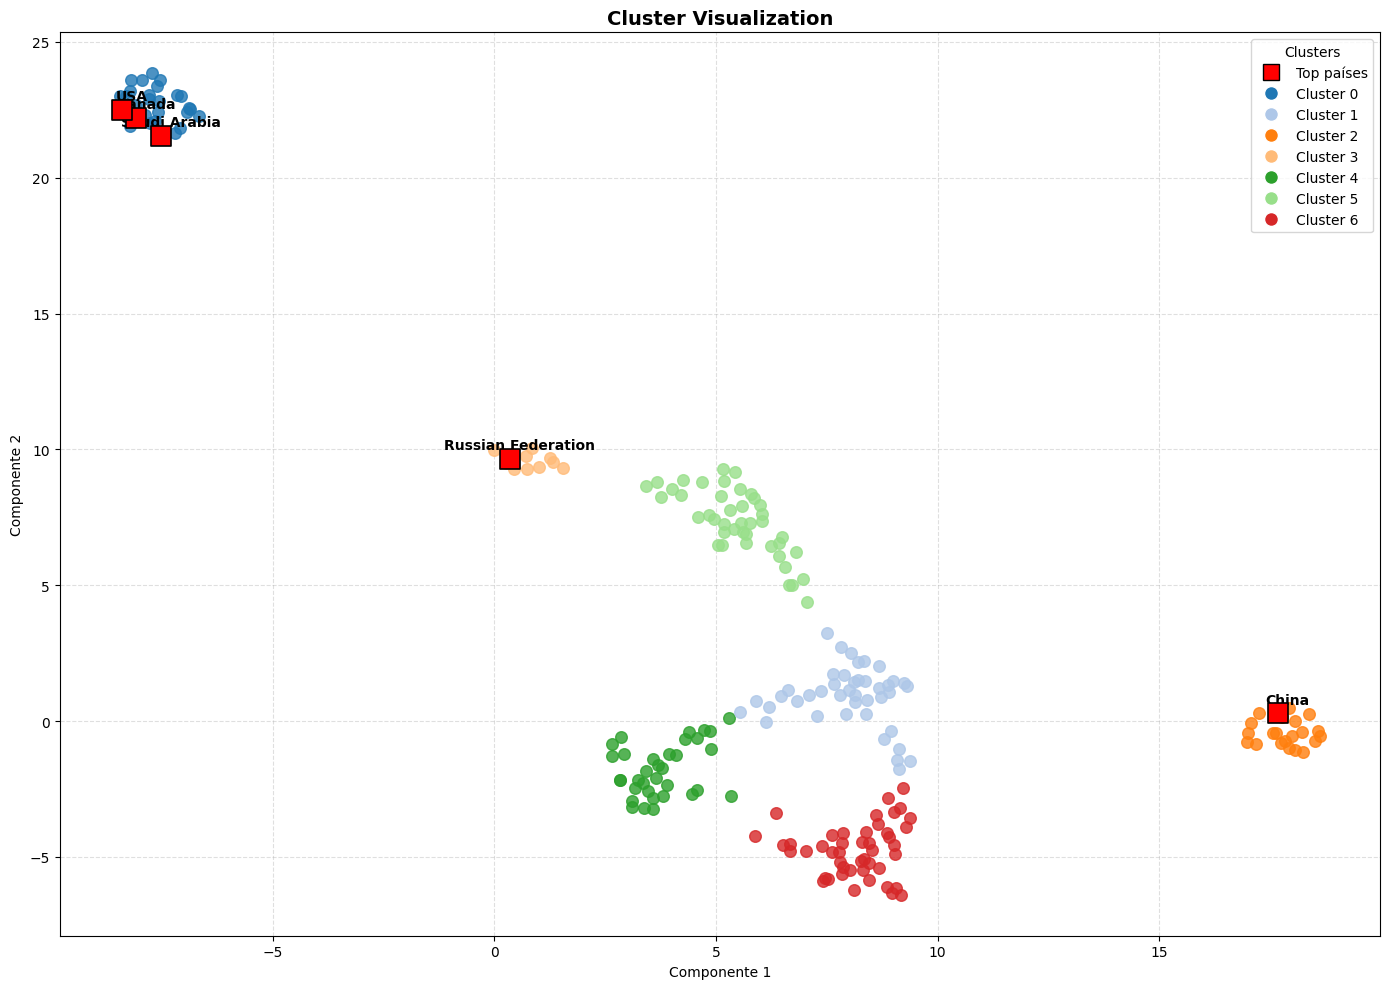

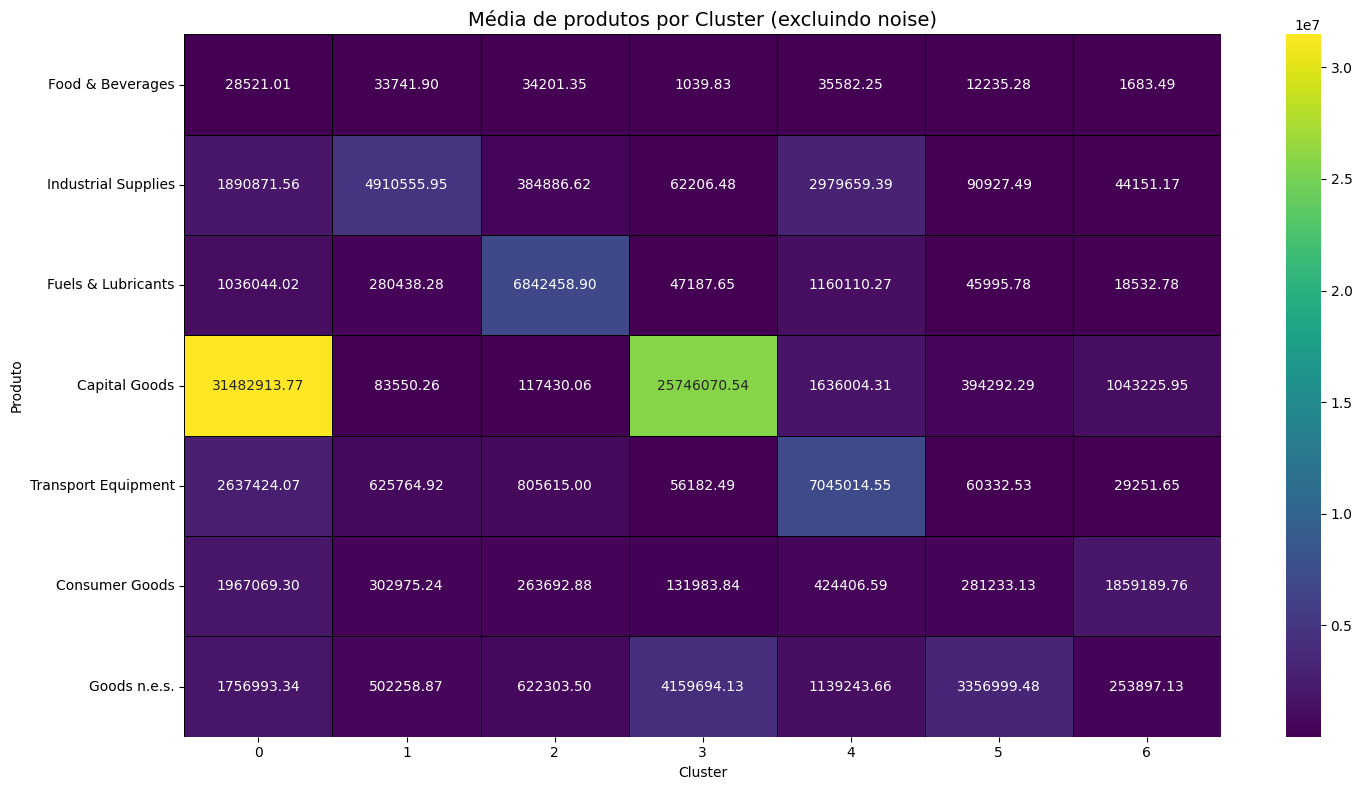

In [159]:
_ = plot_clusters_generic(
    embedding=umap_bec_norm_sz,
    clusters=kmeans_umap_bec_sz,
    matrix_norm=matrix_norm_bec,
    matrix_original=matrix_bec,
    top_countries=top_5_countries_bec,
    heatmap_figsize=(15, 8), 
    save_path=img_path+"bec_umap_kmeans_top5"
)

### Top 20 países por exportações

In [160]:
top_20_countries_bec = total_exports_by_country_bec.nlargest(20).index.tolist()

print(f"\nTop 5 economic powers (based on total export value):\n{top_20_countries_bec}")


Top 5 economic powers (based on total export value):
['USA', 'Saudi Arabia', 'Canada', 'China', 'Russian Federation', 'Germany', 'Brazil', 'United Arab Emirates', 'Iraq', 'Mexico', 'Japan', 'Norway', 'Netherlands', 'United Kingdom', 'Nigeria', 'Kazakhstan', 'Italy', 'Chile', 'Malaysia', 'Switzerland']


In [161]:
top_20_countries_hs2 = total_exports_by_country_hs2.nlargest(20).index.tolist()

print(f"\nTop 5 economic powers (based on total export value):\n{top_20_countries_hs2}")


Top 5 economic powers (based on total export value):
['China', 'USA', 'Germany', 'Japan', 'Italy', 'France', 'Netherlands', 'Rep. of Korea', 'Mexico', 'Canada', 'India', 'United Kingdom', 'Other Asia, nes', 'Belgium', 'Viet Nam', 'Spain', 'Russian Federation', 'Switzerland', 'Australia', 'Malaysia']


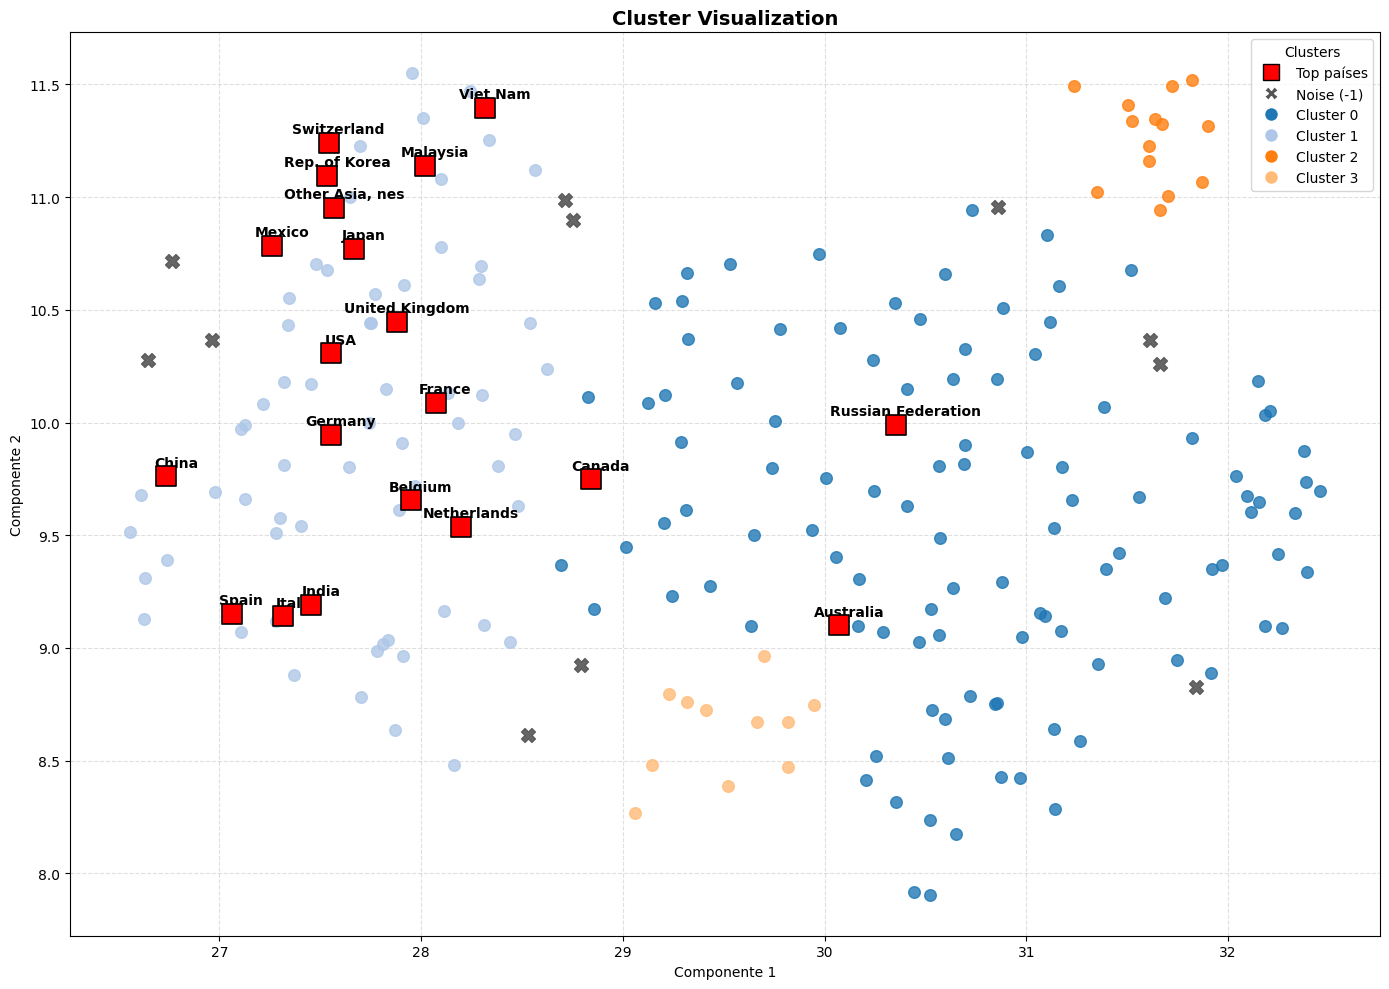

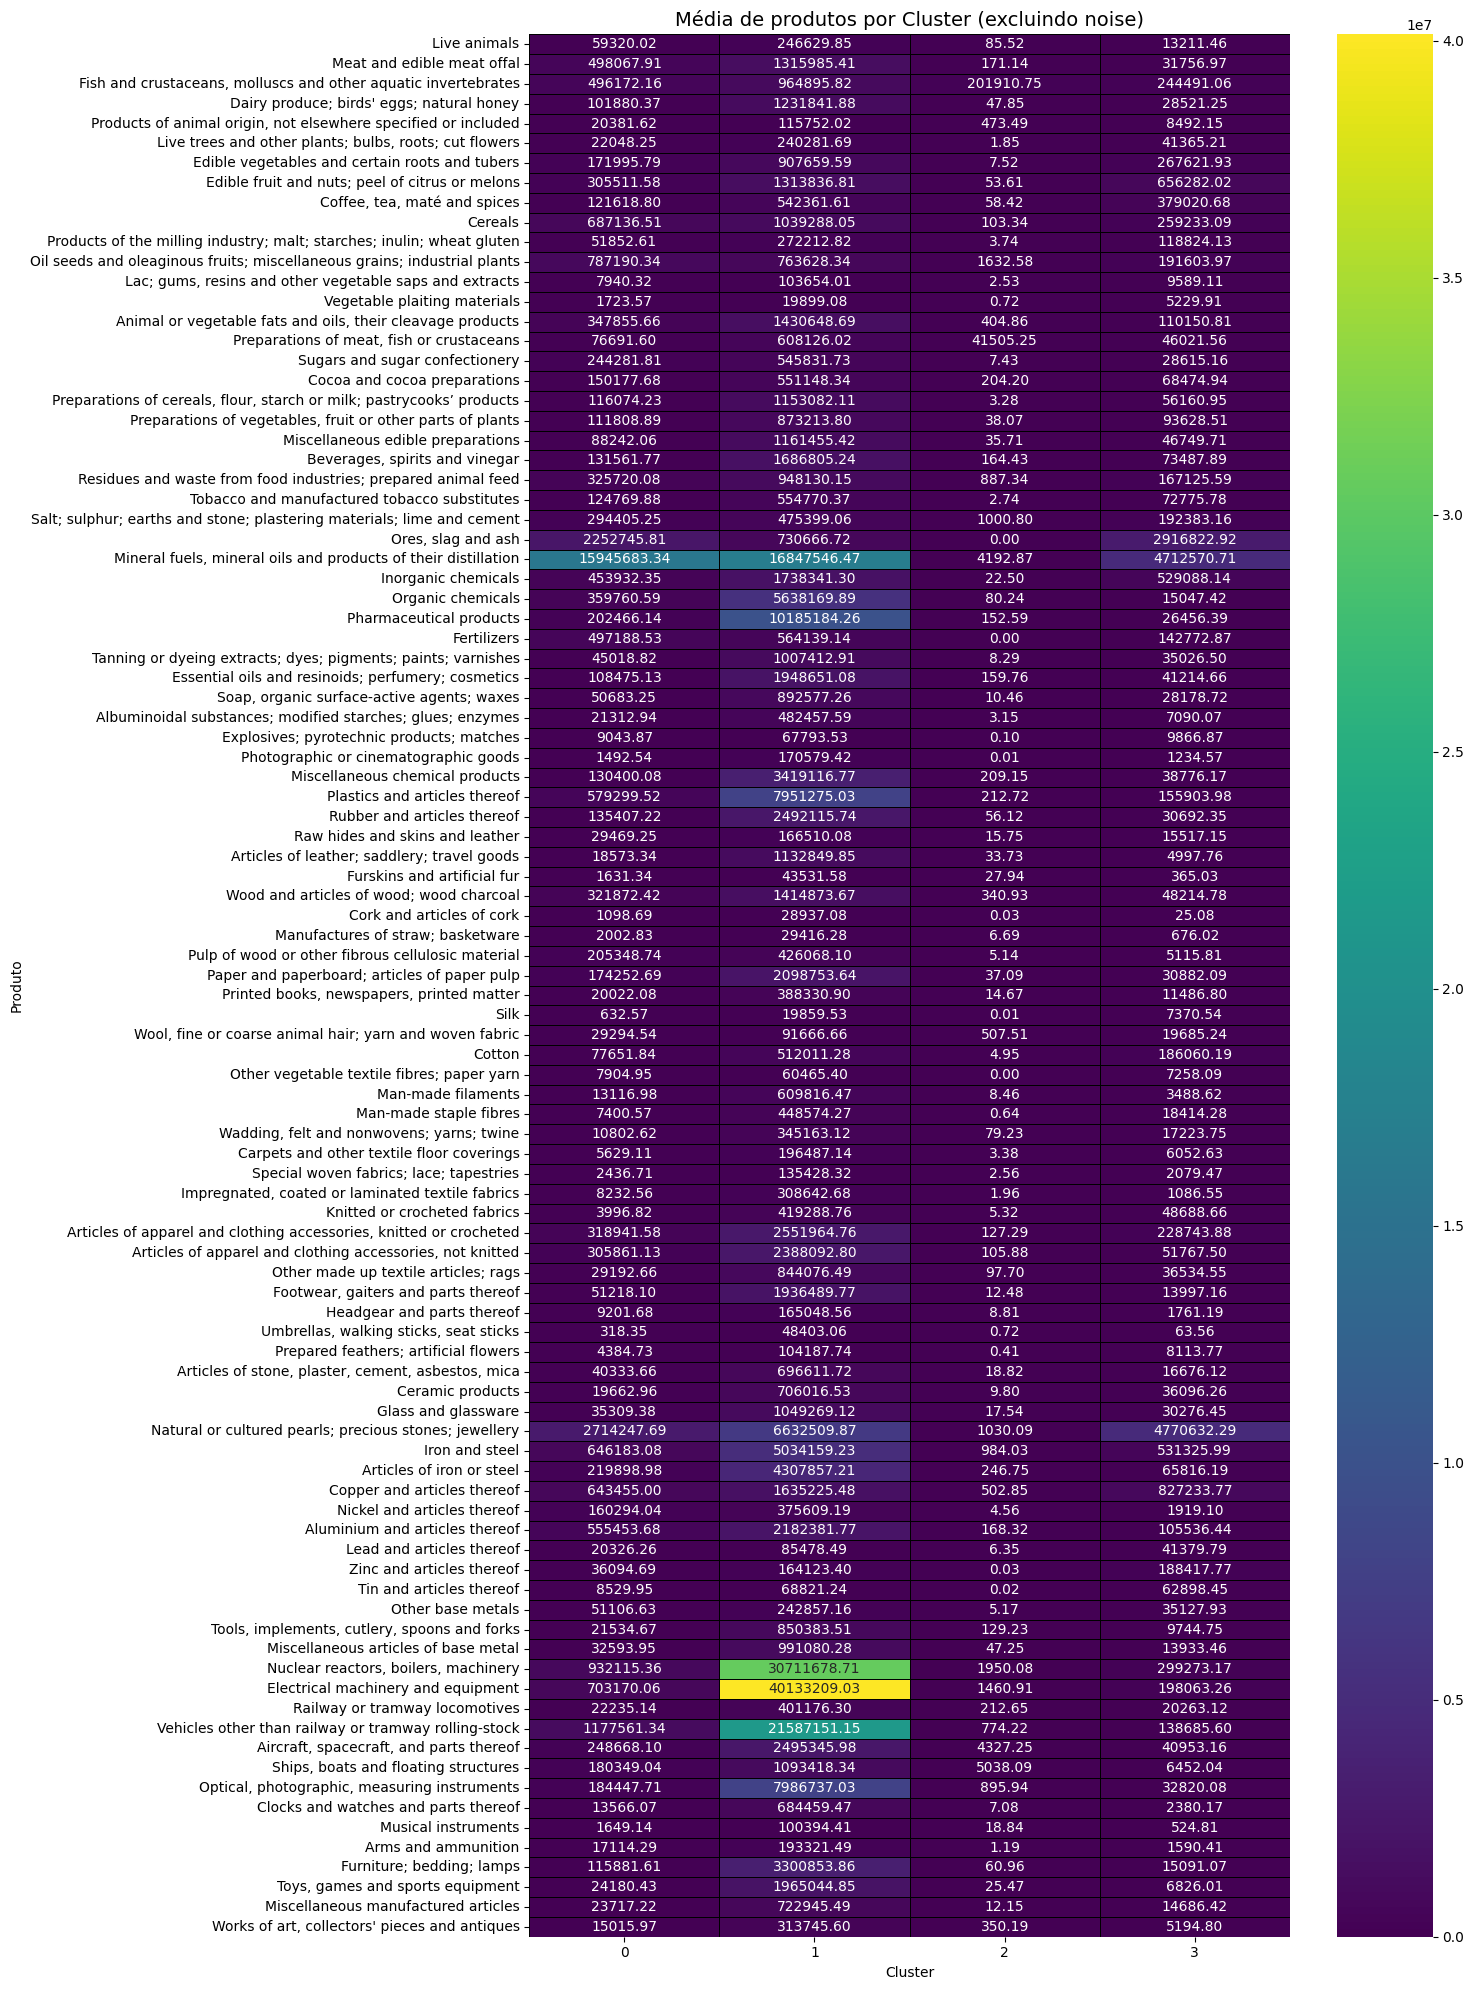

In [162]:
_ = plot_clusters_generic(
    embedding=umap__hs2[0],
    clusters=umap_hs2_dbscan_clusters,
    matrix_norm=matrix_norm_hs2,
    matrix_original=matrix_hs2,
    top_countries=top_20_countries_hs2,
    heatmap_figsize=(15, 20), 
    save_path=img_path+"hs2_umap_dbscan_top20"
)

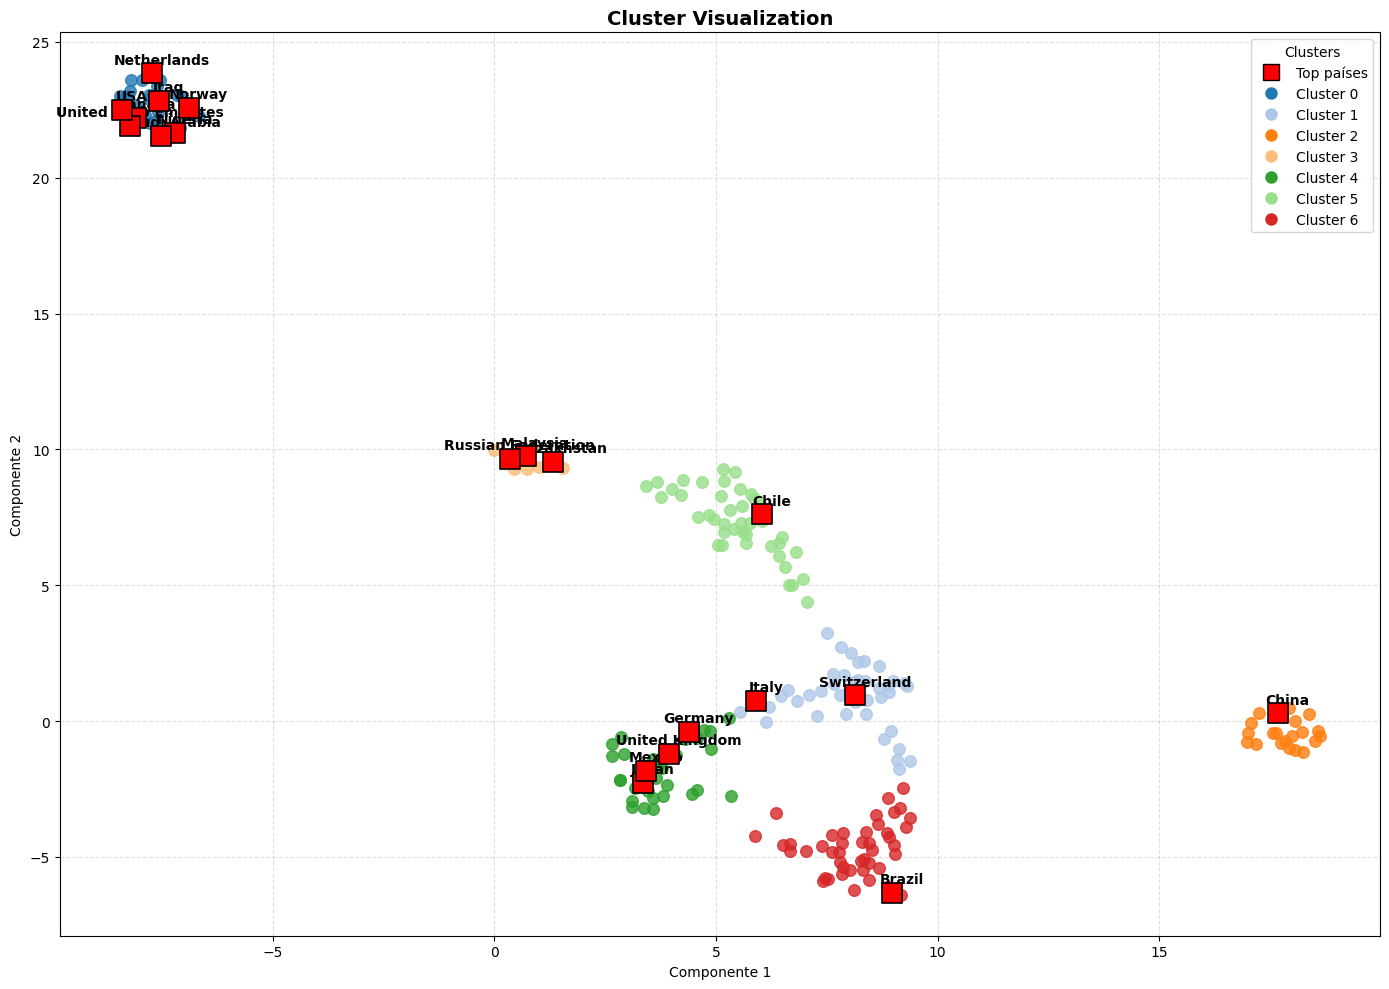

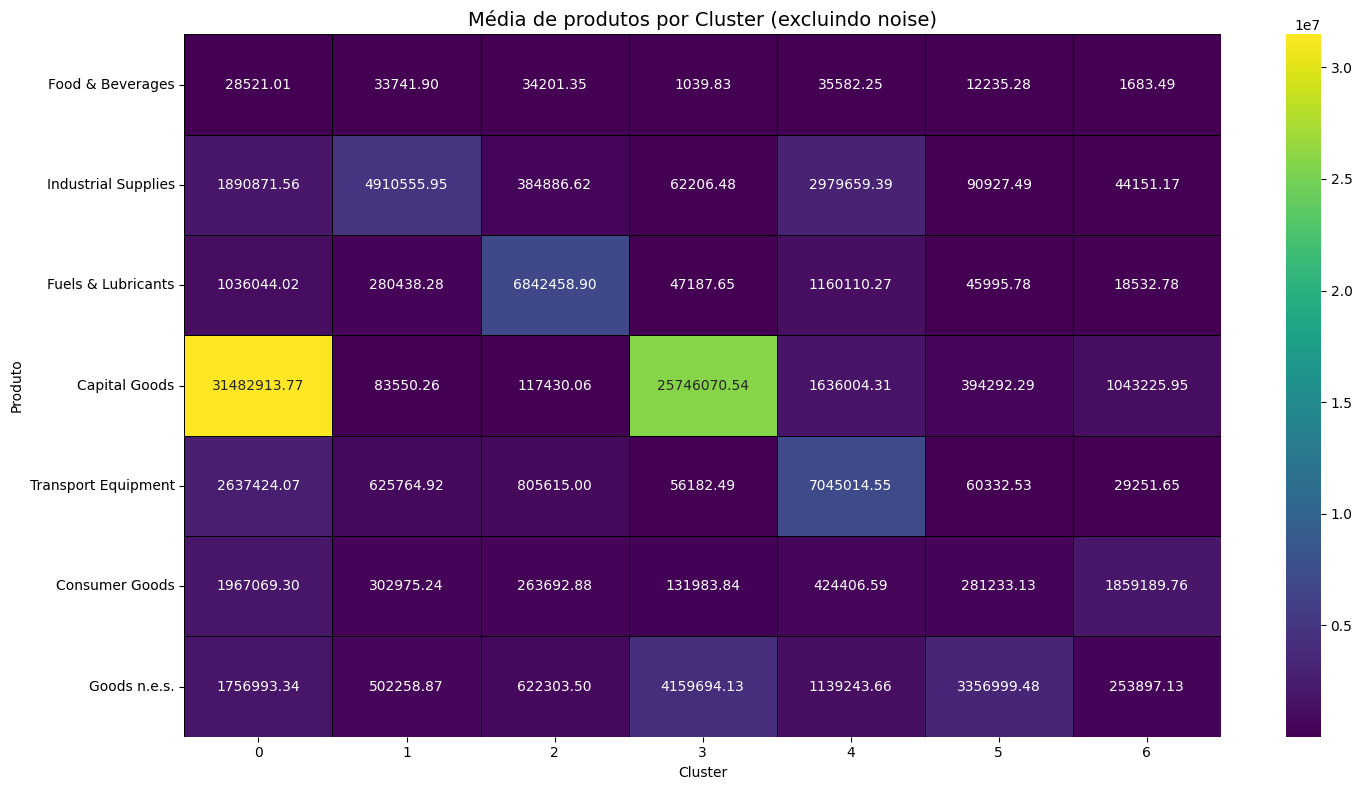

In [163]:
_ = plot_clusters_generic(
    embedding=umap_bec_norm_sz,
    clusters=kmeans_umap_bec_sz,
    matrix_norm=matrix_norm_bec,
    matrix_original=matrix_bec,
    top_countries=top_20_countries_bec,
    heatmap_figsize=(15, 8), 
    save_path=img_path+"bec_umap_kmeans_top20"
)

### Top Importadores por categoria

In [164]:
def top_importer_per_category(matrix):
    top_importers = {}

    for category in matrix.columns:
        top_country = matrix[category].idxmax()
        max_value = matrix[category].max()

        top_importers[category] = (top_country, max_value)

    return top_importers

In [165]:
top_by_category_hs2 = top_importer_per_category(matrix_hs2)
top_by_category_hs2

{'Live animals': ('France', np.float64(2883402.36)),
 'Meat and edible meat offal': ('Brazil', np.float64(22105659.142)),
 'Fish and crustaceans, molluscs and other aquatic invertebrates': ('Norway',
  np.float64(15799028.207)),
 "Dairy produce; birds' eggs; natural honey": ('Germany',
  np.float64(13295370.479)),
 'Products of animal origin, not elsewhere specified or included': ('China',
  np.float64(1751654.915)),
 'Live trees and other plants; bulbs, roots; cut flowers': ('Netherlands',
  np.float64(10493851.041)),
 'Edible vegetables and certain roots and tubers': ('Mexico',
  np.float64(10454902.168)),
 'Edible fruit and nuts; peel of citrus or melons': ('USA',
  np.float64(14152611.528)),
 'Coffee, tea, maté and spices': ('Brazil', np.float64(8273084.023)),
 'Cereals': ('USA', np.float64(24207985.226999998)),
 'Products of the milling industry; malt; starches; inulin; wheat gluten': ('Germany',
  np.float64(2662186.532)),
 'Oil seeds and oleaginous fruits; miscellaneous grains; 

In [166]:
top_by_category_bec = top_importer_per_category(matrix_bec)
top_by_category_bec

{'Food & Beverages': ('China', np.float64(705023.154)),
 'Industrial Supplies': ('Germany', np.float64(56709712.509)),
 'Fuels & Lubricants': ('China', np.float64(128399736.468)),
 'Capital Goods': ('Saudi Arabia', np.float64(171801057.77899998)),
 'Transport Equipment': ('Germany', np.float64(61281198.278)),
 'Consumer Goods': ('Brazil', np.float64(64530099.111)),
 'Goods n.e.s.': ('Chile', np.float64(41573837.817))}

In [167]:
def get_top_exporters_by_category(matrix_original, min_value=None):

    top_country = matrix_original.idxmax(axis=0)
    top_value = matrix_original.max(axis=0)

    df = pd.DataFrame({
        "category": top_country.index,
        "top_country": top_country.values,
        "value": top_value.values
    })

    if min_value:
        df = df[df["value"] >= min_value]

    df = df.sort_values("value", ascending=False).reset_index(drop=True)

    return df


In [168]:
def plot_top_exporters_on_embedding_(
    embedding,
    matrix_original,
    top_df,
    ax=None,
    text_color="red",
    arrowprops=None,
    max_inline=5,
    wrap_width=80,
    save_path=None,
    dpi=300
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    else:
        fig = ax.figure

    if arrowprops is None:
        arrowprops = dict(arrowstyle="->", color="gray", lw=0.8)

    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c="lightgray",
        s=40,
        alpha=0.5,
        zorder=1
    )

    grouped = top_df.groupby("top_country")["category"].apply(list)

    bottom_summary = []

    for country, categories in grouped.items():

        try:
            loc = matrix_original.index.get_loc(country)
        except KeyError:
            continue

        x, y = embedding[loc, 0], embedding[loc, 1]

        ax.scatter(
            x, y,
            c="red",
            s=200,
            edgecolor="black",
            zorder=3
        )

        count = len(categories)
        header = f"{country} ({count})"

        if count > max_inline:
            cats = ", ".join(categories)

            wrapped_cats = textwrap.fill(cats, width=wrap_width)

            bottom_summary.append(f"{header}:\n{wrapped_cats}\n")
            continue

        text = header + "\n" + "\n".join(f"- {c}" for c in categories)

        ax.annotate(
            text,
            (x, y),
            xytext=(8, 8),
            textcoords="offset points",
            fontsize=10,
            color=text_color,
            weight="bold",
            arrowprops=arrowprops,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85)
        )

    if bottom_summary:
        summary_ax = fig.add_axes([0.1, 0.01, 0.8, 0.20])
        summary_ax.axis("off")

        text_block = "\n".join(bottom_summary)

        summary_ax.text(
            0.5, -4,
            text_block,
            ha="center",
            va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.4", fc="white", alpha=0.9)
        )

    ax.set_title("Top Exporters por categoria", fontsize=14, fontweight="bold")
    ax.set_xlabel("Componente 1")
    ax.set_ylabel("Componente 2")
    ax.grid(True, linestyle="--", alpha=0.4)

    if save_path is not None:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    return ax


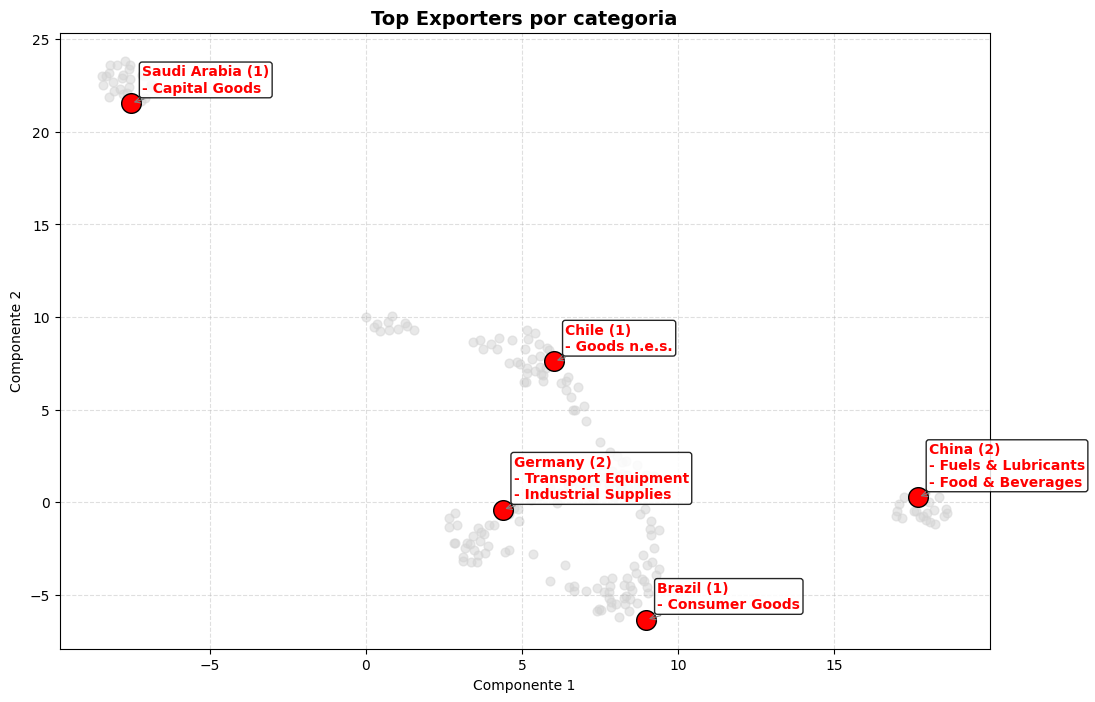

In [169]:
top_df_bec = get_top_exporters_by_category(matrix_original=matrix_bec, min_value=0)

ax = plot_top_exporters_on_embedding_(
    embedding=umap_bec_norm_sz,
    matrix_original=matrix_bec,
    top_df=top_df_bec, 
    save_path=img_path+"bec_umap_kmeans_top1cat"
)

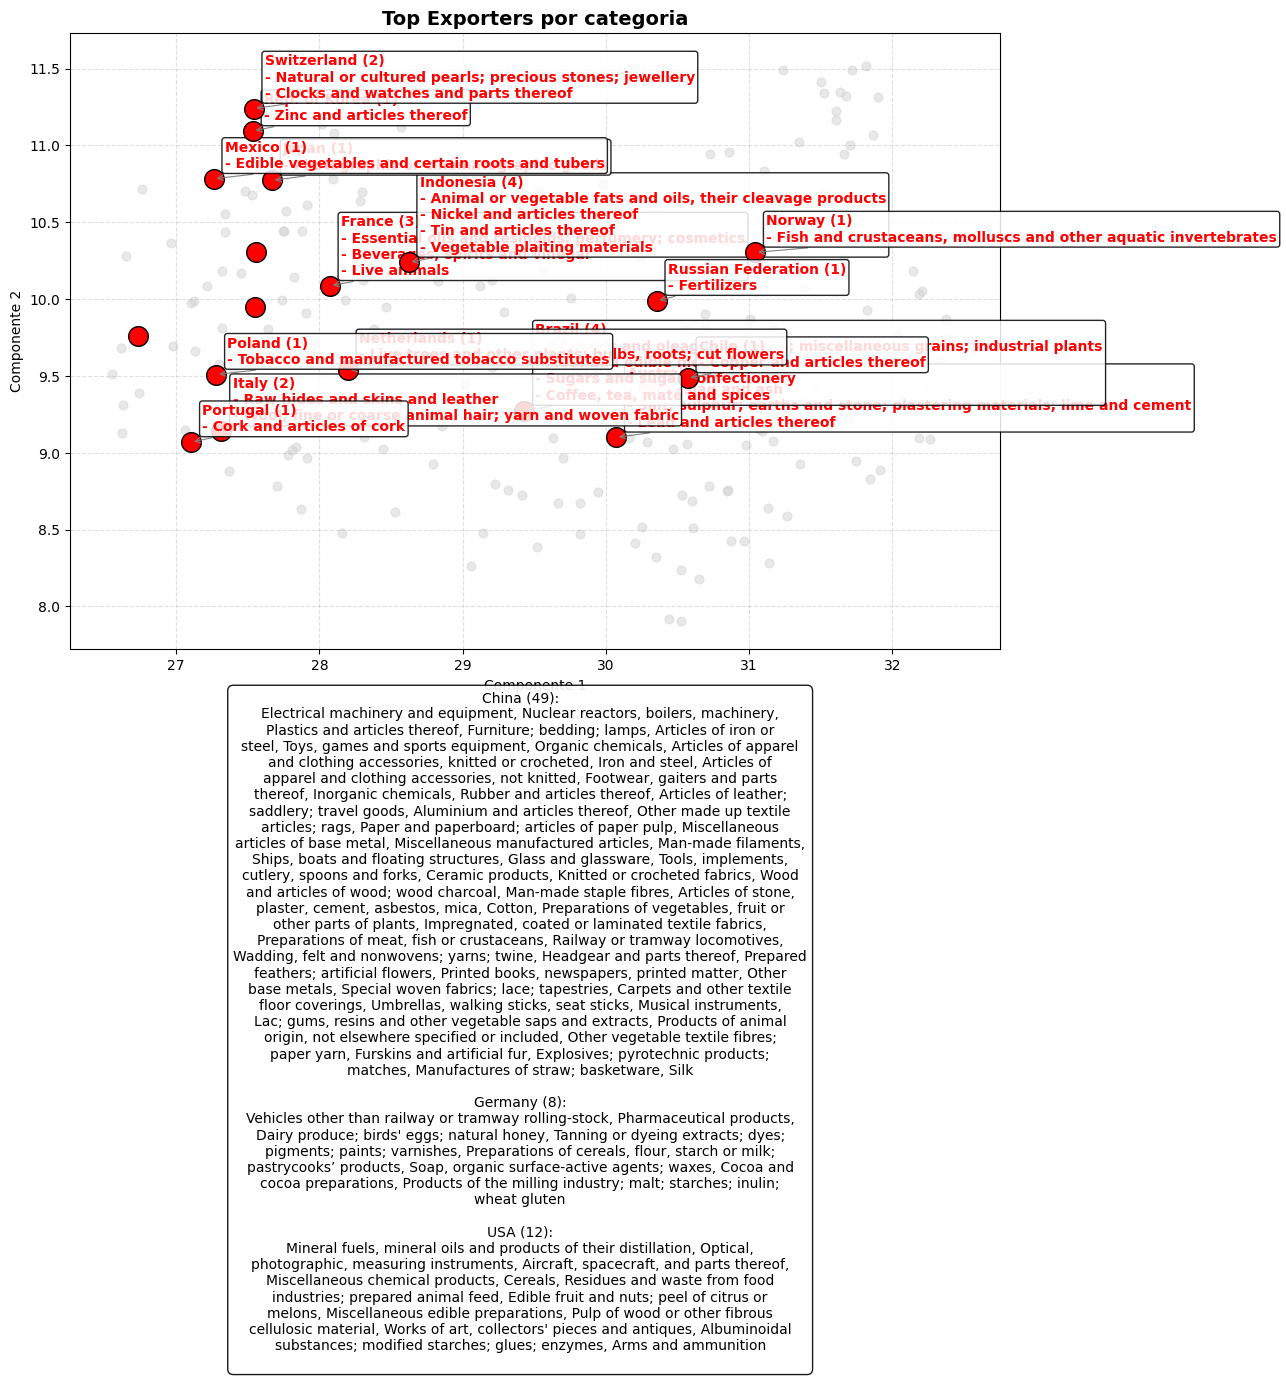

In [170]:
top_df_hs2 = get_top_exporters_by_category(matrix_original=matrix_hs2, min_value=0)

ax = plot_top_exporters_on_embedding_(
    embedding=umap__hs2[0],
    matrix_original=matrix_hs2,
    top_df=top_df_hs2, 
    save_path=img_path+"hs2_umap_dbscan_top1cat"
)

### Top países por tipo de produto

In [171]:
def plot_top_n_with_embedding(
    matrix_original,
    embedding,
    category=None,
    top_n=5,
    scatter_color="lightgray",
    top_color="red",
    save_path=None,
    dpi=300
):

    categories = [category] if category else matrix_original.columns.tolist()

    for cat in categories:
        if cat not in matrix_original.columns:
            print(f"Categoria {cat} não existe. Pulando.")
            continue

        top_df = (
            matrix_original[[cat]]
            .sort_values(by=cat, ascending=False)
            .head(top_n)
            .reset_index()
        )

        fig1, ax1 = plt.subplots(figsize=(10, 8))

        ax1.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=scatter_color,
            s=50,
            alpha=0.5,
            zorder=1
        )

        for _, row in top_df.iterrows():
            country = row[matrix_original.index.name] if matrix_original.index.name else row[0]
            try:
                loc = matrix_original.index.get_loc(country)
            except KeyError:
                continue

            x, y = embedding[loc, 0], embedding[loc, 1]
            ax1.scatter(
                x, y,
                c=top_color,
                s=200,
                edgecolor="black",
                zorder=3
            )
            ax1.annotate(
                country,
                (x, y),
                xytext=(8, 8),
                textcoords="offset points",
                fontsize=10,
                weight="bold",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85)
            )

        ax1.set_title(f"Top {top_n} países em {cat}", fontsize=14, fontweight="bold")
        ax1.set_xlabel("Componente 1")
        ax1.set_ylabel("Componente 2")
        ax1.grid(True, linestyle="--", alpha=0.4)
        fig1.tight_layout()

        if save_path:
            fig1.savefig(
                f"{save_path}_{cat}_embedding.png",
                dpi=dpi,
                bbox_inches="tight"
            )

        plt.show()

        fig2, ax2 = plt.subplots(figsize=(6, 0.5 * top_n + 1.5))
        ax2.axis("off")

        n_rows, n_cols = top_df.shape
        cell_colors = np.ones((n_rows, n_cols, 3))

        max_val = top_df[cat].max()
        val_colors = plt.cm.Reds(top_df[cat] / max_val)[:, :3]
        cell_colors[:, -1, :] = val_colors

        table = ax2.table(
            cellText=top_df.values,
            colLabels=top_df.columns,
            cellColours=cell_colors,
            loc="center",
            cellLoc="center"
        )

        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)

        ax2.set_title(
            f"Top {top_n} países exportando {cat}",
            fontsize=14,
            fontweight="bold"
        )

        fig2.tight_layout()

        if save_path:
            fig2.savefig(
                f"{save_path}_{cat}_table.png",
                dpi=dpi,
                bbox_inches="tight"
            )

        plt.show()


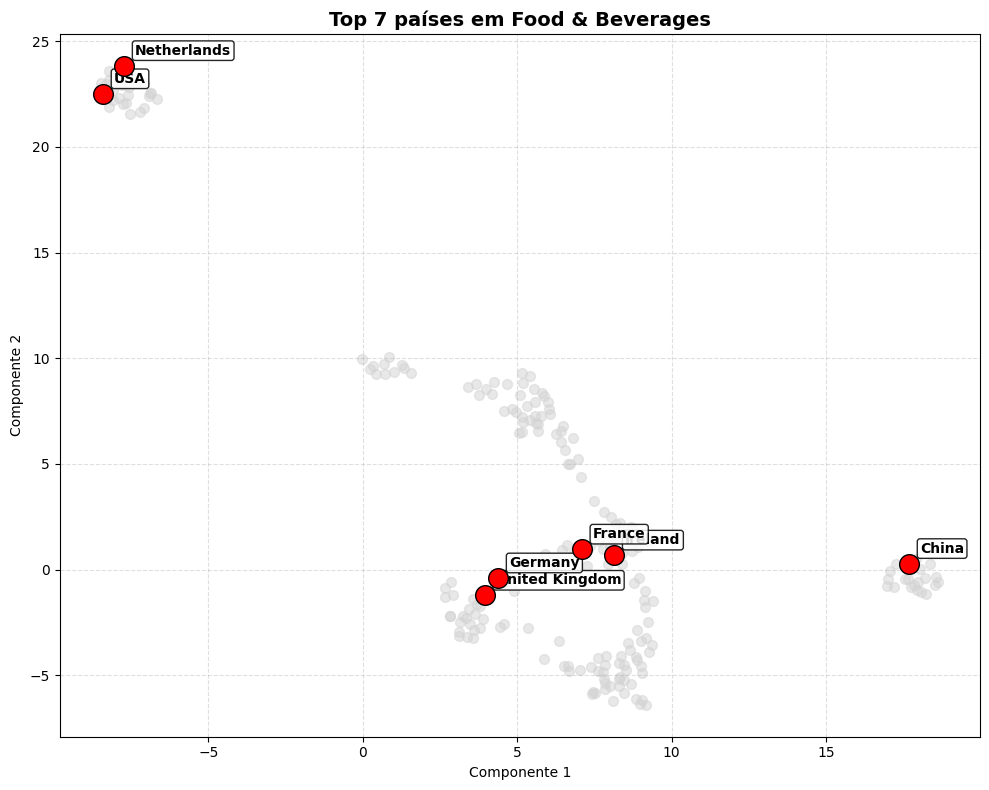

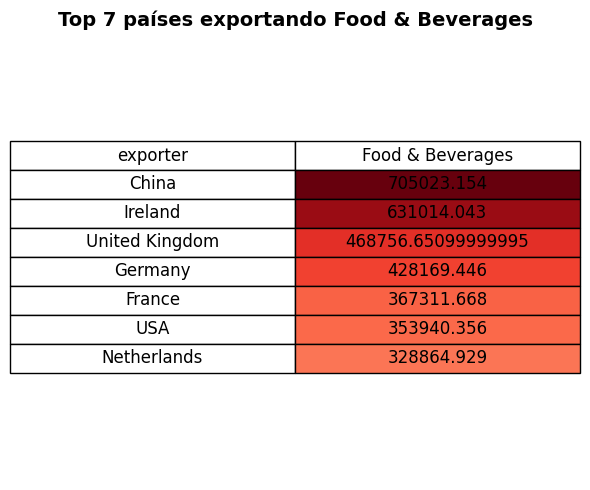

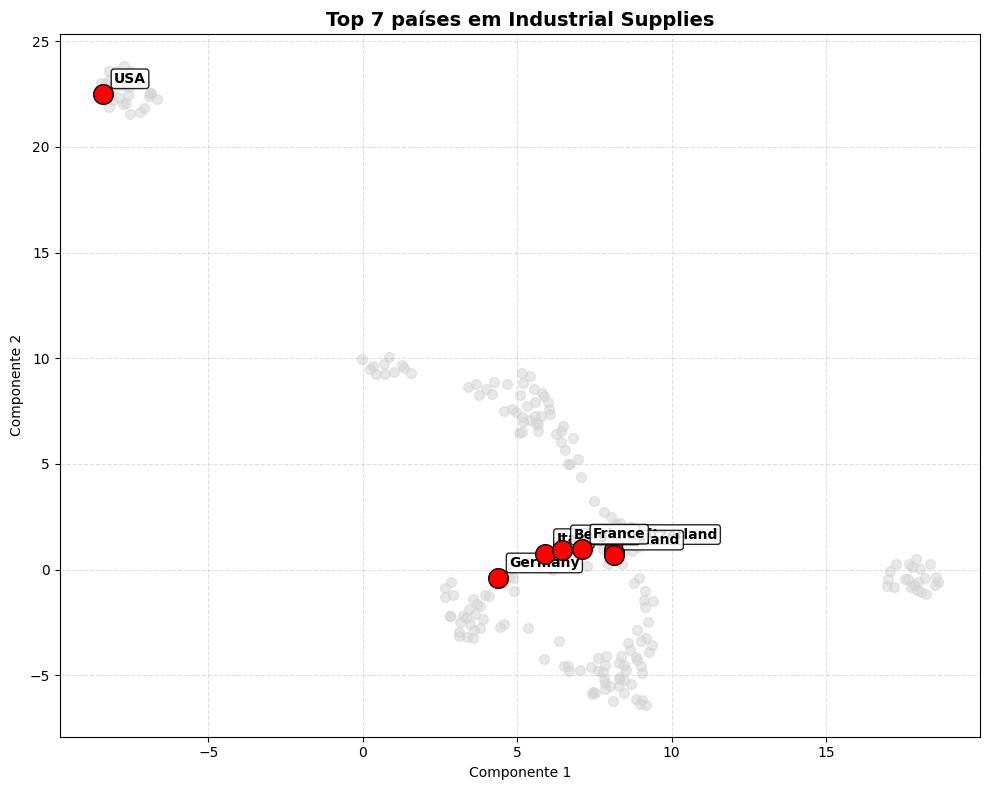

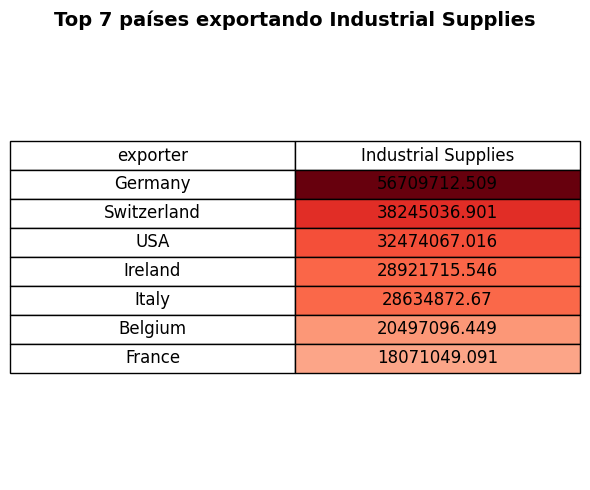

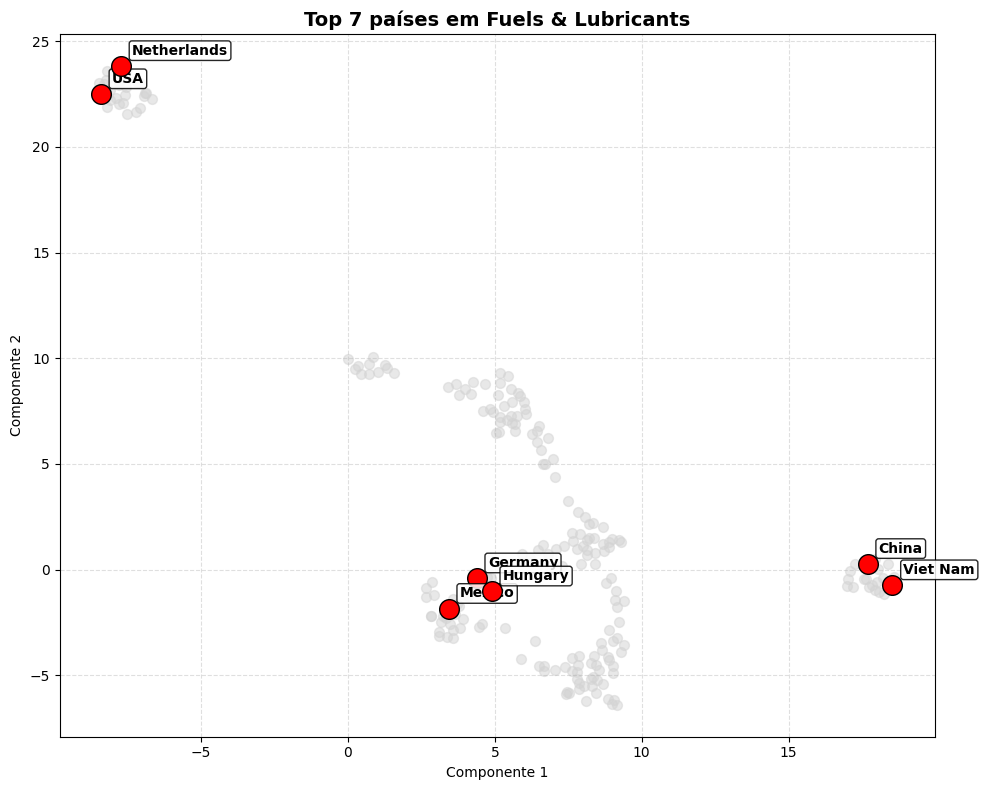

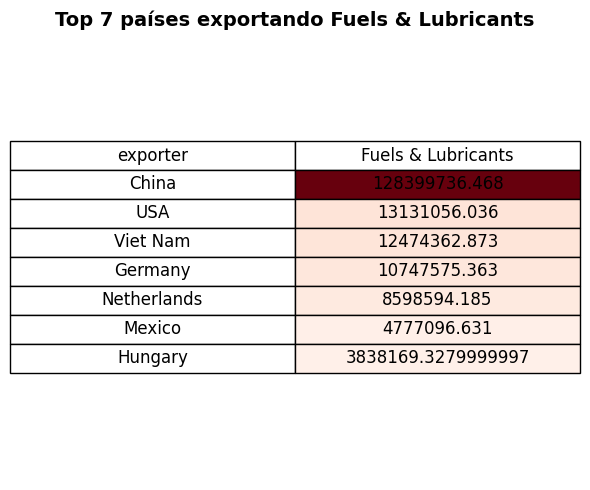

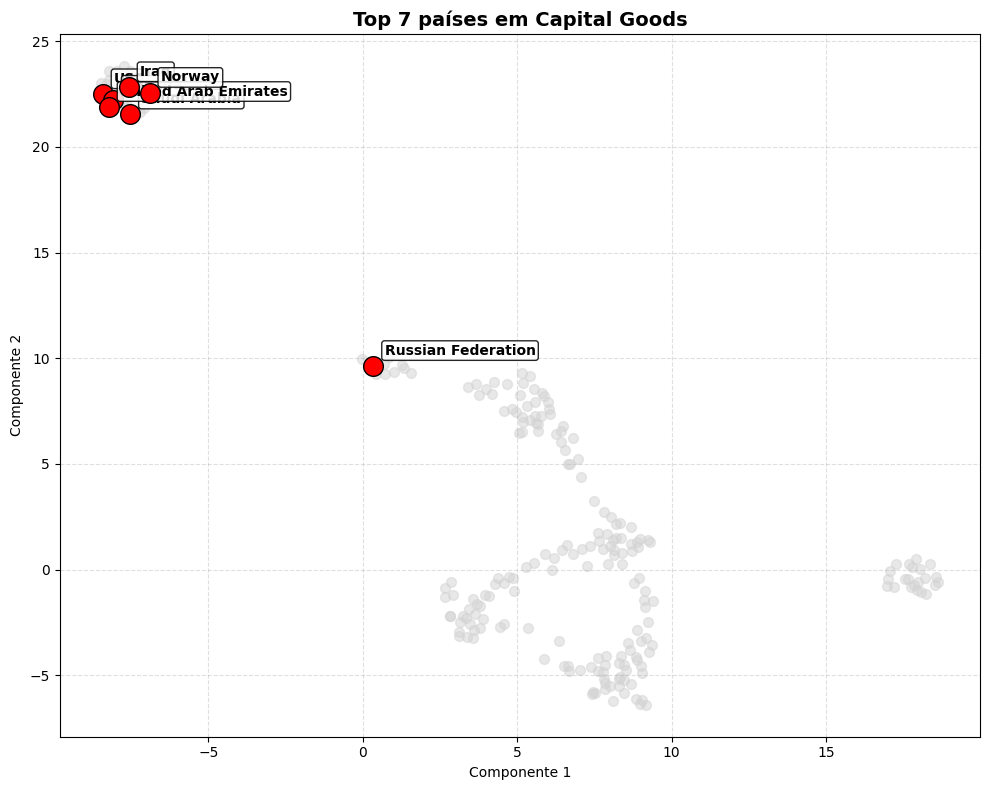

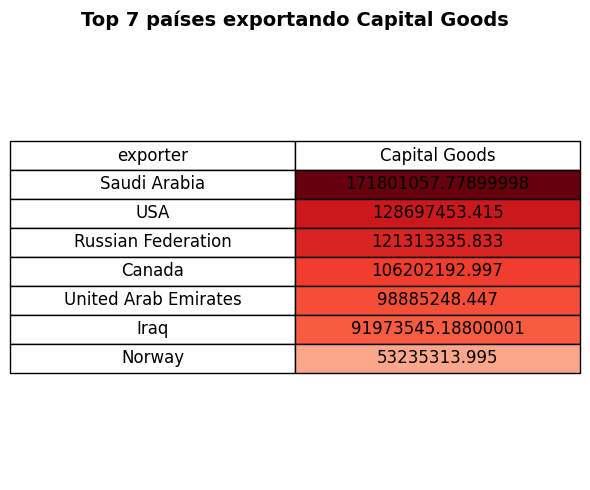

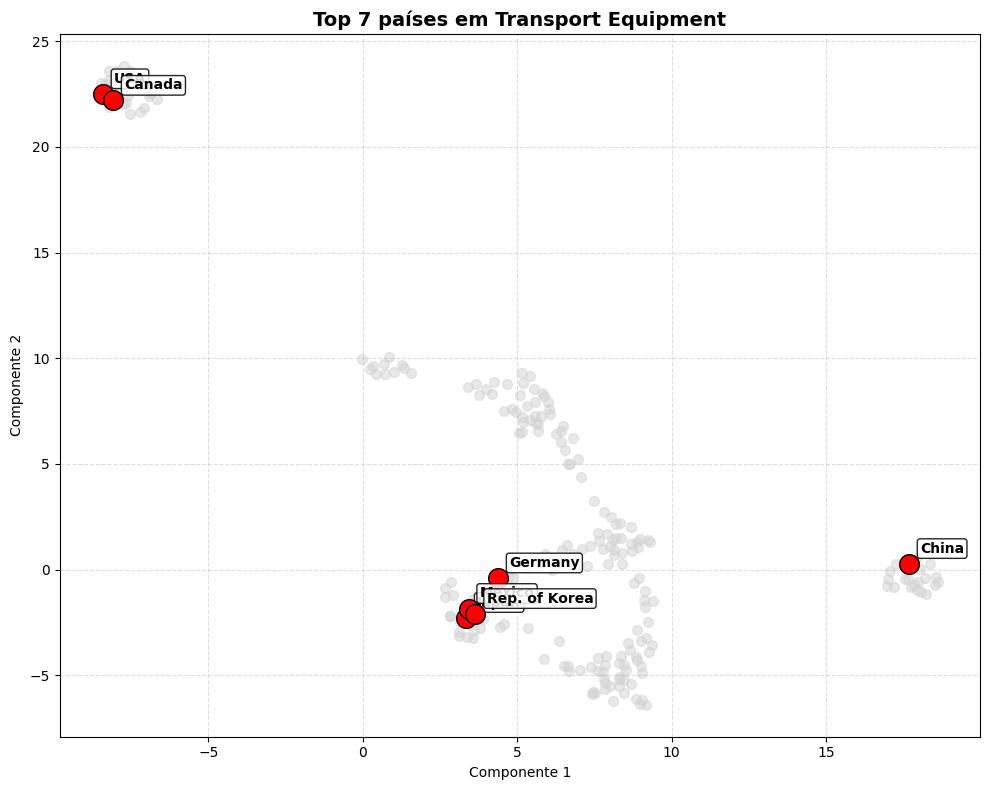

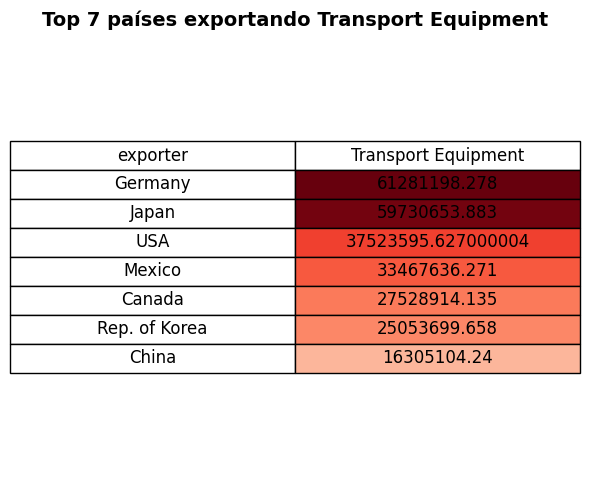

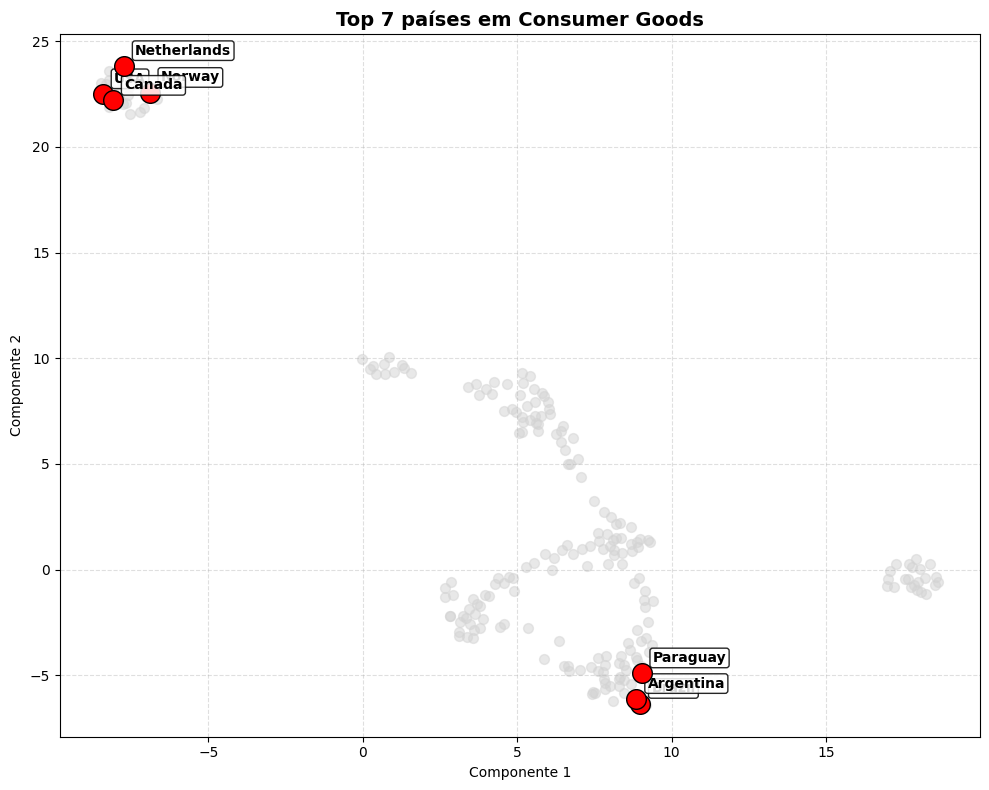

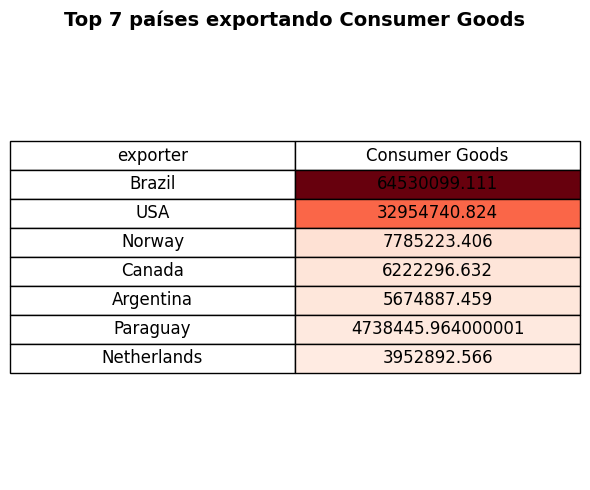

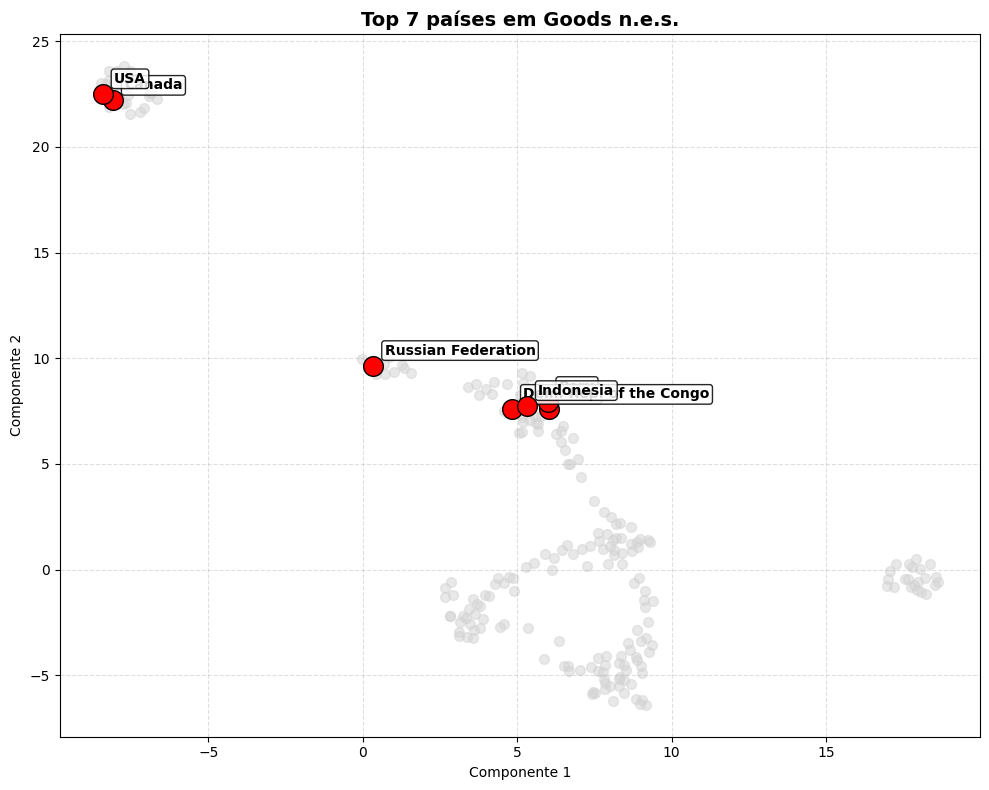

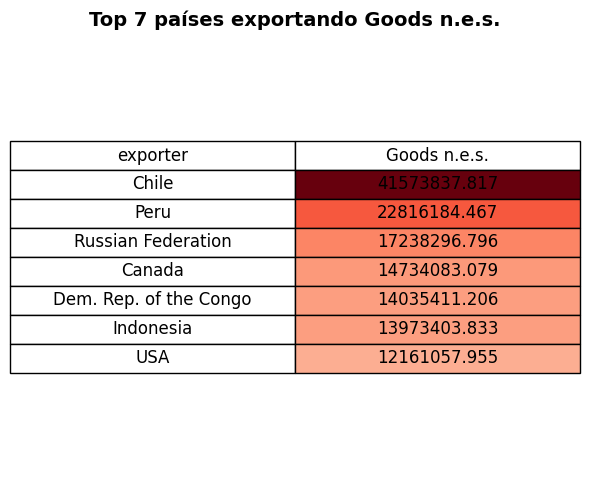

In [172]:
plot_top_n_with_embedding(
    matrix_original=matrix_bec,
    embedding=umap_bec_norm_sz,
    top_n=7, 
    save_path=img_path+"bec_umap_kmeans_top7prod"
)

In [173]:
hs2_categories = matrix_hs2.columns.tolist()
hs2_categories[:5]

['Live animals',
 'Meat and edible meat offal',
 'Fish and crustaceans, molluscs and other aquatic invertebrates',
 "Dairy produce; birds' eggs; natural honey",
 'Products of animal origin, not elsewhere specified or included']

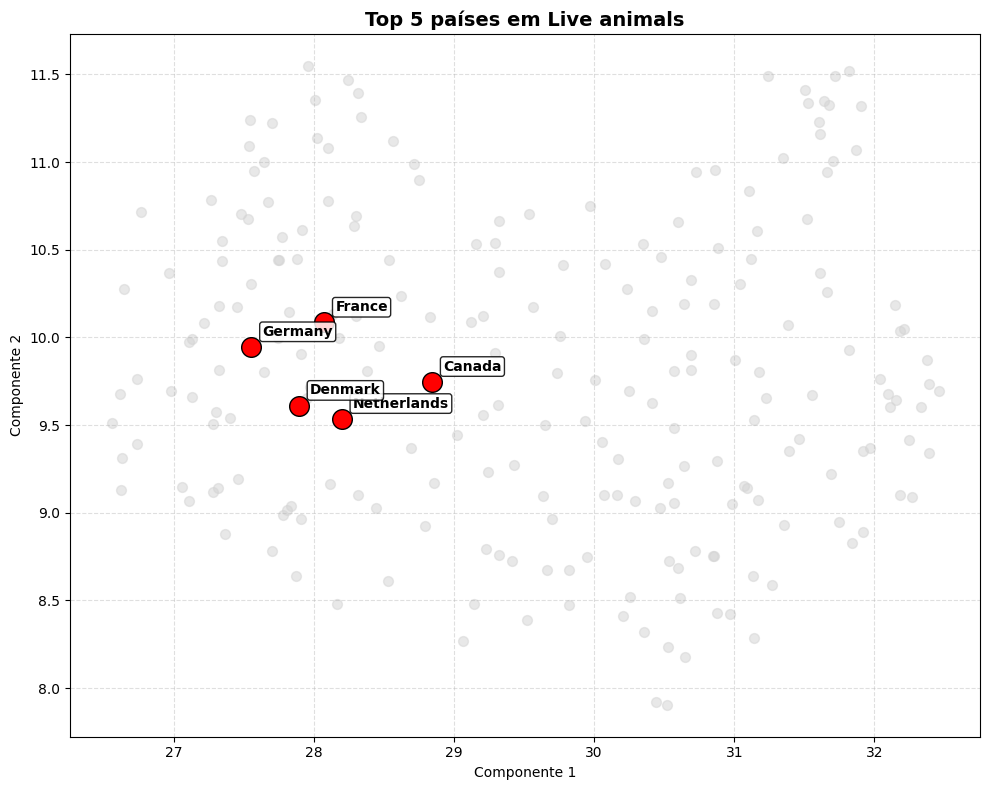

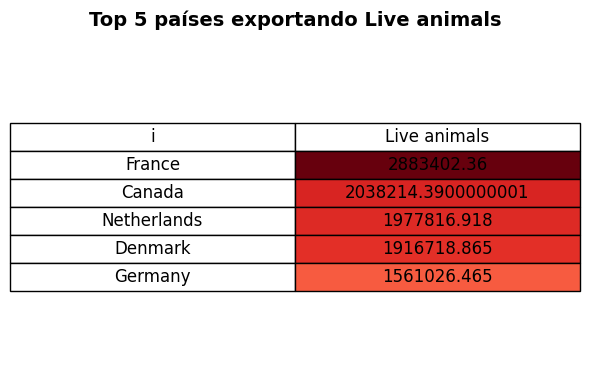

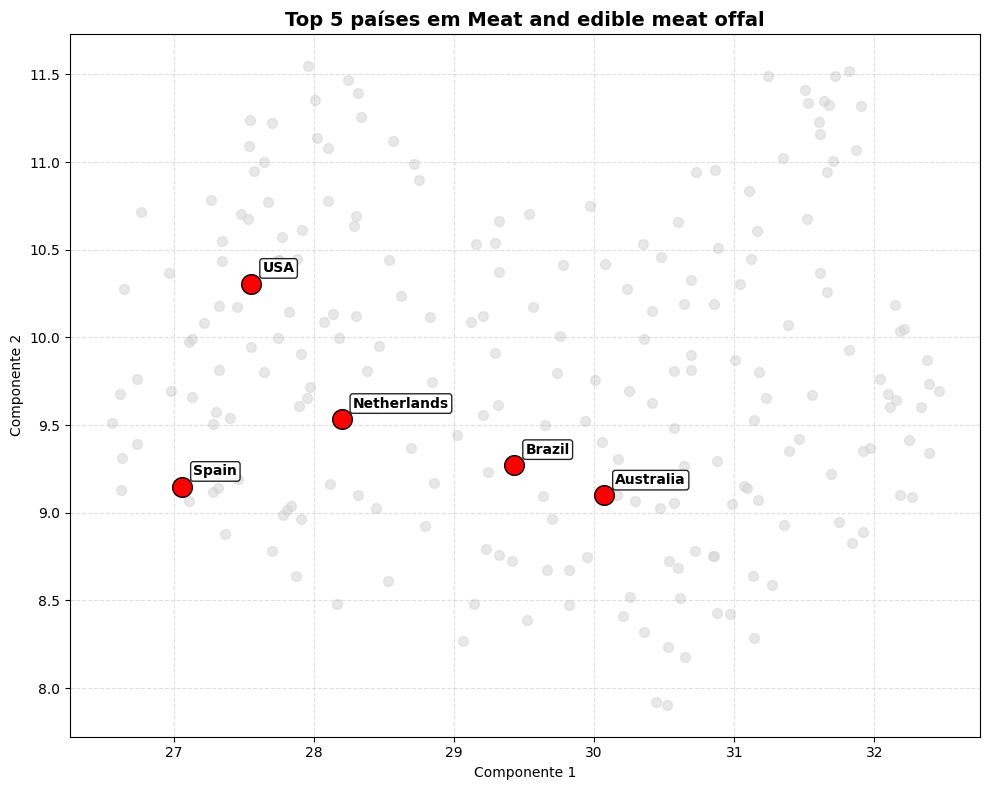

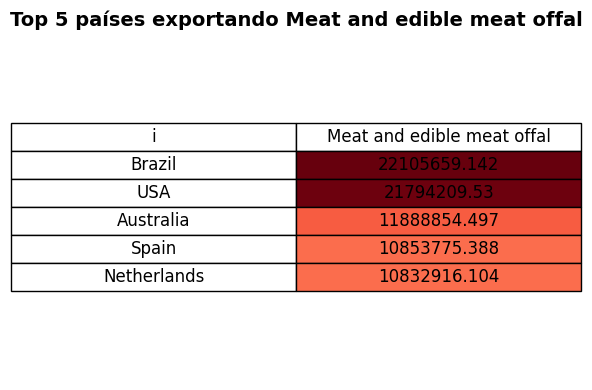

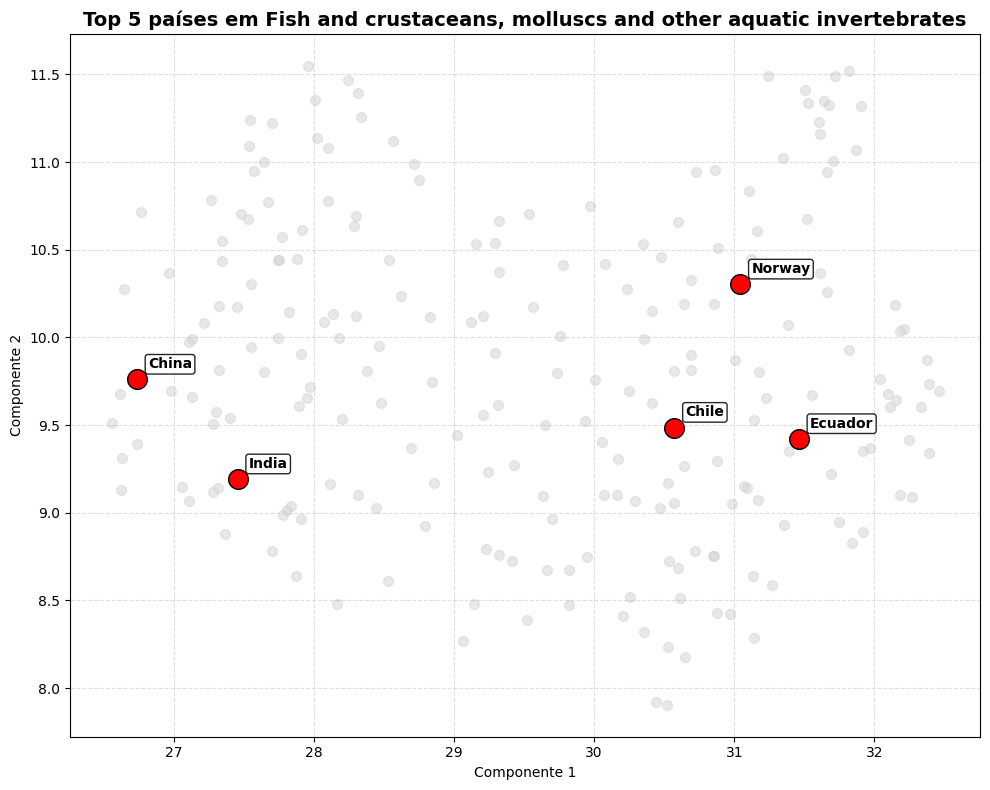

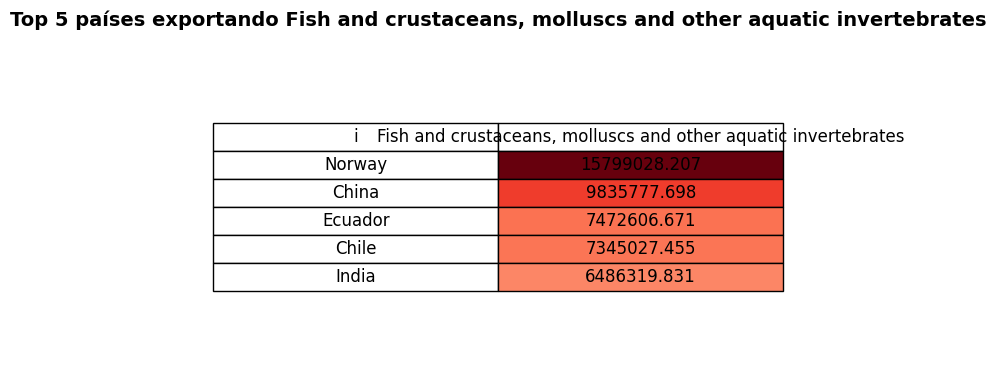

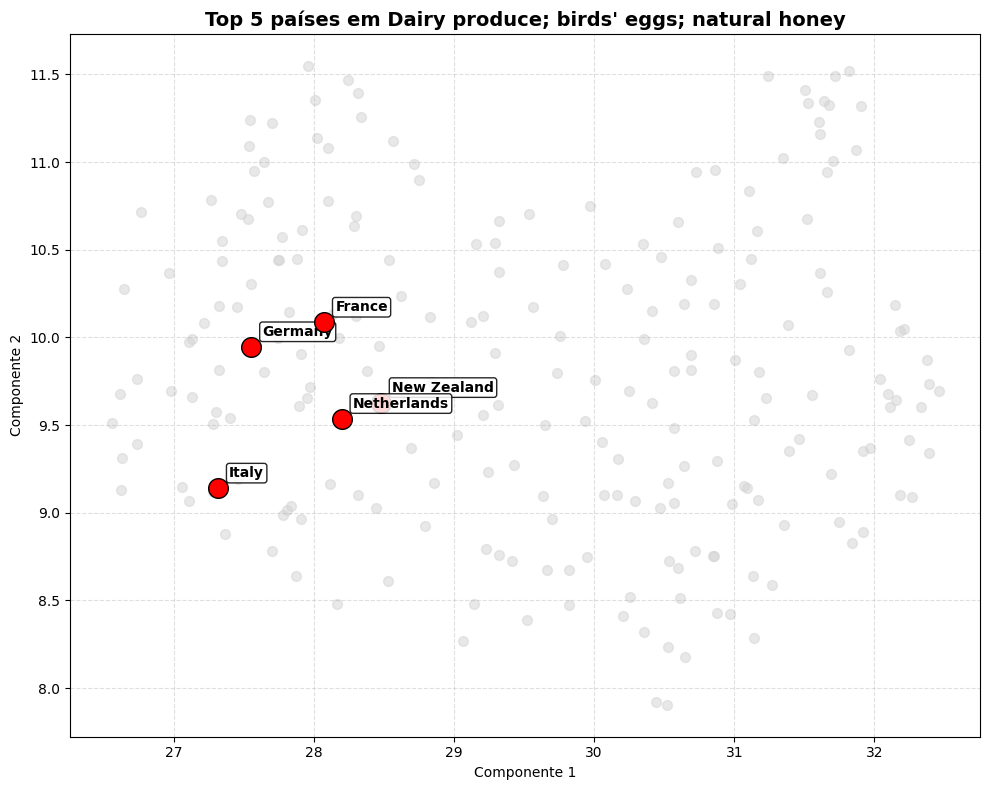

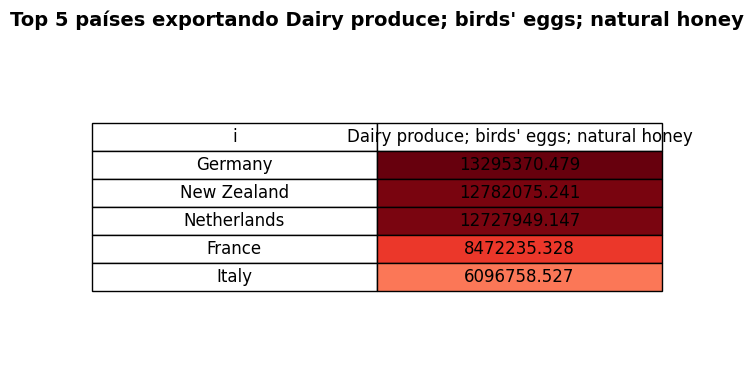

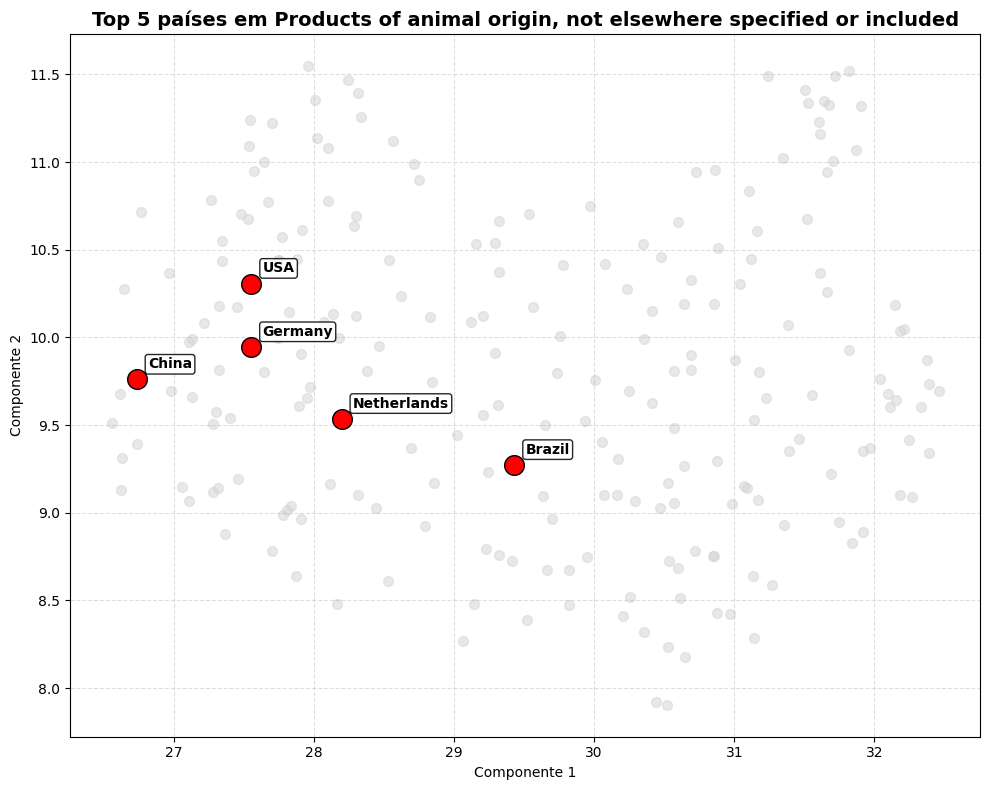

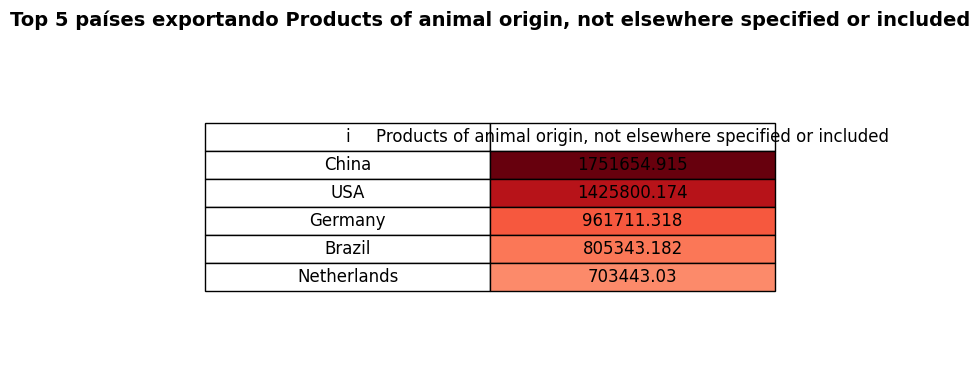

In [174]:
for cat in hs2_categories[:5]:
    plot_top_n_with_embedding(
        matrix_original=matrix_hs2,
        embedding=umap__hs2[0],
        category=cat,
        top_n=5, 
        save_path=img_path+"hs2_umap_dbscan_top5prod"
    )

## Conclusão

Esta análise exploratória utilizou o UMAP como a técnica mais eficaz para a redução de dimensionalidade, gerando visualizações claras e clusters bem definidos. A clusterização foi adaptada à granularidade dos dados: DBSCAN para a classificação detalhada HS2, revelando especializações de produtos como combustíveis minerais ou maquinário elétrico, e K-Means para as categorias econômicas amplas BEC, que agruparam países por uso final dos produtos como bens de capital ou alimentos e bebidas. Essa abordagem dupla permitiu uma compreensão robusta da especialização econômica global, destacando tanto nichos de mercado quanto o posicionamento dos países nas cadeias de valor internacionais.

A clusterização com base na classificação HS2, utilizando UMAP e DBSCAN, revelou quatro clusters principais com perfis de exportação distintos:

*   **Cluster 0 (o maior)**: Dominado pela exportação de combustíveis minerais, óleos minerais, produtos destilados, pérolas, pedras preciosas e joalheria. Países como a Rússia e a Arábia Saudita provavelmente se enquadram aqui devido à sua forte dependência de commodities energéticas e minerais.
*   **Cluster 1 (o segundo maior)**: Caracterizado por maquinário elétrico e equipamentos, e reatores nucleares e boilers. Este cluster sugere países com alta capacidade de industrialização e exportação de bens manufaturados de alto valor agregado, como a China e a Alemanha.
*   **Cluster 2**: Focado em produtos aquáticos, como peixes, crustáceos, moluscos e invertebrados aquáticos, incluindo seus preparos. Noruega e Equador são exemplos de países que se destacam nesse tipo de exportação.
*   **Cluster 3**: Especializado na exportação de navios, barcos e estruturas flutuantes, além de aeronaves, espaçonaves e suas partes. Este cluster representa países com forte indústria de transporte e tecnologia aeroespacial.

A análise por HS2 permite identificar a especialização de países em categorias de produtos muito específicas, oferecendo insights sobre suas vantagens comparativas em setores industriais ou extrativos. Por exemplo, a França se destaca em "Animais Vivos", o Brasil em "Carne e Miudezas Comestíveis", e a China em "Máquinas Elétricas e Equipamentos".

A clusterização com base na classificação BEC1, utilizando UMAP e K-Means (7 clusters), forneceu uma perspectiva sobre os perfis de exportação dos países de acordo com o uso final econômico dos bens. Os países se agruparam em torno das seguintes categorias, com alguns exemplos de países líderes:

*   **Food & Beverages (Alimentos e Bebidas)**: Brasil e EUA se destacam na exportação desta categoria, refletindo sua forte base agrícola e agroindustrial.
*   **Industrial Supplies (Insumos Industriais)**: Alemanha lidera, indicando sua robusta indústria que fornece materiais e componentes para a produção global.
*   **Fuels & Lubricants (Combustíveis e Lubrificantes)**: China e Arábia Saudita são proeminentes, evidenciando sua importância como produtores e/ou consumidores de energia.
*   **Capital Goods (Bens de Capital)**: Arábia Saudita e Alemanha são fortes exportadores, representando a capacidade de fornecer máquinas e equipamentos para a produção de outros bens.
*   **Transport Equipment (Equipamentos de Transporte)**: Alemanha é um dos principais exportadores, o que é consistente com sua indústria automobilística e de engenharia avançada.
*   **Consumer Goods (Bens de Consumo)**: Brasil e China se destacam, refletindo grandes mercados consumidores e cadeias de produção.
*   **Goods n.e.s. (Bens não especificados em outro lugar)**: Chile é um país notável, sugerindo uma diversidade de exportações que não se encaixam perfeitamente nas categorias mais específicas.

A clusterização BEC revela as macro-orientações econômicas dos países, como a especialização em bens de capital, insumos industriais ou bens de consumo, e ajuda a entender suas posições nas cadeias de valor globais.

Esse projeto tem um grande potencial, existem várias formas de classificar produtos, como o BEC2, BEC3, HS4, entre outros. Eles poderiam ser utilizados para aprimorar a análise e descobrir qual a forma mais eficaz para utilizar em aprendizado de máquina. Além disso poderia haver mais formas de analisar os países e como eles estão colocados dentro dos clusters. Também pode haver alguma forma melhor de clusterização que não foi utilizada nesse projeto.